## Employee Burnout Prediction

#### Project Objective:
The goal of this project is to understand and observe the mental health of all the employees in one company, and predict the burnout rate of employees based on the provided features thus helping the company to take appropriate measures for their employees. 

#### Feature Summary:

* **Employee ID**: The unique ID allocated for each employee
* **Date of Joining**: The date time when the employee has joined the organization
* **Gender**: The gender of the employee (Male/Female)
* **Company Type**: The type of company where the employee is working (Service/Product)
* **WFH Setup Available**: Is the work from home facility available for the employee (Yes/No)
* **Designation**: The designation of the employee of work in the organization. 
    In the range of [0.0, 5.0] bigger is higher designation.
* **Resource Allocation**: The amount of resource allocated to the employee to work, ie. number of working hours.
    In the range of [1.0, 10.0] (higher means more resource)
* **Mental Fatigue Score**: The level of fatigue mentally the employee is facing.
    In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
* **Burn Rate**: The value we need to predict for each employee telling the rate of Bur out while working.
    In the range of [0.0, 1.0] where the higher the value is more is the burn out.

#### Feature Analysis:

Analysis of single vairable's correlations with Burn Rate
* **Date of Joining**: no strong correlations with fatigure score found yet, still working on it
* **Gender**: no strong correlations with fatigure score found, but Male's average fature score is relatively higher than female
* **Company Type**: no strong correlations with fatigure score found
* **WFH Setup Available**: some negative correlation with fatigure score, average fatigure score without WFH setup is 6.3, with WFH setup available is 5.2
* **Designation**: high correlation: 0.74 
* **Resource Allocation**: high correlation: 0.86 
* **Mental Fatigure Score**: Mental Fatigure Score and Burn Rate are higly correlated, Correlation:0.94

#### Feature Engineering
We try some feature combination based on the result from the property of feature selection from tree methods. After careful analysis we preserve three feature combinations. Bascially we first manaully combine every features of high importance given from the boosting tree, then we run the LR to get the relative weight to see whether we should perserve combined features. The process is tedious so we do not present in the notebook.
'Designation_Resource','Designation_Gender_mfs', 'Gender_WFH_mfs'
* **Designation_Resource**: Combined feature between Designation and Resource Allocation.
* **Designation_Gender_mfs**: Combined feature among Designation, Gender and Mental Fatigure Score.
* **Gender_WFH_mfs**: Combined feature among Gender, WFH Setup Available and Mental Fatigure Score.

#### Possible plots:
* Interactive visualization of fatigure score distribution across gender, wfh setup available, company type
* Interactive visualization of fatigure score across different level of designation
* Interactive visualization of fatigure score across different level of resource allocation 

In [23]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import hstack
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, r2_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn import metrics
import pickle

#from catboost import CatBoostRegressor
#import category_encoders as ce
#import xgboost as xgb
#import lightgbm as lgb
#from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

In [2]:
# download dataset and saved under folder "data" in working directory
#import dataset
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sample_submission.csv')
print('taining data shape:',train.shape)
print('test data shape:',test.shape)
print('sample data shape:',sample.shape)

taining data shape: (22750, 9)
test data shape: (12250, 8)
sample data shape: (5, 2)


### Exploratory Data Analysis

#### 1. First we look at the training data, variables format, miss values etc. 

In [3]:
# check missing values
print(" \nCount total NaN at each column in a DataFrame:\n ", train.isnull().sum())

 
Count total NaN at each column in a DataFrame:
  Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64


In [4]:
#remove missing values form last three coloms
train = train.dropna(subset=['Resource Allocation','Mental Fatigue Score','Burn Rate']).reset_index(drop=True)

In [5]:
train.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,18590.000000,18590.000000,18590.000000,18590.000000
mean,2.179398,4.486552,5.732173,0.452444
std,1.133148,2.044848,1.920547,0.197848
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [6]:
# sns configurations
sns.set_style(style="whitegrid")
title_font = {"family":"sans-serif", 
              "weight":"normal", 
              "color":"darkgreen", 
              "size":16}
axis_font = {"family":"serif", 
             "weight":"normal", 
             "color":"darkgreen", 
             "size":14}

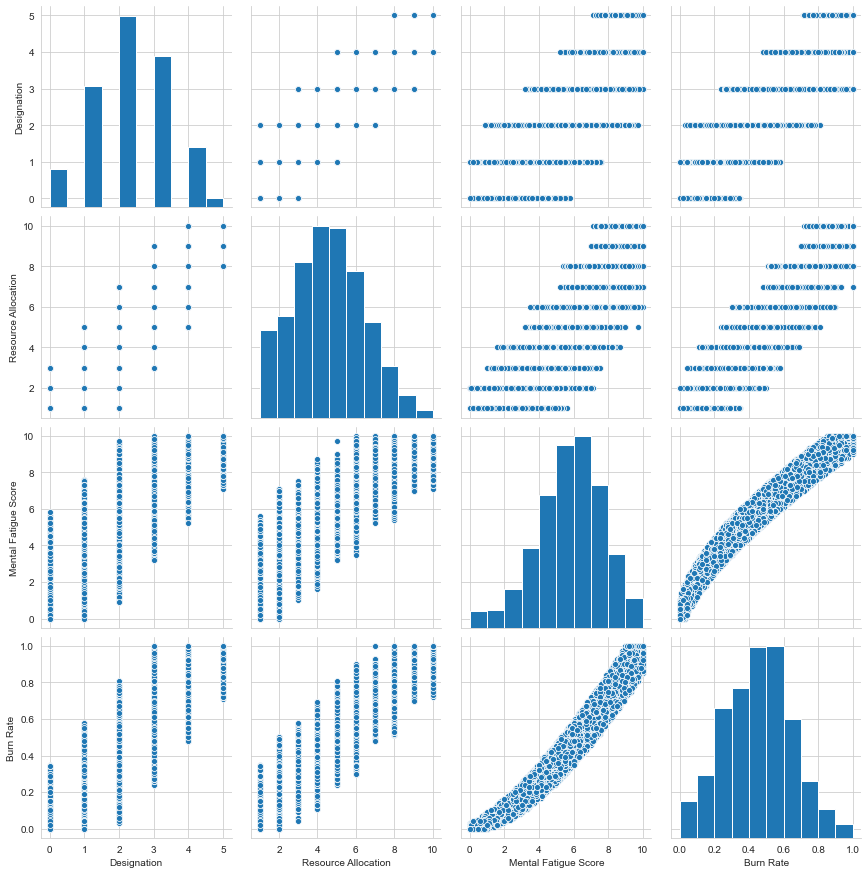

In [7]:
sns_plot = sns.pairplot(train, height=3)
sns_plot.savefig("pairplot.png")

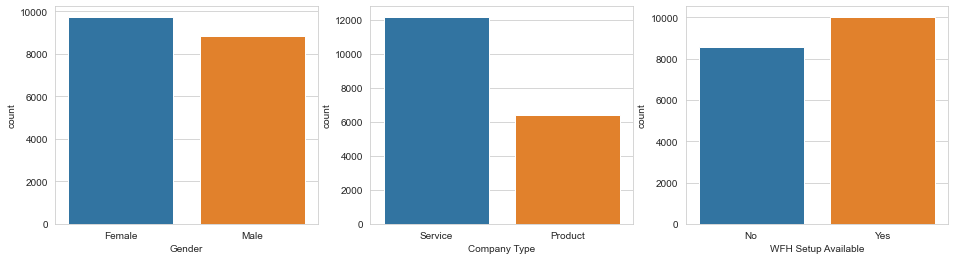

In [8]:
# visualize the categorical feature
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,4))
sns.countplot(train['Gender'], ax=ax[0])
sns.countplot(train['Company Type'], ax=ax[1])
sns.countplot(train['WFH Setup Available'], ax=ax[2])
fig.show()

In [9]:
train.groupby(['WFH Setup Available']).mean()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
WFH Setup Available,,,,
No,2.463785,5.118224,6.309439,0.518227
Yes,1.936690,3.947458,5.239511,0.396303


In [10]:
train.groupby(['Gender']).mean()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Gender,,,,
Female,2.060121,4.211757,5.465538,0.422938
Male,2.310867,4.789438,6.026066,0.484967


In [11]:
train.groupby(['Company Type']).mean()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Company Type,,,,
Product,2.165368,4.470231,5.719748,0.450835
Service,2.186792,4.495154,5.738722,0.453292


### Pre-process Data

#### 1. Transfrom categorical variables
#### 2. Format date of joining and convert the variable to senority

In [12]:
### transform 3 categorical feature

def wfh_encoder(data):
    if data["WFH Setup Available"] == "Yes":
        return 1
    return 0
def data_encoder(df):
    df["WFH Setup Available"] = df.apply(wfh_encoder, axis=1)
    df = pd.get_dummies(data=df,columns=['Gender', 'Company Type'], drop_first=True)
    return df

# define evaluation metrics
def eval_model(model, xtrain, xtest, ytrain, ytest):
    r2_train = cross_val_score(model,xtrain,ytrain,cv=10,scoring="r2").mean()
    r2_test = cross_val_score(model,xtest,ytest,cv=10,scoring="r2").mean()
    mse_train = abs(cross_val_score(model,xtrain,ytrain,cv=10,scoring = "neg_mean_squared_error").mean())
    mse_test = abs(cross_val_score(model,xtest,ytest,cv=10,scoring = "neg_mean_squared_error").mean())
    print("r2 score for train: "+str(round(100*r2_train,2))+"%")
    print("r2 score for test: "+str(round(100*r2_test,2))+"%")
    print("MSE score for train: "+str(round(100*mse_train,2))+"%")
    print("MSE score for test: "+str(round(100*mse_test,2))+"%")

In [13]:
train_encoded = data_encoder(train)
test_encoded = data_encoder(test)

In [14]:
train_encoded.head()

,Employee ID,Date of Joining,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Male,Company Type_Service
0,fffe32003000360033003200,2008-09-30,0,2.0,3.0,3.8,0.16,0,1
1,fffe3700360033003500,2008-11-30,1,1.0,2.0,5.0,0.36,1,1
2,fffe32003400380032003900,2008-11-03,1,1.0,1.0,2.6,0.20,1,1
3,fffe31003900340031003600,2008-07-24,0,3.0,7.0,6.9,0.52,0,1
4,fffe3300350037003500,2008-11-26,1,2.0,4.0,3.6,0.29,1,0


In [15]:
from xgboost import XGBRegressor
train_encoded = train_encoded.drop_duplicates(keep='first')  # dropping duplicates
cols = ['WFH Setup Available','Designation','Resource Allocation',
        'Mental Fatigue Score','Burn Rate', 'Gender_Male','Company Type_Service']
df_first =train_encoded[cols]
xtrain_first, xtest_first, ytrain_first, ytest_first = train_test_split(df_first.loc[:, df_first.columns != "Burn Rate"],
                                                       df_first.loc[:, df_first.columns == "Burn Rate"],
                                                       test_size=0.3, random_state=88)

model_xgb_first=XGBRegressor(max_depth=5,min_child_weight=4)
model_xgb_first.fit(xtrain_first, ytrain_first)
eval_model(model_xgb_first, xtrain_first, xtest_first, ytrain_first, ytest_first)

pd.DataFrame({"feature":list(xtrain_first.columns),"score":model_xgb_first.feature_importances_}).sort_values(by='score',ascending=False)

r2 score for train: 92.67%
r2 score for test: 92.32%
MSE score for train: 0.29%
MSE score for test: 0.3%


,feature,score
3,Mental Fatigue Score,0.899714
2,Resource Allocation,0.069749
0,WFH Setup Available,0.012716
1,Designation,0.010536
4,Gender_Male,0.004319
5,Company Type_Service,0.002967


So from the XGBoost we can see that the last two features seems to be unimportant. Tree methods enjoy the capability of feature selection as well as feature combination. It is promising that we combine "Mental Fatigue Score" with other features. Now we can try some feature combination (or crossing).

In [37]:
from sklearn.preprocessing import LabelEncoder

train_encoded = train_encoded.drop_duplicates(keep='first')  # dropping duplicates
df_train=train_encoded.copy()
df_test=test_encoded.copy()
df_train=df_train[df_train['Burn Rate'].isnull()==False]  # removing null values
df_train=df_train[df_train['Mental Fatigue Score'].isnull()==False]
df_train=df_train[df_train['Resource Allocation'].isnull()==False]

# feature aggregation, must select features which have strong correalation with burn rate, but does not related to each other
# df_train['Designation_Resource']=df_train['Designation'].astype('str')+df_train['Resource Allocation'].astype('str')
# df_train['Designation_Gender_mfs']=df_train.groupby(['Designation','Gender_Male'])['Mental Fatigue Score'].transform('mean')
# df_train['Gender_WFH_mfs']=df_train.groupby(['Gender_Male','WFH Setup Available'])['Mental Fatigue Score'].transform('mean')
# df_test['Designation_Resource']=df_test['Designation'].astype('str')+df_test['Resource Allocation'].astype('str')
# df_test['Designation_Gender_mfs']=df_test.groupby(['Designation','Gender_Male'])['Mental Fatigue Score'].transform('mean')
# df_test['Gender_WFH_mfs']=df_test.groupby(['Gender_Male','WFH Setup Available'])['Mental Fatigue Score'].transform('mean')


# labelEncoder=LabelEncoder()
# df_train['Designation_Resource']=labelEncoder.fit_transform(df_train['Designation_Resource'])
# df_test['Designation_Resource']=labelEncoder.transform(df_test['Designation_Resource'])

# df_train.corr(method='pearson')['Burn Rate'].sort_values(ascending=False)

Clearly, from the correlation matrix we can find out that some features are somehow related to "burn rate", while "Company Type_Service" is totally independent.

In [38]:
df_train.head()

,Employee ID,Date of Joining,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Male,Company Type_Service
0,fffe32003000360033003200,2008-09-30,0,2.0,3.0,3.8,0.16,0,1
1,fffe3700360033003500,2008-11-30,1,1.0,2.0,5.0,0.36,1,1
2,fffe32003400380032003900,2008-11-03,1,1.0,1.0,2.6,0.20,1,1
3,fffe31003900340031003600,2008-07-24,0,3.0,7.0,6.9,0.52,0,1
4,fffe3300350037003500,2008-11-26,1,2.0,4.0,3.6,0.29,1,0


In [41]:
# cols = ['WFH Setup Available','Designation','Resource Allocation',
#         'Mental Fatigue Score','Burn Rate', 'Designation_Resource','Designation_Gender_mfs', 'Gender_WFH_mfs']
cols = ['WFH Setup Available','Designation','Resource Allocation',
        'Mental Fatigue Score','Burn Rate']

### Prediction Modeling

* Baseline Model: Linear Regression

In [43]:
#df_train=df_train.drop(['Gender_Male','Company Type_Service'],axis=1)
#df_test=df_test.drop(['Gender_Male','Company Type_Service'],axis=1)

df =df_train[cols]
xtrain, xtest, ytrain, ytest = train_test_split(df.loc[:, df.columns != "Burn Rate"],
                                                df.loc[:, df.columns == "Burn Rate"],
                                                test_size=0.3, random_state=88)

In [44]:
lr = LinearRegression().fit(xtrain, ytrain)
eval_model(lr, xtrain, xtest, ytrain, ytest)

r2 score for train: 92.04%
r2 score for test: 92.0%
MSE score for train: 0.31%
MSE score for test: 0.31%


In [45]:
[*zip(xtrain.columns, lr.coef_[0])]

[('WFH Setup Available', -0.012030944933914565),
 ('Designation', -0.004227398951592814),
 ('Resource Allocation', 0.028611722426155818),
 ('Mental Fatigue Score', 0.07392003192301165)]

In [48]:
#save model
filename = 'linear_model.sav'
pickle.dump(lr, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(xtest)

In [55]:
float(result[0])

0.3659321703499951

### Tree Methods

In [31]:
# XGBoost
from xgboost import XGBRegressor
model_xgb=XGBRegressor(max_depth=5,min_child_weight=4)
model_xgb.fit(xtrain,ytrain)
eval_model(model_xgb, xtrain, xtest, ytrain, ytest)

r2 score for train: 92.62%
r2 score for test: 92.19%
MSE score for train: 0.29%
MSE score for test: 0.31%


In [86]:
pd.DataFrame({"feature":list(xtrain.columns),"score":model_xgb.feature_importances_})

,feature,score
0,WFH Setup Available,0.009260
1,Designation,0.013363
2,Resource Allocation,0.089116
3,Mental Fatigue Score,0.859201
4,Designation_Resource,0.017649
5,Designation_Gender_mfs,0.003093
6,Gender_WFH_mfs,0.008317


In [87]:
# catboost
from catboost import CatBoostRegressor
# preprocess the categorical features
xtrain_cb = xtrain.copy()
xtest_cb = xtest.copy()
xtrain_cb['Resource Allocation']=xtrain_cb['Resource Allocation'].astype('str')
xtrain_cb['Designation']=xtrain_cb['Designation'].astype('str')
xtest_cb['Resource Allocation']=xtest_cb['Resource Allocation'].astype('str')
xtest_cb['Designation']=xtest_cb['Designation'].astype('str')

model_cb=CatBoostRegressor(cat_features=[0,1,2,4],early_stopping_rounds=30,l2_leaf_reg=0.8,depth=8,per_float_feature_quantization='3:border_count=1024',border_count=240)
model_cb.fit(xtrain_cb,ytrain)
eval_model(model_cb, xtrain_cb, xtest_cb, ytrain, ytest)

0:	learn: 0.1926189	total: 46.1ms	remaining: 46s
1:	learn: 0.1877229	total: 88.2ms	remaining: 44s
2:	learn: 0.1829573	total: 127ms	remaining: 42.1s
3:	learn: 0.1783689	total: 167ms	remaining: 41.7s
4:	learn: 0.1739747	total: 211ms	remaining: 42s
5:	learn: 0.1696878	total: 253ms	remaining: 41.9s
6:	learn: 0.1654914	total: 298ms	remaining: 42.3s
7:	learn: 0.1614602	total: 340ms	remaining: 42.1s
8:	learn: 0.1575521	total: 380ms	remaining: 41.8s
9:	learn: 0.1538051	total: 421ms	remaining: 41.7s
10:	learn: 0.1501638	total: 462ms	remaining: 41.5s
11:	learn: 0.1466837	total: 514ms	remaining: 42.3s
12:	learn: 0.1432042	total: 559ms	remaining: 42.5s
13:	learn: 0.1398028	total: 600ms	remaining: 42.2s
14:	learn: 0.1364430	total: 639ms	remaining: 42s
15:	learn: 0.1333412	total: 679ms	remaining: 41.8s
16:	learn: 0.1302990	total: 735ms	remaining: 42.5s
17:	learn: 0.1273793	total: 786ms	remaining: 42.9s
18:	learn: 0.1245155	total: 843ms	remaining: 43.5s
19:	learn: 0.1217362	total: 888ms	remaining: 43

164:	learn: 0.0528730	total: 8.56s	remaining: 43.3s
165:	learn: 0.0528635	total: 8.62s	remaining: 43.3s
166:	learn: 0.0528567	total: 8.67s	remaining: 43.2s
167:	learn: 0.0528450	total: 8.73s	remaining: 43.2s
168:	learn: 0.0528331	total: 8.8s	remaining: 43.3s
169:	learn: 0.0528227	total: 8.86s	remaining: 43.3s
170:	learn: 0.0528144	total: 8.92s	remaining: 43.2s
171:	learn: 0.0528065	total: 8.98s	remaining: 43.2s
172:	learn: 0.0527993	total: 9.04s	remaining: 43.2s
173:	learn: 0.0527865	total: 9.11s	remaining: 43.2s
174:	learn: 0.0527746	total: 9.18s	remaining: 43.3s
175:	learn: 0.0527656	total: 9.25s	remaining: 43.3s
176:	learn: 0.0527581	total: 9.31s	remaining: 43.3s
177:	learn: 0.0527509	total: 9.37s	remaining: 43.3s
178:	learn: 0.0527432	total: 9.44s	remaining: 43.3s
179:	learn: 0.0527321	total: 9.5s	remaining: 43.3s
180:	learn: 0.0527230	total: 9.57s	remaining: 43.3s
181:	learn: 0.0527145	total: 9.63s	remaining: 43.3s
182:	learn: 0.0527059	total: 9.68s	remaining: 43.2s
183:	learn: 0.

326:	learn: 0.0518827	total: 18.3s	remaining: 37.8s
327:	learn: 0.0518763	total: 18.4s	remaining: 37.7s
328:	learn: 0.0518730	total: 18.5s	remaining: 37.6s
329:	learn: 0.0518695	total: 18.5s	remaining: 37.6s
330:	learn: 0.0518608	total: 18.6s	remaining: 37.5s
331:	learn: 0.0518519	total: 18.6s	remaining: 37.5s
332:	learn: 0.0518444	total: 18.7s	remaining: 37.4s
333:	learn: 0.0518349	total: 18.7s	remaining: 37.4s
334:	learn: 0.0518306	total: 18.8s	remaining: 37.3s
335:	learn: 0.0518269	total: 18.8s	remaining: 37.2s
336:	learn: 0.0518205	total: 18.9s	remaining: 37.2s
337:	learn: 0.0518183	total: 18.9s	remaining: 37.1s
338:	learn: 0.0518111	total: 19s	remaining: 37s
339:	learn: 0.0518071	total: 19s	remaining: 37s
340:	learn: 0.0518034	total: 19.1s	remaining: 36.9s
341:	learn: 0.0517948	total: 19.2s	remaining: 36.9s
342:	learn: 0.0517909	total: 19.2s	remaining: 36.8s
343:	learn: 0.0517901	total: 19.3s	remaining: 36.7s
344:	learn: 0.0517818	total: 19.3s	remaining: 36.7s
345:	learn: 0.051775

487:	learn: 0.0510724	total: 28.1s	remaining: 29.4s
488:	learn: 0.0510680	total: 28.1s	remaining: 29.4s
489:	learn: 0.0510654	total: 28.2s	remaining: 29.3s
490:	learn: 0.0510614	total: 28.2s	remaining: 29.3s
491:	learn: 0.0510598	total: 28.3s	remaining: 29.2s
492:	learn: 0.0510556	total: 28.4s	remaining: 29.2s
493:	learn: 0.0510531	total: 28.4s	remaining: 29.1s
494:	learn: 0.0510489	total: 28.5s	remaining: 29.1s
495:	learn: 0.0510467	total: 28.5s	remaining: 29s
496:	learn: 0.0510421	total: 28.6s	remaining: 28.9s
497:	learn: 0.0510399	total: 28.7s	remaining: 28.9s
498:	learn: 0.0510357	total: 28.7s	remaining: 28.8s
499:	learn: 0.0510326	total: 28.8s	remaining: 28.8s
500:	learn: 0.0510304	total: 28.8s	remaining: 28.7s
501:	learn: 0.0510267	total: 28.9s	remaining: 28.7s
502:	learn: 0.0510192	total: 29s	remaining: 28.6s
503:	learn: 0.0510153	total: 29s	remaining: 28.6s
504:	learn: 0.0510083	total: 29.1s	remaining: 28.5s
505:	learn: 0.0510027	total: 29.1s	remaining: 28.5s
506:	learn: 0.0510

648:	learn: 0.0504969	total: 37.9s	remaining: 20.5s
649:	learn: 0.0504965	total: 38s	remaining: 20.5s
650:	learn: 0.0504945	total: 38.1s	remaining: 20.4s
651:	learn: 0.0504915	total: 38.1s	remaining: 20.3s
652:	learn: 0.0504900	total: 38.2s	remaining: 20.3s
653:	learn: 0.0504872	total: 38.2s	remaining: 20.2s
654:	learn: 0.0504799	total: 38.3s	remaining: 20.2s
655:	learn: 0.0504776	total: 38.4s	remaining: 20.1s
656:	learn: 0.0504714	total: 38.5s	remaining: 20.1s
657:	learn: 0.0504667	total: 38.5s	remaining: 20s
658:	learn: 0.0504634	total: 38.6s	remaining: 20s
659:	learn: 0.0504605	total: 38.6s	remaining: 19.9s
660:	learn: 0.0504577	total: 38.7s	remaining: 19.9s
661:	learn: 0.0504561	total: 38.8s	remaining: 19.8s
662:	learn: 0.0504536	total: 38.8s	remaining: 19.7s
663:	learn: 0.0504519	total: 38.9s	remaining: 19.7s
664:	learn: 0.0504496	total: 38.9s	remaining: 19.6s
665:	learn: 0.0504471	total: 39s	remaining: 19.6s
666:	learn: 0.0504426	total: 39.1s	remaining: 19.5s
667:	learn: 0.050439

809:	learn: 0.0499983	total: 47.9s	remaining: 11.2s
810:	learn: 0.0499957	total: 48s	remaining: 11.2s
811:	learn: 0.0499913	total: 48s	remaining: 11.1s
812:	learn: 0.0499871	total: 48.1s	remaining: 11.1s
813:	learn: 0.0499864	total: 48.1s	remaining: 11s
814:	learn: 0.0499838	total: 48.2s	remaining: 10.9s
815:	learn: 0.0499810	total: 48.3s	remaining: 10.9s
816:	learn: 0.0499787	total: 48.3s	remaining: 10.8s
817:	learn: 0.0499740	total: 48.4s	remaining: 10.8s
818:	learn: 0.0499690	total: 48.4s	remaining: 10.7s
819:	learn: 0.0499663	total: 48.5s	remaining: 10.6s
820:	learn: 0.0499631	total: 48.6s	remaining: 10.6s
821:	learn: 0.0499588	total: 48.6s	remaining: 10.5s
822:	learn: 0.0499543	total: 48.7s	remaining: 10.5s
823:	learn: 0.0499534	total: 48.7s	remaining: 10.4s
824:	learn: 0.0499498	total: 48.8s	remaining: 10.3s
825:	learn: 0.0499473	total: 48.9s	remaining: 10.3s
826:	learn: 0.0499463	total: 48.9s	remaining: 10.2s
827:	learn: 0.0499450	total: 49s	remaining: 10.2s
828:	learn: 0.049943

968:	learn: 0.0495882	total: 57.4s	remaining: 1.83s
969:	learn: 0.0495842	total: 57.4s	remaining: 1.78s
970:	learn: 0.0495789	total: 57.5s	remaining: 1.72s
971:	learn: 0.0495759	total: 57.5s	remaining: 1.66s
972:	learn: 0.0495722	total: 57.6s	remaining: 1.6s
973:	learn: 0.0495713	total: 57.7s	remaining: 1.54s
974:	learn: 0.0495687	total: 57.7s	remaining: 1.48s
975:	learn: 0.0495637	total: 57.8s	remaining: 1.42s
976:	learn: 0.0495594	total: 57.8s	remaining: 1.36s
977:	learn: 0.0495579	total: 57.9s	remaining: 1.3s
978:	learn: 0.0495555	total: 58s	remaining: 1.24s
979:	learn: 0.0495528	total: 58s	remaining: 1.18s
980:	learn: 0.0495492	total: 58.1s	remaining: 1.13s
981:	learn: 0.0495459	total: 58.2s	remaining: 1.06s
982:	learn: 0.0495431	total: 58.2s	remaining: 1.01s
983:	learn: 0.0495418	total: 58.3s	remaining: 948ms
984:	learn: 0.0495404	total: 58.3s	remaining: 888ms
985:	learn: 0.0495385	total: 58.4s	remaining: 829ms
986:	learn: 0.0495362	total: 58.4s	remaining: 770ms
987:	learn: 0.0495

130:	learn: 0.0534759	total: 7.16s	remaining: 47.5s
131:	learn: 0.0534473	total: 7.21s	remaining: 47.4s
132:	learn: 0.0534184	total: 7.27s	remaining: 47.4s
133:	learn: 0.0533888	total: 7.32s	remaining: 47.3s
134:	learn: 0.0533613	total: 7.37s	remaining: 47.2s
135:	learn: 0.0533407	total: 7.42s	remaining: 47.1s
136:	learn: 0.0533175	total: 7.46s	remaining: 47s
137:	learn: 0.0533035	total: 7.51s	remaining: 46.9s
138:	learn: 0.0532780	total: 7.56s	remaining: 46.8s
139:	learn: 0.0532553	total: 7.61s	remaining: 46.7s
140:	learn: 0.0532380	total: 7.66s	remaining: 46.6s
141:	learn: 0.0532154	total: 7.7s	remaining: 46.5s
142:	learn: 0.0532018	total: 7.73s	remaining: 46.3s
143:	learn: 0.0531796	total: 7.78s	remaining: 46.2s
144:	learn: 0.0531624	total: 7.83s	remaining: 46.2s
145:	learn: 0.0531473	total: 7.88s	remaining: 46.1s
146:	learn: 0.0531271	total: 7.92s	remaining: 46s
147:	learn: 0.0531104	total: 7.98s	remaining: 45.9s
148:	learn: 0.0530919	total: 8.03s	remaining: 45.9s
149:	learn: 0.053

291:	learn: 0.0520086	total: 16.1s	remaining: 39s
292:	learn: 0.0520036	total: 16.1s	remaining: 39s
293:	learn: 0.0519990	total: 16.2s	remaining: 38.9s
294:	learn: 0.0519958	total: 16.3s	remaining: 38.8s
295:	learn: 0.0519937	total: 16.3s	remaining: 38.8s
296:	learn: 0.0519865	total: 16.4s	remaining: 38.7s
297:	learn: 0.0519821	total: 16.4s	remaining: 38.7s
298:	learn: 0.0519767	total: 16.5s	remaining: 38.6s
299:	learn: 0.0519697	total: 16.5s	remaining: 38.6s
300:	learn: 0.0519670	total: 16.6s	remaining: 38.5s
301:	learn: 0.0519615	total: 16.6s	remaining: 38.4s
302:	learn: 0.0519538	total: 16.7s	remaining: 38.4s
303:	learn: 0.0519471	total: 16.7s	remaining: 38.3s
304:	learn: 0.0519432	total: 16.8s	remaining: 38.3s
305:	learn: 0.0519367	total: 16.8s	remaining: 38.2s
306:	learn: 0.0519332	total: 16.9s	remaining: 38.1s
307:	learn: 0.0519235	total: 17s	remaining: 38.1s
308:	learn: 0.0519188	total: 17s	remaining: 38s
309:	learn: 0.0519151	total: 17.1s	remaining: 38s
310:	learn: 0.0519076	to

452:	learn: 0.0511355	total: 25.1s	remaining: 30.3s
453:	learn: 0.0511284	total: 25.2s	remaining: 30.3s
454:	learn: 0.0511239	total: 25.2s	remaining: 30.2s
455:	learn: 0.0511204	total: 25.3s	remaining: 30.2s
456:	learn: 0.0511151	total: 25.4s	remaining: 30.1s
457:	learn: 0.0511050	total: 25.4s	remaining: 30.1s
458:	learn: 0.0510972	total: 25.5s	remaining: 30s
459:	learn: 0.0510947	total: 25.5s	remaining: 30s
460:	learn: 0.0510893	total: 25.6s	remaining: 29.9s
461:	learn: 0.0510872	total: 25.7s	remaining: 29.9s
462:	learn: 0.0510825	total: 25.7s	remaining: 29.8s
463:	learn: 0.0510767	total: 25.8s	remaining: 29.8s
464:	learn: 0.0510745	total: 25.8s	remaining: 29.7s
465:	learn: 0.0510686	total: 25.9s	remaining: 29.7s
466:	learn: 0.0510634	total: 25.9s	remaining: 29.6s
467:	learn: 0.0510584	total: 26s	remaining: 29.6s
468:	learn: 0.0510552	total: 26.1s	remaining: 29.5s
469:	learn: 0.0510535	total: 26.1s	remaining: 29.4s
470:	learn: 0.0510499	total: 26.2s	remaining: 29.4s
471:	learn: 0.0510

611:	learn: 0.0504570	total: 34.2s	remaining: 21.7s
612:	learn: 0.0504515	total: 34.2s	remaining: 21.6s
613:	learn: 0.0504472	total: 34.3s	remaining: 21.6s
614:	learn: 0.0504439	total: 34.3s	remaining: 21.5s
615:	learn: 0.0504427	total: 34.4s	remaining: 21.4s
616:	learn: 0.0504382	total: 34.4s	remaining: 21.4s
617:	learn: 0.0504344	total: 34.5s	remaining: 21.3s
618:	learn: 0.0504316	total: 34.6s	remaining: 21.3s
619:	learn: 0.0504282	total: 34.6s	remaining: 21.2s
620:	learn: 0.0504264	total: 34.7s	remaining: 21.2s
621:	learn: 0.0504244	total: 34.7s	remaining: 21.1s
622:	learn: 0.0504221	total: 34.8s	remaining: 21s
623:	learn: 0.0504180	total: 34.8s	remaining: 21s
624:	learn: 0.0504145	total: 34.9s	remaining: 20.9s
625:	learn: 0.0504096	total: 34.9s	remaining: 20.9s
626:	learn: 0.0504067	total: 35s	remaining: 20.8s
627:	learn: 0.0504028	total: 35.1s	remaining: 20.8s
628:	learn: 0.0503985	total: 35.1s	remaining: 20.7s
629:	learn: 0.0503968	total: 35.2s	remaining: 20.7s
630:	learn: 0.0503

771:	learn: 0.0499544	total: 43.2s	remaining: 12.8s
772:	learn: 0.0499534	total: 43.3s	remaining: 12.7s
773:	learn: 0.0499509	total: 43.3s	remaining: 12.6s
774:	learn: 0.0499440	total: 43.4s	remaining: 12.6s
775:	learn: 0.0499404	total: 43.4s	remaining: 12.5s
776:	learn: 0.0499374	total: 43.5s	remaining: 12.5s
777:	learn: 0.0499345	total: 43.5s	remaining: 12.4s
778:	learn: 0.0499319	total: 43.6s	remaining: 12.4s
779:	learn: 0.0499294	total: 43.6s	remaining: 12.3s
780:	learn: 0.0499260	total: 43.7s	remaining: 12.3s
781:	learn: 0.0499225	total: 43.7s	remaining: 12.2s
782:	learn: 0.0499168	total: 43.8s	remaining: 12.1s
783:	learn: 0.0499151	total: 43.9s	remaining: 12.1s
784:	learn: 0.0499106	total: 43.9s	remaining: 12s
785:	learn: 0.0499086	total: 44s	remaining: 12s
786:	learn: 0.0499005	total: 44s	remaining: 11.9s
787:	learn: 0.0498981	total: 44.1s	remaining: 11.9s
788:	learn: 0.0498941	total: 44.2s	remaining: 11.8s
789:	learn: 0.0498924	total: 44.2s	remaining: 11.8s
790:	learn: 0.049889

930:	learn: 0.0495147	total: 53s	remaining: 3.92s
931:	learn: 0.0495136	total: 53s	remaining: 3.87s
932:	learn: 0.0495109	total: 53.1s	remaining: 3.81s
933:	learn: 0.0495081	total: 53.1s	remaining: 3.75s
934:	learn: 0.0495066	total: 53.2s	remaining: 3.7s
935:	learn: 0.0495033	total: 53.3s	remaining: 3.64s
936:	learn: 0.0494964	total: 53.3s	remaining: 3.58s
937:	learn: 0.0494949	total: 53.4s	remaining: 3.53s
938:	learn: 0.0494931	total: 53.4s	remaining: 3.47s
939:	learn: 0.0494905	total: 53.5s	remaining: 3.41s
940:	learn: 0.0494891	total: 53.5s	remaining: 3.36s
941:	learn: 0.0494858	total: 53.6s	remaining: 3.3s
942:	learn: 0.0494838	total: 53.7s	remaining: 3.24s
943:	learn: 0.0494829	total: 53.7s	remaining: 3.19s
944:	learn: 0.0494819	total: 53.8s	remaining: 3.13s
945:	learn: 0.0494790	total: 53.8s	remaining: 3.07s
946:	learn: 0.0494761	total: 53.9s	remaining: 3.02s
947:	learn: 0.0494743	total: 54s	remaining: 2.96s
948:	learn: 0.0494725	total: 54s	remaining: 2.9s
949:	learn: 0.0494680	t

92:	learn: 0.0563983	total: 4.92s	remaining: 48s
93:	learn: 0.0562641	total: 4.97s	remaining: 47.9s
94:	learn: 0.0561460	total: 5.02s	remaining: 47.8s
95:	learn: 0.0560253	total: 5.06s	remaining: 47.7s
96:	learn: 0.0559015	total: 5.12s	remaining: 47.7s
97:	learn: 0.0557954	total: 5.17s	remaining: 47.6s
98:	learn: 0.0556854	total: 5.22s	remaining: 47.5s
99:	learn: 0.0555833	total: 5.27s	remaining: 47.4s
100:	learn: 0.0555057	total: 5.3s	remaining: 47.2s
101:	learn: 0.0554132	total: 5.35s	remaining: 47.1s
102:	learn: 0.0553237	total: 5.4s	remaining: 47.1s
103:	learn: 0.0552410	total: 5.44s	remaining: 46.9s
104:	learn: 0.0551625	total: 5.49s	remaining: 46.8s
105:	learn: 0.0550783	total: 5.55s	remaining: 46.8s
106:	learn: 0.0549890	total: 5.6s	remaining: 46.7s
107:	learn: 0.0549171	total: 5.66s	remaining: 46.7s
108:	learn: 0.0548477	total: 5.71s	remaining: 46.7s
109:	learn: 0.0547809	total: 5.76s	remaining: 46.6s
110:	learn: 0.0547239	total: 5.81s	remaining: 46.6s
111:	learn: 0.0546699	tot

251:	learn: 0.0524766	total: 13s	remaining: 38.5s
252:	learn: 0.0524690	total: 13s	remaining: 38.5s
253:	learn: 0.0524668	total: 13.1s	remaining: 38.4s
254:	learn: 0.0524588	total: 13.1s	remaining: 38.4s
255:	learn: 0.0524464	total: 13.2s	remaining: 38.3s
256:	learn: 0.0524385	total: 13.2s	remaining: 38.3s
257:	learn: 0.0524312	total: 13.3s	remaining: 38.2s
258:	learn: 0.0524239	total: 13.4s	remaining: 38.2s
259:	learn: 0.0524190	total: 13.4s	remaining: 38.2s
260:	learn: 0.0524119	total: 13.5s	remaining: 38.2s
261:	learn: 0.0524104	total: 13.5s	remaining: 38.1s
262:	learn: 0.0524046	total: 13.6s	remaining: 38.1s
263:	learn: 0.0524013	total: 13.6s	remaining: 38s
264:	learn: 0.0523971	total: 13.7s	remaining: 38s
265:	learn: 0.0523892	total: 13.8s	remaining: 38s
266:	learn: 0.0523875	total: 13.8s	remaining: 37.9s
267:	learn: 0.0523852	total: 13.9s	remaining: 37.9s
268:	learn: 0.0523819	total: 13.9s	remaining: 37.8s
269:	learn: 0.0523728	total: 14s	remaining: 37.8s
270:	learn: 0.0523703	to

411:	learn: 0.0515762	total: 21.6s	remaining: 30.8s
412:	learn: 0.0515677	total: 21.6s	remaining: 30.8s
413:	learn: 0.0515594	total: 21.7s	remaining: 30.7s
414:	learn: 0.0515565	total: 21.8s	remaining: 30.7s
415:	learn: 0.0515477	total: 21.8s	remaining: 30.6s
416:	learn: 0.0515455	total: 21.9s	remaining: 30.6s
417:	learn: 0.0515428	total: 21.9s	remaining: 30.5s
418:	learn: 0.0515352	total: 22s	remaining: 30.5s
419:	learn: 0.0515277	total: 22s	remaining: 30.4s
420:	learn: 0.0515247	total: 22.1s	remaining: 30.4s
421:	learn: 0.0515194	total: 22.1s	remaining: 30.3s
422:	learn: 0.0515161	total: 22.2s	remaining: 30.3s
423:	learn: 0.0515128	total: 22.2s	remaining: 30.2s
424:	learn: 0.0515081	total: 22.3s	remaining: 30.2s
425:	learn: 0.0515037	total: 22.3s	remaining: 30.1s
426:	learn: 0.0514985	total: 22.4s	remaining: 30.1s
427:	learn: 0.0514955	total: 22.5s	remaining: 30s
428:	learn: 0.0514922	total: 22.5s	remaining: 30s
429:	learn: 0.0514871	total: 22.6s	remaining: 29.9s
430:	learn: 0.051480

570:	learn: 0.0508733	total: 30.7s	remaining: 23.1s
571:	learn: 0.0508719	total: 30.8s	remaining: 23s
572:	learn: 0.0508697	total: 30.8s	remaining: 23s
573:	learn: 0.0508674	total: 30.9s	remaining: 22.9s
574:	learn: 0.0508621	total: 31s	remaining: 22.9s
575:	learn: 0.0508556	total: 31s	remaining: 22.8s
576:	learn: 0.0508522	total: 31.1s	remaining: 22.8s
577:	learn: 0.0508480	total: 31.1s	remaining: 22.7s
578:	learn: 0.0508432	total: 31.2s	remaining: 22.7s
579:	learn: 0.0508387	total: 31.2s	remaining: 22.6s
580:	learn: 0.0508359	total: 31.3s	remaining: 22.6s
581:	learn: 0.0508336	total: 31.3s	remaining: 22.5s
582:	learn: 0.0508303	total: 31.4s	remaining: 22.5s
583:	learn: 0.0508264	total: 31.5s	remaining: 22.4s
584:	learn: 0.0508248	total: 31.5s	remaining: 22.4s
585:	learn: 0.0508193	total: 31.6s	remaining: 22.3s
586:	learn: 0.0508176	total: 31.6s	remaining: 22.3s
587:	learn: 0.0508121	total: 31.7s	remaining: 22.2s
588:	learn: 0.0508042	total: 31.7s	remaining: 22.2s
589:	learn: 0.050801

731:	learn: 0.0503285	total: 41.1s	remaining: 15.1s
732:	learn: 0.0503265	total: 41.2s	remaining: 15s
733:	learn: 0.0503241	total: 41.2s	remaining: 14.9s
734:	learn: 0.0503171	total: 41.3s	remaining: 14.9s
735:	learn: 0.0503162	total: 41.4s	remaining: 14.8s
736:	learn: 0.0503141	total: 41.4s	remaining: 14.8s
737:	learn: 0.0503129	total: 41.5s	remaining: 14.7s
738:	learn: 0.0503114	total: 41.5s	remaining: 14.7s
739:	learn: 0.0503089	total: 41.6s	remaining: 14.6s
740:	learn: 0.0503047	total: 41.7s	remaining: 14.6s
741:	learn: 0.0502994	total: 41.7s	remaining: 14.5s
742:	learn: 0.0502921	total: 41.8s	remaining: 14.5s
743:	learn: 0.0502894	total: 41.9s	remaining: 14.4s
744:	learn: 0.0502862	total: 41.9s	remaining: 14.3s
745:	learn: 0.0502833	total: 42s	remaining: 14.3s
746:	learn: 0.0502760	total: 42s	remaining: 14.2s
747:	learn: 0.0502744	total: 42.1s	remaining: 14.2s
748:	learn: 0.0502728	total: 42.2s	remaining: 14.1s
749:	learn: 0.0502707	total: 42.2s	remaining: 14.1s
750:	learn: 0.0502

893:	learn: 0.0498278	total: 51.3s	remaining: 6.08s
894:	learn: 0.0498258	total: 51.3s	remaining: 6.02s
895:	learn: 0.0498242	total: 51.4s	remaining: 5.97s
896:	learn: 0.0498220	total: 51.5s	remaining: 5.91s
897:	learn: 0.0498184	total: 51.5s	remaining: 5.85s
898:	learn: 0.0498171	total: 51.6s	remaining: 5.8s
899:	learn: 0.0498166	total: 51.7s	remaining: 5.74s
900:	learn: 0.0498129	total: 51.7s	remaining: 5.68s
901:	learn: 0.0498108	total: 51.8s	remaining: 5.63s
902:	learn: 0.0498080	total: 51.9s	remaining: 5.57s
903:	learn: 0.0498014	total: 52s	remaining: 5.52s
904:	learn: 0.0497979	total: 52s	remaining: 5.46s
905:	learn: 0.0497945	total: 52.1s	remaining: 5.4s
906:	learn: 0.0497936	total: 52.1s	remaining: 5.35s
907:	learn: 0.0497924	total: 52.2s	remaining: 5.29s
908:	learn: 0.0497913	total: 52.3s	remaining: 5.23s
909:	learn: 0.0497876	total: 52.3s	remaining: 5.18s
910:	learn: 0.0497849	total: 52.4s	remaining: 5.12s
911:	learn: 0.0497789	total: 52.5s	remaining: 5.06s
912:	learn: 0.0497

53:	learn: 0.0691017	total: 2.63s	remaining: 46.2s
54:	learn: 0.0683927	total: 2.68s	remaining: 46.1s
55:	learn: 0.0676952	total: 2.73s	remaining: 46s
56:	learn: 0.0670904	total: 2.78s	remaining: 45.9s
57:	learn: 0.0664864	total: 2.82s	remaining: 45.9s
58:	learn: 0.0659111	total: 2.87s	remaining: 45.8s
59:	learn: 0.0653642	total: 2.92s	remaining: 45.8s
60:	learn: 0.0648250	total: 2.97s	remaining: 45.7s
61:	learn: 0.0642848	total: 3.02s	remaining: 45.6s
62:	learn: 0.0637645	total: 3.07s	remaining: 45.6s
63:	learn: 0.0632797	total: 3.11s	remaining: 45.5s
64:	learn: 0.0628434	total: 3.16s	remaining: 45.4s
65:	learn: 0.0624092	total: 3.21s	remaining: 45.4s
66:	learn: 0.0620210	total: 3.25s	remaining: 45.3s
67:	learn: 0.0616090	total: 3.3s	remaining: 45.2s
68:	learn: 0.0612236	total: 3.35s	remaining: 45.2s
69:	learn: 0.0608768	total: 3.4s	remaining: 45.1s
70:	learn: 0.0605240	total: 3.44s	remaining: 45s
71:	learn: 0.0601876	total: 3.49s	remaining: 45s
72:	learn: 0.0598878	total: 3.54s	remai

217:	learn: 0.0527592	total: 10.5s	remaining: 37.5s
218:	learn: 0.0527557	total: 10.5s	remaining: 37.4s
219:	learn: 0.0527529	total: 10.5s	remaining: 37.4s
220:	learn: 0.0527450	total: 10.6s	remaining: 37.3s
221:	learn: 0.0527400	total: 10.6s	remaining: 37.3s
222:	learn: 0.0527342	total: 10.7s	remaining: 37.3s
223:	learn: 0.0527268	total: 10.7s	remaining: 37.2s
224:	learn: 0.0527251	total: 10.8s	remaining: 37.1s
225:	learn: 0.0527196	total: 10.8s	remaining: 37.1s
226:	learn: 0.0527144	total: 10.9s	remaining: 37s
227:	learn: 0.0527092	total: 10.9s	remaining: 37s
228:	learn: 0.0527040	total: 11s	remaining: 36.9s
229:	learn: 0.0527020	total: 11s	remaining: 36.9s
230:	learn: 0.0526975	total: 11.1s	remaining: 36.8s
231:	learn: 0.0526902	total: 11.1s	remaining: 36.8s
232:	learn: 0.0526860	total: 11.2s	remaining: 36.8s
233:	learn: 0.0526825	total: 11.2s	remaining: 36.7s
234:	learn: 0.0526734	total: 11.3s	remaining: 36.7s
235:	learn: 0.0526694	total: 11.3s	remaining: 36.6s
236:	learn: 0.052667

376:	learn: 0.0519110	total: 17.9s	remaining: 29.6s
377:	learn: 0.0519051	total: 18s	remaining: 29.6s
378:	learn: 0.0518982	total: 18s	remaining: 29.6s
379:	learn: 0.0518932	total: 18.1s	remaining: 29.5s
380:	learn: 0.0518874	total: 18.1s	remaining: 29.5s
381:	learn: 0.0518799	total: 18.2s	remaining: 29.4s
382:	learn: 0.0518753	total: 18.2s	remaining: 29.4s
383:	learn: 0.0518695	total: 18.3s	remaining: 29.4s
384:	learn: 0.0518609	total: 18.4s	remaining: 29.3s
385:	learn: 0.0518532	total: 18.4s	remaining: 29.3s
386:	learn: 0.0518439	total: 18.5s	remaining: 29.2s
387:	learn: 0.0518328	total: 18.5s	remaining: 29.2s
388:	learn: 0.0518249	total: 18.6s	remaining: 29.1s
389:	learn: 0.0518151	total: 18.6s	remaining: 29.1s
390:	learn: 0.0518089	total: 18.6s	remaining: 29s
391:	learn: 0.0518027	total: 18.7s	remaining: 29s
392:	learn: 0.0517978	total: 18.8s	remaining: 29s
393:	learn: 0.0517931	total: 18.8s	remaining: 28.9s
394:	learn: 0.0517865	total: 18.9s	remaining: 28.9s
395:	learn: 0.0517800	

536:	learn: 0.0510842	total: 27.1s	remaining: 23.4s
537:	learn: 0.0510817	total: 27.2s	remaining: 23.4s
538:	learn: 0.0510789	total: 27.3s	remaining: 23.3s
539:	learn: 0.0510715	total: 27.3s	remaining: 23.3s
540:	learn: 0.0510673	total: 27.4s	remaining: 23.2s
541:	learn: 0.0510647	total: 27.5s	remaining: 23.2s
542:	learn: 0.0510600	total: 27.5s	remaining: 23.2s
543:	learn: 0.0510587	total: 27.6s	remaining: 23.1s
544:	learn: 0.0510554	total: 27.7s	remaining: 23.1s
545:	learn: 0.0510514	total: 27.7s	remaining: 23s
546:	learn: 0.0510455	total: 27.8s	remaining: 23s
547:	learn: 0.0510434	total: 27.8s	remaining: 23s
548:	learn: 0.0510412	total: 27.9s	remaining: 22.9s
549:	learn: 0.0510349	total: 28s	remaining: 22.9s
550:	learn: 0.0510312	total: 28s	remaining: 22.8s
551:	learn: 0.0510266	total: 28.1s	remaining: 22.8s
552:	learn: 0.0510249	total: 28.1s	remaining: 22.8s
553:	learn: 0.0510224	total: 28.2s	remaining: 22.7s
554:	learn: 0.0510176	total: 28.3s	remaining: 22.7s
555:	learn: 0.0510149	

696:	learn: 0.0505048	total: 37.3s	remaining: 16.2s
697:	learn: 0.0505026	total: 37.4s	remaining: 16.2s
698:	learn: 0.0504994	total: 37.5s	remaining: 16.1s
699:	learn: 0.0504973	total: 37.5s	remaining: 16.1s
700:	learn: 0.0504904	total: 37.6s	remaining: 16s
701:	learn: 0.0504873	total: 37.6s	remaining: 16s
702:	learn: 0.0504829	total: 37.7s	remaining: 15.9s
703:	learn: 0.0504809	total: 37.8s	remaining: 15.9s
704:	learn: 0.0504747	total: 37.8s	remaining: 15.8s
705:	learn: 0.0504705	total: 37.9s	remaining: 15.8s
706:	learn: 0.0504654	total: 37.9s	remaining: 15.7s
707:	learn: 0.0504581	total: 38s	remaining: 15.7s
708:	learn: 0.0504561	total: 38.1s	remaining: 15.6s
709:	learn: 0.0504529	total: 38.1s	remaining: 15.6s
710:	learn: 0.0504491	total: 38.2s	remaining: 15.5s
711:	learn: 0.0504475	total: 38.2s	remaining: 15.5s
712:	learn: 0.0504454	total: 38.3s	remaining: 15.4s
713:	learn: 0.0504426	total: 38.3s	remaining: 15.4s
714:	learn: 0.0504386	total: 38.4s	remaining: 15.3s
715:	learn: 0.0504

855:	learn: 0.0499959	total: 46.8s	remaining: 7.88s
856:	learn: 0.0499942	total: 46.9s	remaining: 7.82s
857:	learn: 0.0499905	total: 46.9s	remaining: 7.77s
858:	learn: 0.0499878	total: 47s	remaining: 7.71s
859:	learn: 0.0499846	total: 47s	remaining: 7.66s
860:	learn: 0.0499825	total: 47.1s	remaining: 7.6s
861:	learn: 0.0499777	total: 47.2s	remaining: 7.55s
862:	learn: 0.0499767	total: 47.2s	remaining: 7.49s
863:	learn: 0.0499735	total: 47.3s	remaining: 7.44s
864:	learn: 0.0499681	total: 47.3s	remaining: 7.39s
865:	learn: 0.0499646	total: 47.4s	remaining: 7.33s
866:	learn: 0.0499636	total: 47.4s	remaining: 7.28s
867:	learn: 0.0499613	total: 47.5s	remaining: 7.22s
868:	learn: 0.0499591	total: 47.6s	remaining: 7.17s
869:	learn: 0.0499566	total: 47.6s	remaining: 7.12s
870:	learn: 0.0499543	total: 47.7s	remaining: 7.06s
871:	learn: 0.0499525	total: 47.7s	remaining: 7.01s
872:	learn: 0.0499462	total: 47.8s	remaining: 6.95s
873:	learn: 0.0499442	total: 47.9s	remaining: 6.9s
874:	learn: 0.0499

17:	learn: 0.1270819	total: 956ms	remaining: 52.2s
18:	learn: 0.1243729	total: 1.02s	remaining: 52.9s
19:	learn: 0.1215880	total: 1.08s	remaining: 53.1s
20:	learn: 0.1188724	total: 1.14s	remaining: 53s
21:	learn: 0.1162847	total: 1.19s	remaining: 53s
22:	learn: 0.1137188	total: 1.25s	remaining: 53s
23:	learn: 0.1113263	total: 1.3s	remaining: 53.1s
24:	learn: 0.1089622	total: 1.36s	remaining: 53.2s
25:	learn: 0.1067198	total: 1.42s	remaining: 53.4s
26:	learn: 0.1045752	total: 1.48s	remaining: 53.4s
27:	learn: 0.1025050	total: 1.54s	remaining: 53.5s
28:	learn: 0.1005442	total: 1.6s	remaining: 53.5s
29:	learn: 0.0985939	total: 1.66s	remaining: 53.6s
30:	learn: 0.0967129	total: 1.71s	remaining: 53.6s
31:	learn: 0.0949581	total: 1.77s	remaining: 53.5s
32:	learn: 0.0932307	total: 1.82s	remaining: 53.4s
33:	learn: 0.0915459	total: 1.88s	remaining: 53.4s
34:	learn: 0.0898816	total: 1.94s	remaining: 53.5s
35:	learn: 0.0883320	total: 2s	remaining: 53.5s
36:	learn: 0.0868533	total: 2.06s	remainin

182:	learn: 0.0525948	total: 10s	remaining: 44.8s
183:	learn: 0.0525847	total: 10.1s	remaining: 44.7s
184:	learn: 0.0525729	total: 10.1s	remaining: 44.7s
185:	learn: 0.0525698	total: 10.2s	remaining: 44.5s
186:	learn: 0.0525614	total: 10.2s	remaining: 44.5s
187:	learn: 0.0525490	total: 10.3s	remaining: 44.4s
188:	learn: 0.0525356	total: 10.3s	remaining: 44.4s
189:	learn: 0.0525236	total: 10.4s	remaining: 44.3s
190:	learn: 0.0525105	total: 10.4s	remaining: 44.2s
191:	learn: 0.0525062	total: 10.5s	remaining: 44.2s
192:	learn: 0.0524959	total: 10.6s	remaining: 44.1s
193:	learn: 0.0524880	total: 10.6s	remaining: 44.1s
194:	learn: 0.0524779	total: 10.7s	remaining: 44s
195:	learn: 0.0524665	total: 10.7s	remaining: 43.9s
196:	learn: 0.0524592	total: 10.8s	remaining: 43.9s
197:	learn: 0.0524577	total: 10.8s	remaining: 43.7s
198:	learn: 0.0524497	total: 10.8s	remaining: 43.7s
199:	learn: 0.0524427	total: 10.9s	remaining: 43.6s
200:	learn: 0.0524392	total: 10.9s	remaining: 43.5s
201:	learn: 0.05

341:	learn: 0.0516903	total: 18.8s	remaining: 36.1s
342:	learn: 0.0516866	total: 18.8s	remaining: 36s
343:	learn: 0.0516829	total: 18.9s	remaining: 36s
344:	learn: 0.0516800	total: 18.9s	remaining: 36s
345:	learn: 0.0516738	total: 19s	remaining: 35.9s
346:	learn: 0.0516683	total: 19.1s	remaining: 35.9s
347:	learn: 0.0516642	total: 19.1s	remaining: 35.8s
348:	learn: 0.0516574	total: 19.2s	remaining: 35.8s
349:	learn: 0.0516528	total: 19.2s	remaining: 35.7s
350:	learn: 0.0516470	total: 19.3s	remaining: 35.6s
351:	learn: 0.0516435	total: 19.3s	remaining: 35.6s
352:	learn: 0.0516392	total: 19.4s	remaining: 35.5s
353:	learn: 0.0516350	total: 19.4s	remaining: 35.5s
354:	learn: 0.0516298	total: 19.5s	remaining: 35.4s
355:	learn: 0.0516218	total: 19.6s	remaining: 35.4s
356:	learn: 0.0516130	total: 19.6s	remaining: 35.3s
357:	learn: 0.0516108	total: 19.7s	remaining: 35.3s
358:	learn: 0.0516049	total: 19.7s	remaining: 35.2s
359:	learn: 0.0515998	total: 19.8s	remaining: 35.2s
360:	learn: 0.051595

500:	learn: 0.0508944	total: 27.8s	remaining: 27.7s
501:	learn: 0.0508895	total: 27.9s	remaining: 27.6s
502:	learn: 0.0508818	total: 27.9s	remaining: 27.6s
503:	learn: 0.0508790	total: 28s	remaining: 27.5s
504:	learn: 0.0508733	total: 28s	remaining: 27.5s
505:	learn: 0.0508674	total: 28.1s	remaining: 27.4s
506:	learn: 0.0508632	total: 28.1s	remaining: 27.4s
507:	learn: 0.0508586	total: 28.2s	remaining: 27.3s
508:	learn: 0.0508507	total: 28.2s	remaining: 27.3s
509:	learn: 0.0508499	total: 28.3s	remaining: 27.2s
510:	learn: 0.0508458	total: 28.4s	remaining: 27.1s
511:	learn: 0.0508400	total: 28.4s	remaining: 27.1s
512:	learn: 0.0508333	total: 28.5s	remaining: 27s
513:	learn: 0.0508277	total: 28.6s	remaining: 27s
514:	learn: 0.0508255	total: 28.6s	remaining: 27s
515:	learn: 0.0508188	total: 28.7s	remaining: 26.9s
516:	learn: 0.0508138	total: 28.7s	remaining: 26.9s
517:	learn: 0.0508127	total: 28.8s	remaining: 26.8s
518:	learn: 0.0508068	total: 28.9s	remaining: 26.8s
519:	learn: 0.0508047	

659:	learn: 0.0502803	total: 37s	remaining: 19s
660:	learn: 0.0502766	total: 37s	remaining: 19s
661:	learn: 0.0502756	total: 37.1s	remaining: 18.9s
662:	learn: 0.0502709	total: 37.1s	remaining: 18.9s
663:	learn: 0.0502678	total: 37.2s	remaining: 18.8s
664:	learn: 0.0502638	total: 37.2s	remaining: 18.7s
665:	learn: 0.0502613	total: 37.3s	remaining: 18.7s
666:	learn: 0.0502581	total: 37.3s	remaining: 18.6s
667:	learn: 0.0502541	total: 37.4s	remaining: 18.6s
668:	learn: 0.0502533	total: 37.4s	remaining: 18.5s
669:	learn: 0.0502502	total: 37.5s	remaining: 18.4s
670:	learn: 0.0502474	total: 37.5s	remaining: 18.4s
671:	learn: 0.0502454	total: 37.6s	remaining: 18.3s
672:	learn: 0.0502393	total: 37.6s	remaining: 18.3s
673:	learn: 0.0502382	total: 37.7s	remaining: 18.2s
674:	learn: 0.0502351	total: 37.7s	remaining: 18.2s
675:	learn: 0.0502328	total: 37.8s	remaining: 18.1s
676:	learn: 0.0502298	total: 37.8s	remaining: 18s
677:	learn: 0.0502272	total: 37.9s	remaining: 18s
678:	learn: 0.0502222	to

821:	learn: 0.0497460	total: 45.3s	remaining: 9.81s
822:	learn: 0.0497430	total: 45.3s	remaining: 9.75s
823:	learn: 0.0497372	total: 45.4s	remaining: 9.7s
824:	learn: 0.0497311	total: 45.4s	remaining: 9.64s
825:	learn: 0.0497264	total: 45.5s	remaining: 9.58s
826:	learn: 0.0497241	total: 45.5s	remaining: 9.53s
827:	learn: 0.0497228	total: 45.6s	remaining: 9.47s
828:	learn: 0.0497200	total: 45.6s	remaining: 9.41s
829:	learn: 0.0497179	total: 45.7s	remaining: 9.36s
830:	learn: 0.0497165	total: 45.7s	remaining: 9.3s
831:	learn: 0.0497126	total: 45.8s	remaining: 9.25s
832:	learn: 0.0497062	total: 45.8s	remaining: 9.19s
833:	learn: 0.0497038	total: 45.9s	remaining: 9.13s
834:	learn: 0.0496991	total: 45.9s	remaining: 9.08s
835:	learn: 0.0496974	total: 46s	remaining: 9.02s
836:	learn: 0.0496966	total: 46s	remaining: 8.97s
837:	learn: 0.0496945	total: 46.1s	remaining: 8.91s
838:	learn: 0.0496920	total: 46.1s	remaining: 8.85s
839:	learn: 0.0496897	total: 46.2s	remaining: 8.8s
840:	learn: 0.04968

981:	learn: 0.0492507	total: 53.6s	remaining: 983ms
982:	learn: 0.0492484	total: 53.7s	remaining: 928ms
983:	learn: 0.0492452	total: 53.7s	remaining: 874ms
984:	learn: 0.0492419	total: 53.8s	remaining: 819ms
985:	learn: 0.0492376	total: 53.8s	remaining: 764ms
986:	learn: 0.0492341	total: 53.9s	remaining: 710ms
987:	learn: 0.0492313	total: 53.9s	remaining: 655ms
988:	learn: 0.0492292	total: 54s	remaining: 600ms
989:	learn: 0.0492233	total: 54s	remaining: 546ms
990:	learn: 0.0492209	total: 54.1s	remaining: 491ms
991:	learn: 0.0492187	total: 54.1s	remaining: 437ms
992:	learn: 0.0492152	total: 54.2s	remaining: 382ms
993:	learn: 0.0492083	total: 54.2s	remaining: 327ms
994:	learn: 0.0492044	total: 54.3s	remaining: 273ms
995:	learn: 0.0492034	total: 54.4s	remaining: 218ms
996:	learn: 0.0492002	total: 54.4s	remaining: 164ms
997:	learn: 0.0491969	total: 54.5s	remaining: 109ms
998:	learn: 0.0491937	total: 54.5s	remaining: 54.6ms
999:	learn: 0.0491909	total: 54.6s	remaining: 0us
0:	learn: 0.19235

142:	learn: 0.0530603	total: 7.38s	remaining: 44.3s
143:	learn: 0.0530448	total: 7.43s	remaining: 44.2s
144:	learn: 0.0530370	total: 7.48s	remaining: 44.1s
145:	learn: 0.0530194	total: 7.53s	remaining: 44s
146:	learn: 0.0530049	total: 7.58s	remaining: 44s
147:	learn: 0.0529911	total: 7.63s	remaining: 43.9s
148:	learn: 0.0529733	total: 7.68s	remaining: 43.9s
149:	learn: 0.0529518	total: 7.76s	remaining: 44s
150:	learn: 0.0529426	total: 7.8s	remaining: 43.9s
151:	learn: 0.0529266	total: 7.87s	remaining: 43.9s
152:	learn: 0.0529135	total: 7.93s	remaining: 43.9s
153:	learn: 0.0528991	total: 7.99s	remaining: 43.9s
154:	learn: 0.0528829	total: 8.04s	remaining: 43.8s
155:	learn: 0.0528703	total: 8.09s	remaining: 43.8s
156:	learn: 0.0528599	total: 8.16s	remaining: 43.8s
157:	learn: 0.0528497	total: 8.22s	remaining: 43.8s
158:	learn: 0.0528380	total: 8.28s	remaining: 43.8s
159:	learn: 0.0528230	total: 8.34s	remaining: 43.8s
160:	learn: 0.0528126	total: 8.39s	remaining: 43.7s
161:	learn: 0.05280

302:	learn: 0.0519520	total: 16.3s	remaining: 37.5s
303:	learn: 0.0519490	total: 16.4s	remaining: 37.5s
304:	learn: 0.0519418	total: 16.4s	remaining: 37.4s
305:	learn: 0.0519390	total: 16.5s	remaining: 37.4s
306:	learn: 0.0519339	total: 16.5s	remaining: 37.3s
307:	learn: 0.0519294	total: 16.6s	remaining: 37.3s
308:	learn: 0.0519215	total: 16.6s	remaining: 37.2s
309:	learn: 0.0519213	total: 16.7s	remaining: 37.1s
310:	learn: 0.0519160	total: 16.7s	remaining: 37s
311:	learn: 0.0519133	total: 16.8s	remaining: 37s
312:	learn: 0.0519056	total: 16.8s	remaining: 37s
313:	learn: 0.0519019	total: 16.9s	remaining: 36.9s
314:	learn: 0.0518955	total: 17s	remaining: 36.9s
315:	learn: 0.0518890	total: 17s	remaining: 36.8s
316:	learn: 0.0518774	total: 17.1s	remaining: 36.8s
317:	learn: 0.0518721	total: 17.1s	remaining: 36.8s
318:	learn: 0.0518675	total: 17.2s	remaining: 36.7s
319:	learn: 0.0518647	total: 17.3s	remaining: 36.7s
320:	learn: 0.0518618	total: 17.3s	remaining: 36.6s
321:	learn: 0.0518588	

465:	learn: 0.0510602	total: 25.6s	remaining: 29.4s
466:	learn: 0.0510495	total: 25.7s	remaining: 29.3s
467:	learn: 0.0510448	total: 25.7s	remaining: 29.3s
468:	learn: 0.0510398	total: 25.8s	remaining: 29.2s
469:	learn: 0.0510371	total: 25.8s	remaining: 29.1s
470:	learn: 0.0510352	total: 25.9s	remaining: 29.1s
471:	learn: 0.0510330	total: 25.9s	remaining: 29s
472:	learn: 0.0510297	total: 26s	remaining: 28.9s
473:	learn: 0.0510248	total: 26s	remaining: 28.9s
474:	learn: 0.0510204	total: 26.1s	remaining: 28.8s
475:	learn: 0.0510167	total: 26.1s	remaining: 28.8s
476:	learn: 0.0510109	total: 26.2s	remaining: 28.7s
477:	learn: 0.0510079	total: 26.2s	remaining: 28.6s
478:	learn: 0.0510031	total: 26.3s	remaining: 28.6s
479:	learn: 0.0510004	total: 26.3s	remaining: 28.5s
480:	learn: 0.0509982	total: 26.4s	remaining: 28.5s
481:	learn: 0.0509923	total: 26.4s	remaining: 28.4s
482:	learn: 0.0509885	total: 26.5s	remaining: 28.3s
483:	learn: 0.0509855	total: 26.5s	remaining: 28.3s
484:	learn: 0.0509

624:	learn: 0.0503732	total: 33.8s	remaining: 20.3s
625:	learn: 0.0503714	total: 33.8s	remaining: 20.2s
626:	learn: 0.0503677	total: 33.9s	remaining: 20.1s
627:	learn: 0.0503623	total: 33.9s	remaining: 20.1s
628:	learn: 0.0503610	total: 34s	remaining: 20s
629:	learn: 0.0503542	total: 34s	remaining: 20s
630:	learn: 0.0503497	total: 34.1s	remaining: 19.9s
631:	learn: 0.0503466	total: 34.1s	remaining: 19.9s
632:	learn: 0.0503408	total: 34.2s	remaining: 19.8s
633:	learn: 0.0503363	total: 34.2s	remaining: 19.8s
634:	learn: 0.0503349	total: 34.3s	remaining: 19.7s
635:	learn: 0.0503298	total: 34.3s	remaining: 19.7s
636:	learn: 0.0503264	total: 34.4s	remaining: 19.6s
637:	learn: 0.0503235	total: 34.4s	remaining: 19.5s
638:	learn: 0.0503192	total: 34.5s	remaining: 19.5s
639:	learn: 0.0503127	total: 34.5s	remaining: 19.4s
640:	learn: 0.0503080	total: 34.6s	remaining: 19.4s
641:	learn: 0.0503032	total: 34.6s	remaining: 19.3s
642:	learn: 0.0503003	total: 34.7s	remaining: 19.3s
643:	learn: 0.050295

783:	learn: 0.0498149	total: 43.4s	remaining: 11.9s
784:	learn: 0.0498127	total: 43.4s	remaining: 11.9s
785:	learn: 0.0498055	total: 43.5s	remaining: 11.8s
786:	learn: 0.0498024	total: 43.5s	remaining: 11.8s
787:	learn: 0.0497993	total: 43.6s	remaining: 11.7s
788:	learn: 0.0497963	total: 43.7s	remaining: 11.7s
789:	learn: 0.0497956	total: 43.7s	remaining: 11.6s
790:	learn: 0.0497917	total: 43.8s	remaining: 11.6s
791:	learn: 0.0497888	total: 43.9s	remaining: 11.5s
792:	learn: 0.0497854	total: 44s	remaining: 11.5s
793:	learn: 0.0497817	total: 44.1s	remaining: 11.4s
794:	learn: 0.0497792	total: 44.1s	remaining: 11.4s
795:	learn: 0.0497776	total: 44.2s	remaining: 11.3s
796:	learn: 0.0497769	total: 44.3s	remaining: 11.3s
797:	learn: 0.0497758	total: 44.4s	remaining: 11.2s
798:	learn: 0.0497746	total: 44.5s	remaining: 11.2s
799:	learn: 0.0497693	total: 44.6s	remaining: 11.2s
800:	learn: 0.0497671	total: 44.7s	remaining: 11.1s
801:	learn: 0.0497645	total: 44.8s	remaining: 11.1s
802:	learn: 0.

943:	learn: 0.0493519	total: 53.9s	remaining: 3.19s
944:	learn: 0.0493511	total: 53.9s	remaining: 3.14s
945:	learn: 0.0493466	total: 54s	remaining: 3.08s
946:	learn: 0.0493439	total: 54s	remaining: 3.02s
947:	learn: 0.0493402	total: 54.1s	remaining: 2.97s
948:	learn: 0.0493377	total: 54.1s	remaining: 2.91s
949:	learn: 0.0493358	total: 54.2s	remaining: 2.85s
950:	learn: 0.0493347	total: 54.3s	remaining: 2.79s
951:	learn: 0.0493297	total: 54.3s	remaining: 2.74s
952:	learn: 0.0493280	total: 54.4s	remaining: 2.68s
953:	learn: 0.0493265	total: 54.4s	remaining: 2.62s
954:	learn: 0.0493212	total: 54.5s	remaining: 2.57s
955:	learn: 0.0493170	total: 54.6s	remaining: 2.51s
956:	learn: 0.0493163	total: 54.6s	remaining: 2.45s
957:	learn: 0.0493130	total: 54.7s	remaining: 2.4s
958:	learn: 0.0493105	total: 54.7s	remaining: 2.34s
959:	learn: 0.0493087	total: 54.8s	remaining: 2.28s
960:	learn: 0.0493058	total: 54.8s	remaining: 2.23s
961:	learn: 0.0493041	total: 54.9s	remaining: 2.17s
962:	learn: 0.049

107:	learn: 0.0542740	total: 5.91s	remaining: 48.8s
108:	learn: 0.0542098	total: 5.97s	remaining: 48.8s
109:	learn: 0.0541550	total: 6.03s	remaining: 48.8s
110:	learn: 0.0541004	total: 6.08s	remaining: 48.7s
111:	learn: 0.0540476	total: 6.14s	remaining: 48.7s
112:	learn: 0.0539875	total: 6.21s	remaining: 48.7s
113:	learn: 0.0539390	total: 6.26s	remaining: 48.6s
114:	learn: 0.0538844	total: 6.32s	remaining: 48.6s
115:	learn: 0.0538348	total: 6.37s	remaining: 48.6s
116:	learn: 0.0537933	total: 6.43s	remaining: 48.5s
117:	learn: 0.0537667	total: 6.46s	remaining: 48.3s
118:	learn: 0.0537239	total: 6.51s	remaining: 48.2s
119:	learn: 0.0536811	total: 6.57s	remaining: 48.2s
120:	learn: 0.0536371	total: 6.63s	remaining: 48.1s
121:	learn: 0.0535920	total: 6.68s	remaining: 48.1s
122:	learn: 0.0535578	total: 6.75s	remaining: 48.1s
123:	learn: 0.0535198	total: 6.8s	remaining: 48.1s
124:	learn: 0.0534789	total: 6.87s	remaining: 48.1s
125:	learn: 0.0534442	total: 6.92s	remaining: 48s
126:	learn: 0.0

266:	learn: 0.0519613	total: 14.2s	remaining: 39s
267:	learn: 0.0519573	total: 14.3s	remaining: 38.9s
268:	learn: 0.0519542	total: 14.3s	remaining: 38.9s
269:	learn: 0.0519483	total: 14.4s	remaining: 38.8s
270:	learn: 0.0519457	total: 14.4s	remaining: 38.8s
271:	learn: 0.0519405	total: 14.5s	remaining: 38.7s
272:	learn: 0.0519292	total: 14.5s	remaining: 38.7s
273:	learn: 0.0519279	total: 14.6s	remaining: 38.6s
274:	learn: 0.0519222	total: 14.6s	remaining: 38.6s
275:	learn: 0.0519173	total: 14.7s	remaining: 38.5s
276:	learn: 0.0519167	total: 14.7s	remaining: 38.4s
277:	learn: 0.0519137	total: 14.8s	remaining: 38.4s
278:	learn: 0.0519071	total: 14.8s	remaining: 38.3s
279:	learn: 0.0518984	total: 14.9s	remaining: 38.2s
280:	learn: 0.0518935	total: 14.9s	remaining: 38.2s
281:	learn: 0.0518894	total: 15s	remaining: 38.1s
282:	learn: 0.0518874	total: 15s	remaining: 38.1s
283:	learn: 0.0518823	total: 15.1s	remaining: 38s
284:	learn: 0.0518792	total: 15.1s	remaining: 38s
285:	learn: 0.0518695	

428:	learn: 0.0511023	total: 22.9s	remaining: 30.5s
429:	learn: 0.0510989	total: 23s	remaining: 30.5s
430:	learn: 0.0510918	total: 23.1s	remaining: 30.4s
431:	learn: 0.0510886	total: 23.1s	remaining: 30.4s
432:	learn: 0.0510811	total: 23.2s	remaining: 30.3s
433:	learn: 0.0510751	total: 23.2s	remaining: 30.3s
434:	learn: 0.0510675	total: 23.3s	remaining: 30.2s
435:	learn: 0.0510633	total: 23.3s	remaining: 30.2s
436:	learn: 0.0510581	total: 23.4s	remaining: 30.1s
437:	learn: 0.0510553	total: 23.4s	remaining: 30.1s
438:	learn: 0.0510486	total: 23.5s	remaining: 30s
439:	learn: 0.0510448	total: 23.5s	remaining: 30s
440:	learn: 0.0510401	total: 23.6s	remaining: 29.9s
441:	learn: 0.0510333	total: 23.6s	remaining: 29.9s
442:	learn: 0.0510256	total: 23.7s	remaining: 29.8s
443:	learn: 0.0510203	total: 23.8s	remaining: 29.7s
444:	learn: 0.0510141	total: 23.8s	remaining: 29.7s
445:	learn: 0.0510047	total: 23.9s	remaining: 29.6s
446:	learn: 0.0509986	total: 23.9s	remaining: 29.6s
447:	learn: 0.0509

588:	learn: 0.0503800	total: 31.8s	remaining: 22.2s
589:	learn: 0.0503766	total: 31.9s	remaining: 22.1s
590:	learn: 0.0503723	total: 31.9s	remaining: 22.1s
591:	learn: 0.0503706	total: 32s	remaining: 22s
592:	learn: 0.0503687	total: 32s	remaining: 22s
593:	learn: 0.0503657	total: 32.1s	remaining: 21.9s
594:	learn: 0.0503635	total: 32.1s	remaining: 21.9s
595:	learn: 0.0503614	total: 32.2s	remaining: 21.8s
596:	learn: 0.0503603	total: 32.3s	remaining: 21.8s
597:	learn: 0.0503540	total: 32.3s	remaining: 21.7s
598:	learn: 0.0503484	total: 32.4s	remaining: 21.7s
599:	learn: 0.0503437	total: 32.4s	remaining: 21.6s
600:	learn: 0.0503402	total: 32.5s	remaining: 21.6s
601:	learn: 0.0503376	total: 32.6s	remaining: 21.5s
602:	learn: 0.0503348	total: 32.6s	remaining: 21.5s
603:	learn: 0.0503274	total: 32.7s	remaining: 21.4s
604:	learn: 0.0503244	total: 32.7s	remaining: 21.4s
605:	learn: 0.0503234	total: 32.8s	remaining: 21.3s
606:	learn: 0.0503201	total: 32.8s	remaining: 21.3s
607:	learn: 0.050317

748:	learn: 0.0498344	total: 40.9s	remaining: 13.7s
749:	learn: 0.0498314	total: 40.9s	remaining: 13.6s
750:	learn: 0.0498266	total: 41s	remaining: 13.6s
751:	learn: 0.0498226	total: 41s	remaining: 13.5s
752:	learn: 0.0498186	total: 41.1s	remaining: 13.5s
753:	learn: 0.0498169	total: 41.1s	remaining: 13.4s
754:	learn: 0.0498140	total: 41.2s	remaining: 13.4s
755:	learn: 0.0498095	total: 41.3s	remaining: 13.3s
756:	learn: 0.0498076	total: 41.3s	remaining: 13.3s
757:	learn: 0.0498047	total: 41.4s	remaining: 13.2s
758:	learn: 0.0498027	total: 41.4s	remaining: 13.1s
759:	learn: 0.0498011	total: 41.5s	remaining: 13.1s
760:	learn: 0.0497992	total: 41.5s	remaining: 13s
761:	learn: 0.0497963	total: 41.6s	remaining: 13s
762:	learn: 0.0497913	total: 41.6s	remaining: 12.9s
763:	learn: 0.0497884	total: 41.7s	remaining: 12.9s
764:	learn: 0.0497853	total: 41.7s	remaining: 12.8s
765:	learn: 0.0497841	total: 41.8s	remaining: 12.8s
766:	learn: 0.0497817	total: 41.9s	remaining: 12.7s
767:	learn: 0.049778

908:	learn: 0.0493691	total: 49.9s	remaining: 4.99s
909:	learn: 0.0493629	total: 49.9s	remaining: 4.94s
910:	learn: 0.0493608	total: 50s	remaining: 4.88s
911:	learn: 0.0493551	total: 50s	remaining: 4.83s
912:	learn: 0.0493514	total: 50.1s	remaining: 4.77s
913:	learn: 0.0493487	total: 50.1s	remaining: 4.72s
914:	learn: 0.0493479	total: 50.2s	remaining: 4.66s
915:	learn: 0.0493451	total: 50.2s	remaining: 4.61s
916:	learn: 0.0493442	total: 50.3s	remaining: 4.55s
917:	learn: 0.0493424	total: 50.4s	remaining: 4.5s
918:	learn: 0.0493418	total: 50.4s	remaining: 4.44s
919:	learn: 0.0493342	total: 50.5s	remaining: 4.39s
920:	learn: 0.0493293	total: 50.5s	remaining: 4.33s
921:	learn: 0.0493260	total: 50.6s	remaining: 4.28s
922:	learn: 0.0493237	total: 50.6s	remaining: 4.22s
923:	learn: 0.0493219	total: 50.7s	remaining: 4.17s
924:	learn: 0.0493175	total: 50.7s	remaining: 4.11s
925:	learn: 0.0493165	total: 50.8s	remaining: 4.06s
926:	learn: 0.0493150	total: 50.9s	remaining: 4s
927:	learn: 0.049313

72:	learn: 0.0596295	total: 4.25s	remaining: 54s
73:	learn: 0.0593220	total: 4.3s	remaining: 53.9s
74:	learn: 0.0590454	total: 4.35s	remaining: 53.7s
75:	learn: 0.0587574	total: 4.4s	remaining: 53.5s
76:	learn: 0.0584843	total: 4.45s	remaining: 53.3s
77:	learn: 0.0582261	total: 4.5s	remaining: 53.2s
78:	learn: 0.0579913	total: 4.54s	remaining: 53s
79:	learn: 0.0577579	total: 4.59s	remaining: 52.8s
80:	learn: 0.0575300	total: 4.64s	remaining: 52.6s
81:	learn: 0.0573273	total: 4.68s	remaining: 52.5s
82:	learn: 0.0571260	total: 4.73s	remaining: 52.3s
83:	learn: 0.0569340	total: 4.78s	remaining: 52.2s
84:	learn: 0.0567639	total: 4.84s	remaining: 52.2s
85:	learn: 0.0565924	total: 4.9s	remaining: 52.1s
86:	learn: 0.0564430	total: 4.96s	remaining: 52.1s
87:	learn: 0.0562856	total: 5.02s	remaining: 52s
88:	learn: 0.0561377	total: 5.07s	remaining: 51.9s
89:	learn: 0.0559897	total: 5.12s	remaining: 51.7s
90:	learn: 0.0558558	total: 5.17s	remaining: 51.6s
91:	learn: 0.0557219	total: 5.21s	remaini

234:	learn: 0.0522735	total: 13s	remaining: 42.4s
235:	learn: 0.0522690	total: 13.1s	remaining: 42.4s
236:	learn: 0.0522593	total: 13.2s	remaining: 42.4s
237:	learn: 0.0522579	total: 13.2s	remaining: 42.4s
238:	learn: 0.0522550	total: 13.3s	remaining: 42.4s
239:	learn: 0.0522489	total: 13.4s	remaining: 42.3s
240:	learn: 0.0522478	total: 13.4s	remaining: 42.2s
241:	learn: 0.0522445	total: 13.5s	remaining: 42.2s
242:	learn: 0.0522399	total: 13.5s	remaining: 42.1s
243:	learn: 0.0522352	total: 13.6s	remaining: 42.1s
244:	learn: 0.0522294	total: 13.7s	remaining: 42.1s
245:	learn: 0.0522253	total: 13.7s	remaining: 42.1s
246:	learn: 0.0522233	total: 13.8s	remaining: 42s
247:	learn: 0.0522184	total: 13.8s	remaining: 42s
248:	learn: 0.0522146	total: 13.9s	remaining: 42s
249:	learn: 0.0522068	total: 14s	remaining: 42s
250:	learn: 0.0522048	total: 14.1s	remaining: 42s
251:	learn: 0.0522012	total: 14.1s	remaining: 42s
252:	learn: 0.0521959	total: 14.2s	remaining: 42s
253:	learn: 0.0521945	total: 1

395:	learn: 0.0514180	total: 22.3s	remaining: 34s
396:	learn: 0.0514069	total: 22.3s	remaining: 33.9s
397:	learn: 0.0513973	total: 22.4s	remaining: 33.9s
398:	learn: 0.0513959	total: 22.4s	remaining: 33.8s
399:	learn: 0.0513929	total: 22.5s	remaining: 33.8s
400:	learn: 0.0513848	total: 22.6s	remaining: 33.7s
401:	learn: 0.0513769	total: 22.6s	remaining: 33.6s
402:	learn: 0.0513735	total: 22.7s	remaining: 33.6s
403:	learn: 0.0513665	total: 22.7s	remaining: 33.5s
404:	learn: 0.0513634	total: 22.8s	remaining: 33.4s
405:	learn: 0.0513523	total: 22.8s	remaining: 33.4s
406:	learn: 0.0513469	total: 22.9s	remaining: 33.3s
407:	learn: 0.0513401	total: 22.9s	remaining: 33.3s
408:	learn: 0.0513320	total: 23s	remaining: 33.2s
409:	learn: 0.0513276	total: 23.1s	remaining: 33.2s
410:	learn: 0.0513177	total: 23.1s	remaining: 33.1s
411:	learn: 0.0513046	total: 23.2s	remaining: 33.1s
412:	learn: 0.0512955	total: 23.2s	remaining: 33s
413:	learn: 0.0512905	total: 23.3s	remaining: 32.9s
414:	learn: 0.0512

556:	learn: 0.0506302	total: 32.2s	remaining: 25.6s
557:	learn: 0.0506274	total: 32.3s	remaining: 25.6s
558:	learn: 0.0506249	total: 32.3s	remaining: 25.5s
559:	learn: 0.0506230	total: 32.4s	remaining: 25.5s
560:	learn: 0.0506203	total: 32.5s	remaining: 25.4s
561:	learn: 0.0506142	total: 32.5s	remaining: 25.3s
562:	learn: 0.0506113	total: 32.6s	remaining: 25.3s
563:	learn: 0.0506045	total: 32.6s	remaining: 25.2s
564:	learn: 0.0506033	total: 32.7s	remaining: 25.2s
565:	learn: 0.0505980	total: 32.8s	remaining: 25.1s
566:	learn: 0.0505943	total: 32.8s	remaining: 25.1s
567:	learn: 0.0505929	total: 32.9s	remaining: 25s
568:	learn: 0.0505900	total: 33s	remaining: 25s
569:	learn: 0.0505864	total: 33s	remaining: 24.9s
570:	learn: 0.0505829	total: 33.1s	remaining: 24.8s
571:	learn: 0.0505810	total: 33.1s	remaining: 24.8s
572:	learn: 0.0505782	total: 33.2s	remaining: 24.7s
573:	learn: 0.0505756	total: 33.2s	remaining: 24.7s
574:	learn: 0.0505716	total: 33.3s	remaining: 24.6s
575:	learn: 0.050570

717:	learn: 0.0500860	total: 42.4s	remaining: 16.7s
718:	learn: 0.0500837	total: 42.5s	remaining: 16.6s
719:	learn: 0.0500825	total: 42.5s	remaining: 16.5s
720:	learn: 0.0500793	total: 42.6s	remaining: 16.5s
721:	learn: 0.0500758	total: 42.6s	remaining: 16.4s
722:	learn: 0.0500733	total: 42.7s	remaining: 16.4s
723:	learn: 0.0500719	total: 42.8s	remaining: 16.3s
724:	learn: 0.0500684	total: 42.8s	remaining: 16.2s
725:	learn: 0.0500657	total: 42.9s	remaining: 16.2s
726:	learn: 0.0500624	total: 42.9s	remaining: 16.1s
727:	learn: 0.0500600	total: 43s	remaining: 16.1s
728:	learn: 0.0500581	total: 43s	remaining: 16s
729:	learn: 0.0500574	total: 43.1s	remaining: 15.9s
730:	learn: 0.0500548	total: 43.2s	remaining: 15.9s
731:	learn: 0.0500528	total: 43.2s	remaining: 15.8s
732:	learn: 0.0500475	total: 43.3s	remaining: 15.8s
733:	learn: 0.0500451	total: 43.3s	remaining: 15.7s
734:	learn: 0.0500428	total: 43.4s	remaining: 15.6s
735:	learn: 0.0500375	total: 43.5s	remaining: 15.6s
736:	learn: 0.0500

878:	learn: 0.0496193	total: 52.1s	remaining: 7.17s
879:	learn: 0.0496135	total: 52.2s	remaining: 7.12s
880:	learn: 0.0496129	total: 52.2s	remaining: 7.06s
881:	learn: 0.0496105	total: 52.3s	remaining: 7s
882:	learn: 0.0496087	total: 52.4s	remaining: 6.94s
883:	learn: 0.0496047	total: 52.4s	remaining: 6.88s
884:	learn: 0.0495975	total: 52.5s	remaining: 6.82s
885:	learn: 0.0495943	total: 52.5s	remaining: 6.76s
886:	learn: 0.0495898	total: 52.6s	remaining: 6.7s
887:	learn: 0.0495864	total: 52.7s	remaining: 6.64s
888:	learn: 0.0495838	total: 52.7s	remaining: 6.58s
889:	learn: 0.0495792	total: 52.8s	remaining: 6.52s
890:	learn: 0.0495762	total: 52.9s	remaining: 6.47s
891:	learn: 0.0495739	total: 52.9s	remaining: 6.41s
892:	learn: 0.0495720	total: 53s	remaining: 6.35s
893:	learn: 0.0495692	total: 53s	remaining: 6.29s
894:	learn: 0.0495654	total: 53.1s	remaining: 6.23s
895:	learn: 0.0495639	total: 53.2s	remaining: 6.17s
896:	learn: 0.0495625	total: 53.2s	remaining: 6.11s
897:	learn: 0.049560

38:	learn: 0.0837448	total: 2.09s	remaining: 51.4s
39:	learn: 0.0824550	total: 2.14s	remaining: 51.4s
40:	learn: 0.0812133	total: 2.19s	remaining: 51.3s
41:	learn: 0.0799983	total: 2.24s	remaining: 51.2s
42:	learn: 0.0788254	total: 2.3s	remaining: 51.3s
43:	learn: 0.0776826	total: 2.35s	remaining: 51.2s
44:	learn: 0.0765819	total: 2.41s	remaining: 51.1s
45:	learn: 0.0755381	total: 2.46s	remaining: 51.1s
46:	learn: 0.0745215	total: 2.52s	remaining: 51.1s
47:	learn: 0.0736068	total: 2.56s	remaining: 50.9s
48:	learn: 0.0726843	total: 2.62s	remaining: 50.9s
49:	learn: 0.0717889	total: 2.67s	remaining: 50.8s
50:	learn: 0.0709446	total: 2.72s	remaining: 50.7s
51:	learn: 0.0701460	total: 2.77s	remaining: 50.6s
52:	learn: 0.0693946	total: 2.83s	remaining: 50.6s
53:	learn: 0.0686689	total: 2.89s	remaining: 50.6s
54:	learn: 0.0679930	total: 2.95s	remaining: 50.6s
55:	learn: 0.0673312	total: 3s	remaining: 50.6s
56:	learn: 0.0667258	total: 3.06s	remaining: 50.6s
57:	learn: 0.0661443	total: 3.1s	re

202:	learn: 0.0522954	total: 11s	remaining: 43.1s
203:	learn: 0.0522895	total: 11s	remaining: 43s
204:	learn: 0.0522796	total: 11.1s	remaining: 43s
205:	learn: 0.0522767	total: 11.2s	remaining: 43s
206:	learn: 0.0522702	total: 11.2s	remaining: 43s
207:	learn: 0.0522684	total: 11.3s	remaining: 43s
208:	learn: 0.0522635	total: 11.3s	remaining: 42.9s
209:	learn: 0.0522521	total: 11.4s	remaining: 42.8s
210:	learn: 0.0522410	total: 11.4s	remaining: 42.8s
211:	learn: 0.0522347	total: 11.5s	remaining: 42.7s
212:	learn: 0.0522293	total: 11.6s	remaining: 42.7s
213:	learn: 0.0522213	total: 11.6s	remaining: 42.6s
214:	learn: 0.0522165	total: 11.7s	remaining: 42.6s
215:	learn: 0.0522043	total: 11.7s	remaining: 42.5s
216:	learn: 0.0521998	total: 11.8s	remaining: 42.5s
217:	learn: 0.0521957	total: 11.8s	remaining: 42.5s
218:	learn: 0.0521838	total: 11.9s	remaining: 42.4s
219:	learn: 0.0521806	total: 11.9s	remaining: 42.4s
220:	learn: 0.0521775	total: 12s	remaining: 42.3s
221:	learn: 0.0521724	total:

362:	learn: 0.0514228	total: 19.6s	remaining: 34.5s
363:	learn: 0.0514168	total: 19.7s	remaining: 34.4s
364:	learn: 0.0514066	total: 19.8s	remaining: 34.4s
365:	learn: 0.0514026	total: 19.8s	remaining: 34.3s
366:	learn: 0.0513950	total: 19.9s	remaining: 34.3s
367:	learn: 0.0513925	total: 19.9s	remaining: 34.2s
368:	learn: 0.0513855	total: 20s	remaining: 34.2s
369:	learn: 0.0513810	total: 20s	remaining: 34.1s
370:	learn: 0.0513805	total: 20.1s	remaining: 34.1s
371:	learn: 0.0513694	total: 20.1s	remaining: 34s
372:	learn: 0.0513642	total: 20.2s	remaining: 33.9s
373:	learn: 0.0513580	total: 20.3s	remaining: 33.9s
374:	learn: 0.0513451	total: 20.3s	remaining: 33.8s
375:	learn: 0.0513376	total: 20.4s	remaining: 33.8s
376:	learn: 0.0513322	total: 20.4s	remaining: 33.7s
377:	learn: 0.0513289	total: 20.5s	remaining: 33.7s
378:	learn: 0.0513242	total: 20.5s	remaining: 33.6s
379:	learn: 0.0513196	total: 20.6s	remaining: 33.6s
380:	learn: 0.0513139	total: 20.6s	remaining: 33.5s
381:	learn: 0.0513

522:	learn: 0.0505840	total: 28.4s	remaining: 25.9s
523:	learn: 0.0505780	total: 28.4s	remaining: 25.8s
524:	learn: 0.0505748	total: 28.5s	remaining: 25.7s
525:	learn: 0.0505712	total: 28.5s	remaining: 25.7s
526:	learn: 0.0505675	total: 28.6s	remaining: 25.6s
527:	learn: 0.0505596	total: 28.6s	remaining: 25.6s
528:	learn: 0.0505566	total: 28.7s	remaining: 25.5s
529:	learn: 0.0505513	total: 28.7s	remaining: 25.5s
530:	learn: 0.0505473	total: 28.8s	remaining: 25.4s
531:	learn: 0.0505429	total: 28.9s	remaining: 25.4s
532:	learn: 0.0505383	total: 28.9s	remaining: 25.3s
533:	learn: 0.0505357	total: 29s	remaining: 25.3s
534:	learn: 0.0505303	total: 29s	remaining: 25.2s
535:	learn: 0.0505278	total: 29.1s	remaining: 25.2s
536:	learn: 0.0505234	total: 29.1s	remaining: 25.1s
537:	learn: 0.0505193	total: 29.2s	remaining: 25.1s
538:	learn: 0.0505150	total: 29.2s	remaining: 25s
539:	learn: 0.0505130	total: 29.3s	remaining: 25s
540:	learn: 0.0505101	total: 29.4s	remaining: 24.9s
541:	learn: 0.050508

682:	learn: 0.0499606	total: 37.2s	remaining: 17.3s
683:	learn: 0.0499572	total: 37.3s	remaining: 17.2s
684:	learn: 0.0499532	total: 37.3s	remaining: 17.2s
685:	learn: 0.0499524	total: 37.4s	remaining: 17.1s
686:	learn: 0.0499475	total: 37.4s	remaining: 17.1s
687:	learn: 0.0499448	total: 37.5s	remaining: 17s
688:	learn: 0.0499431	total: 37.6s	remaining: 16.9s
689:	learn: 0.0499410	total: 37.6s	remaining: 16.9s
690:	learn: 0.0499377	total: 37.7s	remaining: 16.8s
691:	learn: 0.0499363	total: 37.7s	remaining: 16.8s
692:	learn: 0.0499340	total: 37.8s	remaining: 16.7s
693:	learn: 0.0499326	total: 37.8s	remaining: 16.7s
694:	learn: 0.0499307	total: 37.9s	remaining: 16.6s
695:	learn: 0.0499276	total: 37.9s	remaining: 16.6s
696:	learn: 0.0499234	total: 38s	remaining: 16.5s
697:	learn: 0.0499193	total: 38s	remaining: 16.5s
698:	learn: 0.0499161	total: 38.1s	remaining: 16.4s
699:	learn: 0.0499133	total: 38.2s	remaining: 16.4s
700:	learn: 0.0499109	total: 38.2s	remaining: 16.3s
701:	learn: 0.0499

841:	learn: 0.0494887	total: 46.1s	remaining: 8.64s
842:	learn: 0.0494874	total: 46.1s	remaining: 8.59s
843:	learn: 0.0494834	total: 46.2s	remaining: 8.53s
844:	learn: 0.0494808	total: 46.2s	remaining: 8.48s
845:	learn: 0.0494777	total: 46.3s	remaining: 8.42s
846:	learn: 0.0494747	total: 46.3s	remaining: 8.37s
847:	learn: 0.0494730	total: 46.4s	remaining: 8.31s
848:	learn: 0.0494722	total: 46.4s	remaining: 8.26s
849:	learn: 0.0494709	total: 46.5s	remaining: 8.2s
850:	learn: 0.0494689	total: 46.6s	remaining: 8.15s
851:	learn: 0.0494641	total: 46.6s	remaining: 8.1s
852:	learn: 0.0494627	total: 46.7s	remaining: 8.04s
853:	learn: 0.0494586	total: 46.7s	remaining: 7.99s
854:	learn: 0.0494569	total: 46.8s	remaining: 7.93s
855:	learn: 0.0494563	total: 46.8s	remaining: 7.88s
856:	learn: 0.0494543	total: 46.9s	remaining: 7.82s
857:	learn: 0.0494516	total: 46.9s	remaining: 7.77s
858:	learn: 0.0494493	total: 47s	remaining: 7.71s
859:	learn: 0.0494457	total: 47s	remaining: 7.66s
860:	learn: 0.0494

0:	learn: 0.1926483	total: 43.5ms	remaining: 43.5s
1:	learn: 0.1878144	total: 81.8ms	remaining: 40.8s
2:	learn: 0.1832256	total: 114ms	remaining: 38s
3:	learn: 0.1785986	total: 165ms	remaining: 41s
4:	learn: 0.1741472	total: 219ms	remaining: 43.6s
5:	learn: 0.1698409	total: 262ms	remaining: 43.5s
6:	learn: 0.1656516	total: 320ms	remaining: 45.4s
7:	learn: 0.1614764	total: 369ms	remaining: 45.8s
8:	learn: 0.1577574	total: 407ms	remaining: 44.8s
9:	learn: 0.1538228	total: 457ms	remaining: 45.2s
10:	learn: 0.1500100	total: 514ms	remaining: 46.2s
11:	learn: 0.1464077	total: 564ms	remaining: 46.4s
12:	learn: 0.1428986	total: 614ms	remaining: 46.6s
13:	learn: 0.1394978	total: 666ms	remaining: 46.9s
14:	learn: 0.1362016	total: 717ms	remaining: 47.1s
15:	learn: 0.1330513	total: 775ms	remaining: 47.6s
16:	learn: 0.1300348	total: 826ms	remaining: 47.8s
17:	learn: 0.1270265	total: 876ms	remaining: 47.8s
18:	learn: 0.1241132	total: 928ms	remaining: 47.9s
19:	learn: 0.1213656	total: 981ms	remaining

164:	learn: 0.0526545	total: 8.6s	remaining: 43.5s
165:	learn: 0.0526420	total: 8.65s	remaining: 43.5s
166:	learn: 0.0526260	total: 8.71s	remaining: 43.4s
167:	learn: 0.0526185	total: 8.76s	remaining: 43.4s
168:	learn: 0.0526105	total: 8.81s	remaining: 43.3s
169:	learn: 0.0526094	total: 8.82s	remaining: 43.1s
170:	learn: 0.0526030	total: 8.87s	remaining: 43s
171:	learn: 0.0525930	total: 8.92s	remaining: 43s
172:	learn: 0.0525880	total: 8.97s	remaining: 42.9s
173:	learn: 0.0525811	total: 9.02s	remaining: 42.8s
174:	learn: 0.0525654	total: 9.07s	remaining: 42.8s
175:	learn: 0.0525514	total: 9.12s	remaining: 42.7s
176:	learn: 0.0525452	total: 9.17s	remaining: 42.6s
177:	learn: 0.0525352	total: 9.22s	remaining: 42.6s
178:	learn: 0.0525192	total: 9.28s	remaining: 42.5s
179:	learn: 0.0525081	total: 9.34s	remaining: 42.5s
180:	learn: 0.0525019	total: 9.39s	remaining: 42.5s
181:	learn: 0.0524925	total: 9.45s	remaining: 42.5s
182:	learn: 0.0524858	total: 9.5s	remaining: 42.4s
183:	learn: 0.0524

325:	learn: 0.0517248	total: 16.9s	remaining: 35s
326:	learn: 0.0517206	total: 17s	remaining: 35s
327:	learn: 0.0517182	total: 17s	remaining: 34.9s
328:	learn: 0.0517150	total: 17.1s	remaining: 34.9s
329:	learn: 0.0517077	total: 17.2s	remaining: 34.8s
330:	learn: 0.0517063	total: 17.2s	remaining: 34.8s
331:	learn: 0.0517037	total: 17.3s	remaining: 34.7s
332:	learn: 0.0516978	total: 17.3s	remaining: 34.7s
333:	learn: 0.0516941	total: 17.4s	remaining: 34.6s
334:	learn: 0.0516879	total: 17.4s	remaining: 34.6s
335:	learn: 0.0516802	total: 17.5s	remaining: 34.5s
336:	learn: 0.0516738	total: 17.5s	remaining: 34.5s
337:	learn: 0.0516697	total: 17.6s	remaining: 34.4s
338:	learn: 0.0516664	total: 17.6s	remaining: 34.4s
339:	learn: 0.0516618	total: 17.7s	remaining: 34.3s
340:	learn: 0.0516585	total: 17.7s	remaining: 34.3s
341:	learn: 0.0516531	total: 17.8s	remaining: 34.2s
342:	learn: 0.0516478	total: 17.8s	remaining: 34.2s
343:	learn: 0.0516457	total: 17.9s	remaining: 34.1s
344:	learn: 0.051644

487:	learn: 0.0509240	total: 25.7s	remaining: 27s
488:	learn: 0.0509178	total: 25.8s	remaining: 26.9s
489:	learn: 0.0509087	total: 25.8s	remaining: 26.9s
490:	learn: 0.0509071	total: 25.9s	remaining: 26.8s
491:	learn: 0.0509011	total: 25.9s	remaining: 26.8s
492:	learn: 0.0508971	total: 26s	remaining: 26.7s
493:	learn: 0.0508913	total: 26s	remaining: 26.7s
494:	learn: 0.0508883	total: 26.1s	remaining: 26.6s
495:	learn: 0.0508847	total: 26.2s	remaining: 26.6s
496:	learn: 0.0508814	total: 26.2s	remaining: 26.5s
497:	learn: 0.0508763	total: 26.3s	remaining: 26.5s
498:	learn: 0.0508721	total: 26.3s	remaining: 26.4s
499:	learn: 0.0508639	total: 26.4s	remaining: 26.4s
500:	learn: 0.0508592	total: 26.4s	remaining: 26.3s
501:	learn: 0.0508559	total: 26.5s	remaining: 26.3s
502:	learn: 0.0508494	total: 26.5s	remaining: 26.2s
503:	learn: 0.0508476	total: 26.6s	remaining: 26.2s
504:	learn: 0.0508436	total: 26.6s	remaining: 26.1s
505:	learn: 0.0508399	total: 26.7s	remaining: 26.1s
506:	learn: 0.0508

647:	learn: 0.0502672	total: 34.8s	remaining: 18.9s
648:	learn: 0.0502656	total: 34.8s	remaining: 18.8s
649:	learn: 0.0502611	total: 34.9s	remaining: 18.8s
650:	learn: 0.0502565	total: 34.9s	remaining: 18.7s
651:	learn: 0.0502522	total: 35s	remaining: 18.7s
652:	learn: 0.0502503	total: 35s	remaining: 18.6s
653:	learn: 0.0502476	total: 35.1s	remaining: 18.6s
654:	learn: 0.0502463	total: 35.2s	remaining: 18.5s
655:	learn: 0.0502437	total: 35.2s	remaining: 18.5s
656:	learn: 0.0502419	total: 35.3s	remaining: 18.4s
657:	learn: 0.0502363	total: 35.3s	remaining: 18.4s
658:	learn: 0.0502336	total: 35.4s	remaining: 18.3s
659:	learn: 0.0502301	total: 35.4s	remaining: 18.3s
660:	learn: 0.0502280	total: 35.5s	remaining: 18.2s
661:	learn: 0.0502242	total: 35.5s	remaining: 18.1s
662:	learn: 0.0502205	total: 35.6s	remaining: 18.1s
663:	learn: 0.0502175	total: 35.7s	remaining: 18s
664:	learn: 0.0502145	total: 35.7s	remaining: 18s
665:	learn: 0.0502133	total: 35.8s	remaining: 17.9s
666:	learn: 0.050210

807:	learn: 0.0497863	total: 43.6s	remaining: 10.4s
808:	learn: 0.0497851	total: 43.6s	remaining: 10.3s
809:	learn: 0.0497839	total: 43.7s	remaining: 10.2s
810:	learn: 0.0497805	total: 43.7s	remaining: 10.2s
811:	learn: 0.0497778	total: 43.8s	remaining: 10.1s
812:	learn: 0.0497753	total: 43.9s	remaining: 10.1s
813:	learn: 0.0497736	total: 43.9s	remaining: 10s
814:	learn: 0.0497678	total: 44s	remaining: 9.98s
815:	learn: 0.0497641	total: 44s	remaining: 9.93s
816:	learn: 0.0497607	total: 44.1s	remaining: 9.88s
817:	learn: 0.0497577	total: 44.2s	remaining: 9.82s
818:	learn: 0.0497550	total: 44.2s	remaining: 9.77s
819:	learn: 0.0497518	total: 44.3s	remaining: 9.72s
820:	learn: 0.0497476	total: 44.3s	remaining: 9.66s
821:	learn: 0.0497409	total: 44.4s	remaining: 9.61s
822:	learn: 0.0497381	total: 44.4s	remaining: 9.55s
823:	learn: 0.0497300	total: 44.5s	remaining: 9.5s
824:	learn: 0.0497286	total: 44.5s	remaining: 9.45s
825:	learn: 0.0497250	total: 44.6s	remaining: 9.39s
826:	learn: 0.04972

967:	learn: 0.0493405	total: 52.5s	remaining: 1.74s
968:	learn: 0.0493349	total: 52.6s	remaining: 1.68s
969:	learn: 0.0493321	total: 52.6s	remaining: 1.63s
970:	learn: 0.0493308	total: 52.7s	remaining: 1.57s
971:	learn: 0.0493243	total: 52.7s	remaining: 1.52s
972:	learn: 0.0493202	total: 52.8s	remaining: 1.46s
973:	learn: 0.0493172	total: 52.8s	remaining: 1.41s
974:	learn: 0.0493137	total: 52.9s	remaining: 1.35s
975:	learn: 0.0493109	total: 52.9s	remaining: 1.3s
976:	learn: 0.0493081	total: 53s	remaining: 1.25s
977:	learn: 0.0493066	total: 53.1s	remaining: 1.19s
978:	learn: 0.0493034	total: 53.1s	remaining: 1.14s
979:	learn: 0.0493014	total: 53.2s	remaining: 1.08s
980:	learn: 0.0492995	total: 53.2s	remaining: 1.03s
981:	learn: 0.0492966	total: 53.3s	remaining: 977ms
982:	learn: 0.0492947	total: 53.3s	remaining: 922ms
983:	learn: 0.0492891	total: 53.4s	remaining: 868ms
984:	learn: 0.0492855	total: 53.4s	remaining: 814ms
985:	learn: 0.0492839	total: 53.5s	remaining: 760ms
986:	learn: 0.0

130:	learn: 0.0534334	total: 6.8s	remaining: 45.1s
131:	learn: 0.0534023	total: 6.85s	remaining: 45s
132:	learn: 0.0533853	total: 6.88s	remaining: 44.9s
133:	learn: 0.0533505	total: 6.93s	remaining: 44.8s
134:	learn: 0.0533302	total: 6.99s	remaining: 44.8s
135:	learn: 0.0532873	total: 7.04s	remaining: 44.7s
136:	learn: 0.0532585	total: 7.09s	remaining: 44.7s
137:	learn: 0.0532350	total: 7.14s	remaining: 44.6s
138:	learn: 0.0532105	total: 7.19s	remaining: 44.5s
139:	learn: 0.0531808	total: 7.25s	remaining: 44.5s
140:	learn: 0.0531603	total: 7.29s	remaining: 44.4s
141:	learn: 0.0531412	total: 7.35s	remaining: 44.4s
142:	learn: 0.0531190	total: 7.4s	remaining: 44.3s
143:	learn: 0.0530967	total: 7.45s	remaining: 44.3s
144:	learn: 0.0530766	total: 7.5s	remaining: 44.3s
145:	learn: 0.0530549	total: 7.55s	remaining: 44.2s
146:	learn: 0.0530375	total: 7.6s	remaining: 44.1s
147:	learn: 0.0530206	total: 7.66s	remaining: 44.1s
148:	learn: 0.0530132	total: 7.68s	remaining: 43.9s
149:	learn: 0.0529

290:	learn: 0.0519701	total: 14.8s	remaining: 35.9s
291:	learn: 0.0519629	total: 14.8s	remaining: 35.9s
292:	learn: 0.0519575	total: 14.9s	remaining: 35.8s
293:	learn: 0.0519538	total: 14.9s	remaining: 35.8s
294:	learn: 0.0519495	total: 14.9s	remaining: 35.7s
295:	learn: 0.0519447	total: 15s	remaining: 35.7s
296:	learn: 0.0519376	total: 15s	remaining: 35.6s
297:	learn: 0.0519335	total: 15.1s	remaining: 35.6s
298:	learn: 0.0519293	total: 15.1s	remaining: 35.5s
299:	learn: 0.0519236	total: 15.2s	remaining: 35.5s
300:	learn: 0.0519193	total: 15.3s	remaining: 35.4s
301:	learn: 0.0519146	total: 15.3s	remaining: 35.4s
302:	learn: 0.0519097	total: 15.4s	remaining: 35.3s
303:	learn: 0.0519051	total: 15.4s	remaining: 35.3s
304:	learn: 0.0519001	total: 15.5s	remaining: 35.3s
305:	learn: 0.0518959	total: 15.5s	remaining: 35.2s
306:	learn: 0.0518911	total: 15.6s	remaining: 35.2s
307:	learn: 0.0518849	total: 15.7s	remaining: 35.2s
308:	learn: 0.0518763	total: 15.7s	remaining: 35.1s
309:	learn: 0.05

449:	learn: 0.0511664	total: 23.5s	remaining: 28.7s
450:	learn: 0.0511603	total: 23.5s	remaining: 28.6s
451:	learn: 0.0511565	total: 23.6s	remaining: 28.6s
452:	learn: 0.0511495	total: 23.6s	remaining: 28.5s
453:	learn: 0.0511470	total: 23.7s	remaining: 28.5s
454:	learn: 0.0511447	total: 23.7s	remaining: 28.4s
455:	learn: 0.0511397	total: 23.8s	remaining: 28.4s
456:	learn: 0.0511363	total: 23.8s	remaining: 28.3s
457:	learn: 0.0511334	total: 23.9s	remaining: 28.3s
458:	learn: 0.0511286	total: 24s	remaining: 28.2s
459:	learn: 0.0511263	total: 24s	remaining: 28.2s
460:	learn: 0.0511236	total: 24.1s	remaining: 28.1s
461:	learn: 0.0511184	total: 24.1s	remaining: 28.1s
462:	learn: 0.0511098	total: 24.2s	remaining: 28s
463:	learn: 0.0511017	total: 24.2s	remaining: 28s
464:	learn: 0.0510990	total: 24.3s	remaining: 27.9s
465:	learn: 0.0510889	total: 24.3s	remaining: 27.9s
466:	learn: 0.0510869	total: 24.4s	remaining: 27.8s
467:	learn: 0.0510844	total: 24.4s	remaining: 27.8s
468:	learn: 0.051079

610:	learn: 0.0505376	total: 32.3s	remaining: 20.6s
611:	learn: 0.0505318	total: 32.3s	remaining: 20.5s
612:	learn: 0.0505250	total: 32.4s	remaining: 20.5s
613:	learn: 0.0505235	total: 32.5s	remaining: 20.4s
614:	learn: 0.0505219	total: 32.5s	remaining: 20.4s
615:	learn: 0.0505183	total: 32.6s	remaining: 20.3s
616:	learn: 0.0505144	total: 32.6s	remaining: 20.3s
617:	learn: 0.0505103	total: 32.7s	remaining: 20.2s
618:	learn: 0.0505043	total: 32.7s	remaining: 20.1s
619:	learn: 0.0504990	total: 32.8s	remaining: 20.1s
620:	learn: 0.0504982	total: 32.8s	remaining: 20s
621:	learn: 0.0504952	total: 32.9s	remaining: 20s
622:	learn: 0.0504905	total: 32.9s	remaining: 19.9s
623:	learn: 0.0504877	total: 33s	remaining: 19.9s
624:	learn: 0.0504810	total: 33s	remaining: 19.8s
625:	learn: 0.0504771	total: 33.1s	remaining: 19.8s
626:	learn: 0.0504743	total: 33.2s	remaining: 19.7s
627:	learn: 0.0504723	total: 33.2s	remaining: 19.7s
628:	learn: 0.0504670	total: 33.3s	remaining: 19.6s
629:	learn: 0.050465

770:	learn: 0.0500238	total: 41.2s	remaining: 12.2s
771:	learn: 0.0500218	total: 41.2s	remaining: 12.2s
772:	learn: 0.0500182	total: 41.3s	remaining: 12.1s
773:	learn: 0.0500176	total: 41.3s	remaining: 12.1s
774:	learn: 0.0500157	total: 41.4s	remaining: 12s
775:	learn: 0.0500120	total: 41.4s	remaining: 12s
776:	learn: 0.0500107	total: 41.5s	remaining: 11.9s
777:	learn: 0.0500089	total: 41.5s	remaining: 11.9s
778:	learn: 0.0500077	total: 41.6s	remaining: 11.8s
779:	learn: 0.0500068	total: 41.7s	remaining: 11.7s
780:	learn: 0.0499997	total: 41.7s	remaining: 11.7s
781:	learn: 0.0499954	total: 41.8s	remaining: 11.6s
782:	learn: 0.0499921	total: 41.8s	remaining: 11.6s
783:	learn: 0.0499906	total: 41.9s	remaining: 11.5s
784:	learn: 0.0499882	total: 41.9s	remaining: 11.5s
785:	learn: 0.0499837	total: 42s	remaining: 11.4s
786:	learn: 0.0499811	total: 42s	remaining: 11.4s
787:	learn: 0.0499784	total: 42.1s	remaining: 11.3s
788:	learn: 0.0499749	total: 42.2s	remaining: 11.3s
789:	learn: 0.049973

929:	learn: 0.0496165	total: 49.9s	remaining: 3.75s
930:	learn: 0.0496114	total: 49.9s	remaining: 3.7s
931:	learn: 0.0496068	total: 50s	remaining: 3.65s
932:	learn: 0.0496061	total: 50.1s	remaining: 3.59s
933:	learn: 0.0496026	total: 50.1s	remaining: 3.54s
934:	learn: 0.0496010	total: 50.2s	remaining: 3.49s
935:	learn: 0.0495985	total: 50.2s	remaining: 3.43s
936:	learn: 0.0495975	total: 50.3s	remaining: 3.38s
937:	learn: 0.0495954	total: 50.3s	remaining: 3.33s
938:	learn: 0.0495906	total: 50.4s	remaining: 3.27s
939:	learn: 0.0495897	total: 50.4s	remaining: 3.22s
940:	learn: 0.0495863	total: 50.5s	remaining: 3.16s
941:	learn: 0.0495841	total: 50.5s	remaining: 3.11s
942:	learn: 0.0495770	total: 50.6s	remaining: 3.06s
943:	learn: 0.0495761	total: 50.6s	remaining: 3s
944:	learn: 0.0495745	total: 50.7s	remaining: 2.95s
945:	learn: 0.0495712	total: 50.7s	remaining: 2.9s
946:	learn: 0.0495707	total: 50.8s	remaining: 2.84s
947:	learn: 0.0495679	total: 50.9s	remaining: 2.79s
948:	learn: 0.04956

93:	learn: 0.0561420	total: 4.11s	remaining: 39.6s
94:	learn: 0.0560073	total: 4.15s	remaining: 39.6s
95:	learn: 0.0558746	total: 4.2s	remaining: 39.6s
96:	learn: 0.0557588	total: 4.25s	remaining: 39.5s
97:	learn: 0.0556856	total: 4.26s	remaining: 39.3s
98:	learn: 0.0555717	total: 4.31s	remaining: 39.2s
99:	learn: 0.0554651	total: 4.35s	remaining: 39.2s
100:	learn: 0.0553594	total: 4.4s	remaining: 39.1s
101:	learn: 0.0552615	total: 4.44s	remaining: 39.1s
102:	learn: 0.0551651	total: 4.49s	remaining: 39.1s
103:	learn: 0.0550660	total: 4.54s	remaining: 39.1s
104:	learn: 0.0549706	total: 4.59s	remaining: 39.1s
105:	learn: 0.0548850	total: 4.63s	remaining: 39.1s
106:	learn: 0.0548124	total: 4.67s	remaining: 39s
107:	learn: 0.0547345	total: 4.72s	remaining: 39s
108:	learn: 0.0546588	total: 4.77s	remaining: 39s
109:	learn: 0.0545869	total: 4.81s	remaining: 38.9s
110:	learn: 0.0545106	total: 4.86s	remaining: 38.9s
111:	learn: 0.0544390	total: 4.91s	remaining: 38.9s
112:	learn: 0.0543782	total

254:	learn: 0.0518395	total: 11.1s	remaining: 32.3s
255:	learn: 0.0518268	total: 11.1s	remaining: 32.3s
256:	learn: 0.0518223	total: 11.1s	remaining: 32.2s
257:	learn: 0.0518114	total: 11.2s	remaining: 32.2s
258:	learn: 0.0517934	total: 11.2s	remaining: 32.1s
259:	learn: 0.0517863	total: 11.3s	remaining: 32.1s
260:	learn: 0.0517737	total: 11.3s	remaining: 32.1s
261:	learn: 0.0517712	total: 11.4s	remaining: 32s
262:	learn: 0.0517597	total: 11.4s	remaining: 32s
263:	learn: 0.0517571	total: 11.4s	remaining: 31.9s
264:	learn: 0.0517492	total: 11.5s	remaining: 31.8s
265:	learn: 0.0517414	total: 11.5s	remaining: 31.8s
266:	learn: 0.0517335	total: 11.6s	remaining: 31.7s
267:	learn: 0.0517253	total: 11.6s	remaining: 31.7s
268:	learn: 0.0517243	total: 11.6s	remaining: 31.6s
269:	learn: 0.0517151	total: 11.7s	remaining: 31.6s
270:	learn: 0.0517064	total: 11.7s	remaining: 31.5s
271:	learn: 0.0517003	total: 11.8s	remaining: 31.5s
272:	learn: 0.0516863	total: 11.8s	remaining: 31.5s
273:	learn: 0.05

415:	learn: 0.0502803	total: 18.2s	remaining: 25.5s
416:	learn: 0.0502709	total: 18.2s	remaining: 25.5s
417:	learn: 0.0502606	total: 18.3s	remaining: 25.4s
418:	learn: 0.0502536	total: 18.3s	remaining: 25.4s
419:	learn: 0.0502466	total: 18.4s	remaining: 25.4s
420:	learn: 0.0502368	total: 18.4s	remaining: 25.3s
421:	learn: 0.0502236	total: 18.4s	remaining: 25.3s
422:	learn: 0.0502149	total: 18.5s	remaining: 25.2s
423:	learn: 0.0502027	total: 18.5s	remaining: 25.2s
424:	learn: 0.0501889	total: 18.6s	remaining: 25.1s
425:	learn: 0.0501790	total: 18.6s	remaining: 25.1s
426:	learn: 0.0501664	total: 18.7s	remaining: 25.1s
427:	learn: 0.0501578	total: 18.7s	remaining: 25s
428:	learn: 0.0501499	total: 18.8s	remaining: 25s
429:	learn: 0.0501398	total: 18.8s	remaining: 24.9s
430:	learn: 0.0501319	total: 18.9s	remaining: 24.9s
431:	learn: 0.0501213	total: 18.9s	remaining: 24.9s
432:	learn: 0.0501164	total: 19s	remaining: 24.8s
433:	learn: 0.0501015	total: 19s	remaining: 24.8s
434:	learn: 0.050095

578:	learn: 0.0489676	total: 25.6s	remaining: 18.6s
579:	learn: 0.0489609	total: 25.7s	remaining: 18.6s
580:	learn: 0.0489561	total: 25.7s	remaining: 18.6s
581:	learn: 0.0489399	total: 25.8s	remaining: 18.5s
582:	learn: 0.0489345	total: 25.8s	remaining: 18.5s
583:	learn: 0.0489236	total: 25.9s	remaining: 18.4s
584:	learn: 0.0489150	total: 25.9s	remaining: 18.4s
585:	learn: 0.0489068	total: 26s	remaining: 18.4s
586:	learn: 0.0489018	total: 26s	remaining: 18.3s
587:	learn: 0.0488965	total: 26.1s	remaining: 18.3s
588:	learn: 0.0488901	total: 26.1s	remaining: 18.2s
589:	learn: 0.0488878	total: 26.2s	remaining: 18.2s
590:	learn: 0.0488794	total: 26.2s	remaining: 18.1s
591:	learn: 0.0488757	total: 26.3s	remaining: 18.1s
592:	learn: 0.0488739	total: 26.3s	remaining: 18.1s
593:	learn: 0.0488708	total: 26.4s	remaining: 18s
594:	learn: 0.0488599	total: 26.4s	remaining: 18s
595:	learn: 0.0488509	total: 26.4s	remaining: 17.9s
596:	learn: 0.0488476	total: 26.5s	remaining: 17.9s
597:	learn: 0.048841

741:	learn: 0.0479968	total: 33.4s	remaining: 11.6s
742:	learn: 0.0479928	total: 33.4s	remaining: 11.6s
743:	learn: 0.0479884	total: 33.5s	remaining: 11.5s
744:	learn: 0.0479853	total: 33.5s	remaining: 11.5s
745:	learn: 0.0479835	total: 33.6s	remaining: 11.4s
746:	learn: 0.0479796	total: 33.6s	remaining: 11.4s
747:	learn: 0.0479777	total: 33.7s	remaining: 11.3s
748:	learn: 0.0479659	total: 33.7s	remaining: 11.3s
749:	learn: 0.0479584	total: 33.8s	remaining: 11.3s
750:	learn: 0.0479510	total: 33.8s	remaining: 11.2s
751:	learn: 0.0479426	total: 33.9s	remaining: 11.2s
752:	learn: 0.0479372	total: 33.9s	remaining: 11.1s
753:	learn: 0.0479314	total: 34s	remaining: 11.1s
754:	learn: 0.0479216	total: 34s	remaining: 11s
755:	learn: 0.0479153	total: 34.1s	remaining: 11s
756:	learn: 0.0479129	total: 34.1s	remaining: 11s
757:	learn: 0.0479076	total: 34.2s	remaining: 10.9s
758:	learn: 0.0479045	total: 34.2s	remaining: 10.9s
759:	learn: 0.0478944	total: 34.3s	remaining: 10.8s
760:	learn: 0.0478845	

900:	learn: 0.0470900	total: 40.9s	remaining: 4.49s
901:	learn: 0.0470830	total: 40.9s	remaining: 4.45s
902:	learn: 0.0470752	total: 41s	remaining: 4.4s
903:	learn: 0.0470680	total: 41s	remaining: 4.36s
904:	learn: 0.0470659	total: 41.1s	remaining: 4.31s
905:	learn: 0.0470627	total: 41.1s	remaining: 4.27s
906:	learn: 0.0470585	total: 41.2s	remaining: 4.22s
907:	learn: 0.0470523	total: 41.2s	remaining: 4.17s
908:	learn: 0.0470492	total: 41.3s	remaining: 4.13s
909:	learn: 0.0470432	total: 41.3s	remaining: 4.08s
910:	learn: 0.0470426	total: 41.3s	remaining: 4.04s
911:	learn: 0.0470396	total: 41.4s	remaining: 3.99s
912:	learn: 0.0470379	total: 41.4s	remaining: 3.95s
913:	learn: 0.0470318	total: 41.5s	remaining: 3.9s
914:	learn: 0.0470257	total: 41.5s	remaining: 3.86s
915:	learn: 0.0470201	total: 41.6s	remaining: 3.81s
916:	learn: 0.0470182	total: 41.6s	remaining: 3.77s
917:	learn: 0.0470140	total: 41.7s	remaining: 3.72s
918:	learn: 0.0470096	total: 41.7s	remaining: 3.68s
919:	learn: 0.0470

63:	learn: 0.0640136	total: 2.96s	remaining: 43.2s
64:	learn: 0.0635284	total: 3s	remaining: 43.2s
65:	learn: 0.0630724	total: 3.04s	remaining: 43.1s
66:	learn: 0.0626550	total: 3.08s	remaining: 43s
67:	learn: 0.0622127	total: 3.13s	remaining: 42.9s
68:	learn: 0.0618220	total: 3.17s	remaining: 42.8s
69:	learn: 0.0614164	total: 3.22s	remaining: 42.8s
70:	learn: 0.0610272	total: 3.26s	remaining: 42.7s
71:	learn: 0.0606684	total: 3.3s	remaining: 42.6s
72:	learn: 0.0603276	total: 3.35s	remaining: 42.5s
73:	learn: 0.0599996	total: 3.39s	remaining: 42.5s
74:	learn: 0.0596939	total: 3.44s	remaining: 42.4s
75:	learn: 0.0593849	total: 3.48s	remaining: 42.3s
76:	learn: 0.0591017	total: 3.52s	remaining: 42.2s
77:	learn: 0.0588245	total: 3.56s	remaining: 42.1s
78:	learn: 0.0585562	total: 3.61s	remaining: 42.1s
79:	learn: 0.0583246	total: 3.65s	remaining: 42s
80:	learn: 0.0580784	total: 3.7s	remaining: 41.9s
81:	learn: 0.0578455	total: 3.75s	remaining: 41.9s
82:	learn: 0.0576239	total: 3.79s	remain

226:	learn: 0.0518246	total: 10.2s	remaining: 34.8s
227:	learn: 0.0518022	total: 10.3s	remaining: 34.8s
228:	learn: 0.0517906	total: 10.3s	remaining: 34.7s
229:	learn: 0.0517844	total: 10.4s	remaining: 34.7s
230:	learn: 0.0517735	total: 10.4s	remaining: 34.6s
231:	learn: 0.0517617	total: 10.4s	remaining: 34.6s
232:	learn: 0.0517490	total: 10.5s	remaining: 34.5s
233:	learn: 0.0517481	total: 10.5s	remaining: 34.4s
234:	learn: 0.0517349	total: 10.6s	remaining: 34.4s
235:	learn: 0.0517289	total: 10.6s	remaining: 34.3s
236:	learn: 0.0517247	total: 10.6s	remaining: 34.3s
237:	learn: 0.0517148	total: 10.7s	remaining: 34.2s
238:	learn: 0.0517090	total: 10.7s	remaining: 34.2s
239:	learn: 0.0516990	total: 10.8s	remaining: 34.1s
240:	learn: 0.0516798	total: 10.8s	remaining: 34.1s
241:	learn: 0.0516669	total: 10.9s	remaining: 34s
242:	learn: 0.0516651	total: 10.9s	remaining: 34s
243:	learn: 0.0516523	total: 10.9s	remaining: 33.9s
244:	learn: 0.0516406	total: 11s	remaining: 33.9s
245:	learn: 0.0516

388:	learn: 0.0503667	total: 17.5s	remaining: 27.4s
389:	learn: 0.0503607	total: 17.5s	remaining: 27.4s
390:	learn: 0.0503516	total: 17.6s	remaining: 27.3s
391:	learn: 0.0503410	total: 17.6s	remaining: 27.3s
392:	learn: 0.0503240	total: 17.6s	remaining: 27.2s
393:	learn: 0.0503202	total: 17.7s	remaining: 27.2s
394:	learn: 0.0503104	total: 17.7s	remaining: 27.2s
395:	learn: 0.0502980	total: 17.8s	remaining: 27.1s
396:	learn: 0.0502839	total: 17.8s	remaining: 27.1s
397:	learn: 0.0502749	total: 17.9s	remaining: 27s
398:	learn: 0.0502664	total: 17.9s	remaining: 27s
399:	learn: 0.0502616	total: 18s	remaining: 26.9s
400:	learn: 0.0502449	total: 18s	remaining: 26.9s
401:	learn: 0.0502322	total: 18.1s	remaining: 26.9s
402:	learn: 0.0502200	total: 18.1s	remaining: 26.8s
403:	learn: 0.0502153	total: 18.1s	remaining: 26.8s
404:	learn: 0.0502102	total: 18.2s	remaining: 26.7s
405:	learn: 0.0501974	total: 18.2s	remaining: 26.7s
406:	learn: 0.0501897	total: 18.3s	remaining: 26.7s
407:	learn: 0.050185

551:	learn: 0.0490784	total: 25s	remaining: 20.3s
552:	learn: 0.0490688	total: 25s	remaining: 20.2s
553:	learn: 0.0490644	total: 25.1s	remaining: 20.2s
554:	learn: 0.0490599	total: 25.1s	remaining: 20.2s
555:	learn: 0.0490495	total: 25.2s	remaining: 20.1s
556:	learn: 0.0490434	total: 25.2s	remaining: 20.1s
557:	learn: 0.0490404	total: 25.3s	remaining: 20s
558:	learn: 0.0490276	total: 25.3s	remaining: 20s
559:	learn: 0.0490190	total: 25.4s	remaining: 19.9s
560:	learn: 0.0490155	total: 25.4s	remaining: 19.9s
561:	learn: 0.0490124	total: 25.5s	remaining: 19.8s
562:	learn: 0.0490063	total: 25.5s	remaining: 19.8s
563:	learn: 0.0490038	total: 25.5s	remaining: 19.7s
564:	learn: 0.0489988	total: 25.6s	remaining: 19.7s
565:	learn: 0.0489936	total: 25.6s	remaining: 19.7s
566:	learn: 0.0489884	total: 25.7s	remaining: 19.6s
567:	learn: 0.0489825	total: 25.7s	remaining: 19.6s
568:	learn: 0.0489765	total: 25.8s	remaining: 19.5s
569:	learn: 0.0489731	total: 25.8s	remaining: 19.5s
570:	learn: 0.048967

710:	learn: 0.0480595	total: 32.3s	remaining: 13.1s
711:	learn: 0.0480583	total: 32.4s	remaining: 13.1s
712:	learn: 0.0480549	total: 32.4s	remaining: 13.1s
713:	learn: 0.0480459	total: 32.5s	remaining: 13s
714:	learn: 0.0480431	total: 32.5s	remaining: 13s
715:	learn: 0.0480295	total: 32.6s	remaining: 12.9s
716:	learn: 0.0480244	total: 32.6s	remaining: 12.9s
717:	learn: 0.0480192	total: 32.7s	remaining: 12.8s
718:	learn: 0.0480153	total: 32.7s	remaining: 12.8s
719:	learn: 0.0480147	total: 32.8s	remaining: 12.7s
720:	learn: 0.0480077	total: 32.8s	remaining: 12.7s
721:	learn: 0.0480017	total: 32.8s	remaining: 12.6s
722:	learn: 0.0479974	total: 32.9s	remaining: 12.6s
723:	learn: 0.0479933	total: 32.9s	remaining: 12.6s
724:	learn: 0.0479904	total: 33s	remaining: 12.5s
725:	learn: 0.0479859	total: 33s	remaining: 12.5s
726:	learn: 0.0479815	total: 33.1s	remaining: 12.4s
727:	learn: 0.0479734	total: 33.1s	remaining: 12.4s
728:	learn: 0.0479669	total: 33.2s	remaining: 12.3s
729:	learn: 0.047958

872:	learn: 0.0471702	total: 39.7s	remaining: 5.78s
873:	learn: 0.0471652	total: 39.8s	remaining: 5.74s
874:	learn: 0.0471615	total: 39.8s	remaining: 5.69s
875:	learn: 0.0471587	total: 39.9s	remaining: 5.65s
876:	learn: 0.0471555	total: 39.9s	remaining: 5.6s
877:	learn: 0.0471493	total: 40s	remaining: 5.55s
878:	learn: 0.0471451	total: 40s	remaining: 5.51s
879:	learn: 0.0471413	total: 40.1s	remaining: 5.46s
880:	learn: 0.0471379	total: 40.1s	remaining: 5.42s
881:	learn: 0.0471307	total: 40.2s	remaining: 5.37s
882:	learn: 0.0471241	total: 40.2s	remaining: 5.33s
883:	learn: 0.0471214	total: 40.3s	remaining: 5.28s
884:	learn: 0.0471140	total: 40.3s	remaining: 5.24s
885:	learn: 0.0471084	total: 40.3s	remaining: 5.19s
886:	learn: 0.0471002	total: 40.4s	remaining: 5.14s
887:	learn: 0.0470949	total: 40.4s	remaining: 5.1s
888:	learn: 0.0470892	total: 40.5s	remaining: 5.05s
889:	learn: 0.0470804	total: 40.5s	remaining: 5.01s
890:	learn: 0.0470740	total: 40.6s	remaining: 4.97s
891:	learn: 0.0470

35:	learn: 0.0902764	total: 2.08s	remaining: 55.6s
36:	learn: 0.0887955	total: 2.13s	remaining: 55.5s
37:	learn: 0.0873494	total: 2.19s	remaining: 55.4s
38:	learn: 0.0860993	total: 2.22s	remaining: 54.7s
39:	learn: 0.0847896	total: 2.27s	remaining: 54.5s
40:	learn: 0.0834809	total: 2.33s	remaining: 54.5s
41:	learn: 0.0821856	total: 2.38s	remaining: 54.4s
42:	learn: 0.0809877	total: 2.43s	remaining: 54.2s
43:	learn: 0.0797725	total: 2.48s	remaining: 53.9s
44:	learn: 0.0786306	total: 2.54s	remaining: 53.9s
45:	learn: 0.0775214	total: 2.59s	remaining: 53.7s
46:	learn: 0.0765579	total: 2.64s	remaining: 53.5s
47:	learn: 0.0755782	total: 2.69s	remaining: 53.3s
48:	learn: 0.0746498	total: 2.74s	remaining: 53.2s
49:	learn: 0.0737127	total: 2.79s	remaining: 53s
50:	learn: 0.0728552	total: 2.84s	remaining: 52.9s
51:	learn: 0.0720199	total: 2.9s	remaining: 53s
52:	learn: 0.0712210	total: 2.96s	remaining: 52.9s
53:	learn: 0.0704751	total: 3.01s	remaining: 52.8s
54:	learn: 0.0697660	total: 3.06s	re

198:	learn: 0.0524104	total: 9.64s	remaining: 38.8s
199:	learn: 0.0523940	total: 9.69s	remaining: 38.8s
200:	learn: 0.0523841	total: 9.73s	remaining: 38.7s
201:	learn: 0.0523822	total: 9.75s	remaining: 38.5s
202:	learn: 0.0523746	total: 9.79s	remaining: 38.5s
203:	learn: 0.0523675	total: 9.84s	remaining: 38.4s
204:	learn: 0.0523443	total: 9.89s	remaining: 38.4s
205:	learn: 0.0523390	total: 9.94s	remaining: 38.3s
206:	learn: 0.0523282	total: 9.98s	remaining: 38.3s
207:	learn: 0.0523226	total: 10s	remaining: 38.2s
208:	learn: 0.0523103	total: 10.1s	remaining: 38.1s
209:	learn: 0.0523028	total: 10.1s	remaining: 38.1s
210:	learn: 0.0522868	total: 10.2s	remaining: 38s
211:	learn: 0.0522822	total: 10.2s	remaining: 38s
212:	learn: 0.0522775	total: 10.3s	remaining: 37.9s
213:	learn: 0.0522703	total: 10.3s	remaining: 37.8s
214:	learn: 0.0522621	total: 10.3s	remaining: 37.8s
215:	learn: 0.0522508	total: 10.4s	remaining: 37.7s
216:	learn: 0.0522382	total: 10.4s	remaining: 37.7s
217:	learn: 0.0522

357:	learn: 0.0509281	total: 17s	remaining: 30.5s
358:	learn: 0.0509097	total: 17.1s	remaining: 30.5s
359:	learn: 0.0508990	total: 17.1s	remaining: 30.4s
360:	learn: 0.0508890	total: 17.1s	remaining: 30.4s
361:	learn: 0.0508805	total: 17.2s	remaining: 30.3s
362:	learn: 0.0508710	total: 17.2s	remaining: 30.3s
363:	learn: 0.0508638	total: 17.3s	remaining: 30.2s
364:	learn: 0.0508504	total: 17.3s	remaining: 30.2s
365:	learn: 0.0508340	total: 17.4s	remaining: 30.1s
366:	learn: 0.0508235	total: 17.4s	remaining: 30.1s
367:	learn: 0.0508160	total: 17.5s	remaining: 30s
368:	learn: 0.0508043	total: 17.5s	remaining: 30s
369:	learn: 0.0508007	total: 17.6s	remaining: 29.9s
370:	learn: 0.0507907	total: 17.6s	remaining: 29.9s
371:	learn: 0.0507843	total: 17.7s	remaining: 29.8s
372:	learn: 0.0507712	total: 17.7s	remaining: 29.8s
373:	learn: 0.0507612	total: 17.8s	remaining: 29.7s
374:	learn: 0.0507482	total: 17.8s	remaining: 29.7s
375:	learn: 0.0507408	total: 17.8s	remaining: 29.6s
376:	learn: 0.0507

517:	learn: 0.0495032	total: 24.6s	remaining: 22.9s
518:	learn: 0.0494922	total: 24.7s	remaining: 22.9s
519:	learn: 0.0494860	total: 24.7s	remaining: 22.8s
520:	learn: 0.0494821	total: 24.8s	remaining: 22.8s
521:	learn: 0.0494715	total: 24.8s	remaining: 22.7s
522:	learn: 0.0494676	total: 24.9s	remaining: 22.7s
523:	learn: 0.0494615	total: 24.9s	remaining: 22.6s
524:	learn: 0.0494535	total: 25s	remaining: 22.6s
525:	learn: 0.0494492	total: 25s	remaining: 22.5s
526:	learn: 0.0494436	total: 25.1s	remaining: 22.5s
527:	learn: 0.0494357	total: 25.1s	remaining: 22.5s
528:	learn: 0.0494269	total: 25.2s	remaining: 22.4s
529:	learn: 0.0494180	total: 25.2s	remaining: 22.4s
530:	learn: 0.0494137	total: 25.3s	remaining: 22.3s
531:	learn: 0.0494093	total: 25.3s	remaining: 22.3s
532:	learn: 0.0493968	total: 25.4s	remaining: 22.2s
533:	learn: 0.0493920	total: 25.4s	remaining: 22.2s
534:	learn: 0.0493864	total: 25.5s	remaining: 22.1s
535:	learn: 0.0493781	total: 25.5s	remaining: 22.1s
536:	learn: 0.04

676:	learn: 0.0485138	total: 32.7s	remaining: 15.6s
677:	learn: 0.0485079	total: 32.7s	remaining: 15.5s
678:	learn: 0.0484976	total: 32.8s	remaining: 15.5s
679:	learn: 0.0484923	total: 32.8s	remaining: 15.4s
680:	learn: 0.0484856	total: 32.9s	remaining: 15.4s
681:	learn: 0.0484847	total: 32.9s	remaining: 15.3s
682:	learn: 0.0484761	total: 33s	remaining: 15.3s
683:	learn: 0.0484674	total: 33s	remaining: 15.3s
684:	learn: 0.0484622	total: 33.1s	remaining: 15.2s
685:	learn: 0.0484522	total: 33.1s	remaining: 15.2s
686:	learn: 0.0484448	total: 33.2s	remaining: 15.1s
687:	learn: 0.0484332	total: 33.2s	remaining: 15.1s
688:	learn: 0.0484313	total: 33.2s	remaining: 15s
689:	learn: 0.0484221	total: 33.3s	remaining: 15s
690:	learn: 0.0484156	total: 33.3s	remaining: 14.9s
691:	learn: 0.0484138	total: 33.4s	remaining: 14.9s
692:	learn: 0.0484111	total: 33.4s	remaining: 14.8s
693:	learn: 0.0484076	total: 33.5s	remaining: 14.8s
694:	learn: 0.0484020	total: 33.5s	remaining: 14.7s
695:	learn: 0.048397

838:	learn: 0.0475646	total: 40.2s	remaining: 7.72s
839:	learn: 0.0475612	total: 40.3s	remaining: 7.67s
840:	learn: 0.0475559	total: 40.3s	remaining: 7.62s
841:	learn: 0.0475523	total: 40.4s	remaining: 7.57s
842:	learn: 0.0475495	total: 40.4s	remaining: 7.53s
843:	learn: 0.0475443	total: 40.5s	remaining: 7.48s
844:	learn: 0.0475400	total: 40.5s	remaining: 7.43s
845:	learn: 0.0475347	total: 40.6s	remaining: 7.39s
846:	learn: 0.0475208	total: 40.6s	remaining: 7.34s
847:	learn: 0.0475189	total: 40.7s	remaining: 7.29s
848:	learn: 0.0475109	total: 40.7s	remaining: 7.24s
849:	learn: 0.0475063	total: 40.8s	remaining: 7.19s
850:	learn: 0.0475019	total: 40.8s	remaining: 7.15s
851:	learn: 0.0474988	total: 40.9s	remaining: 7.1s
852:	learn: 0.0474943	total: 40.9s	remaining: 7.05s
853:	learn: 0.0474921	total: 41s	remaining: 7s
854:	learn: 0.0474839	total: 41s	remaining: 6.96s
855:	learn: 0.0474820	total: 41.1s	remaining: 6.91s
856:	learn: 0.0474767	total: 41.1s	remaining: 6.86s
857:	learn: 0.047472

0:	learn: 0.1927038	total: 37.6ms	remaining: 37.6s
1:	learn: 0.1878474	total: 69.1ms	remaining: 34.5s
2:	learn: 0.1831001	total: 110ms	remaining: 36.7s
3:	learn: 0.1785727	total: 151ms	remaining: 37.6s
4:	learn: 0.1740897	total: 193ms	remaining: 38.3s
5:	learn: 0.1698160	total: 234ms	remaining: 38.7s
6:	learn: 0.1656434	total: 276ms	remaining: 39.2s
7:	learn: 0.1616643	total: 318ms	remaining: 39.4s
8:	learn: 0.1578057	total: 360ms	remaining: 39.7s
9:	learn: 0.1540159	total: 401ms	remaining: 39.7s
10:	learn: 0.1504213	total: 442ms	remaining: 39.8s
11:	learn: 0.1468374	total: 483ms	remaining: 39.8s
12:	learn: 0.1434158	total: 522ms	remaining: 39.6s
13:	learn: 0.1401696	total: 564ms	remaining: 39.7s
14:	learn: 0.1369821	total: 606ms	remaining: 39.8s
15:	learn: 0.1338884	total: 649ms	remaining: 39.9s
16:	learn: 0.1308562	total: 691ms	remaining: 40s
17:	learn: 0.1281650	total: 726ms	remaining: 39.6s
18:	learn: 0.1256225	total: 770ms	remaining: 39.8s
19:	learn: 0.1229207	total: 812ms	remaini

162:	learn: 0.0524756	total: 7.25s	remaining: 37.2s
163:	learn: 0.0524576	total: 7.3s	remaining: 37.2s
164:	learn: 0.0524397	total: 7.34s	remaining: 37.2s
165:	learn: 0.0524216	total: 7.39s	remaining: 37.1s
166:	learn: 0.0524037	total: 7.44s	remaining: 37.1s
167:	learn: 0.0523994	total: 7.46s	remaining: 37s
168:	learn: 0.0523895	total: 7.51s	remaining: 36.9s
169:	learn: 0.0523791	total: 7.55s	remaining: 36.9s
170:	learn: 0.0523606	total: 7.59s	remaining: 36.8s
171:	learn: 0.0523390	total: 7.64s	remaining: 36.8s
172:	learn: 0.0523264	total: 7.69s	remaining: 36.8s
173:	learn: 0.0523138	total: 7.74s	remaining: 36.7s
174:	learn: 0.0523003	total: 7.78s	remaining: 36.7s
175:	learn: 0.0522923	total: 7.83s	remaining: 36.7s
176:	learn: 0.0522760	total: 7.87s	remaining: 36.6s
177:	learn: 0.0522626	total: 7.91s	remaining: 36.5s
178:	learn: 0.0522530	total: 7.96s	remaining: 36.5s
179:	learn: 0.0522400	total: 8s	remaining: 36.5s
180:	learn: 0.0522240	total: 8.05s	remaining: 36.4s
181:	learn: 0.0522

322:	learn: 0.0508314	total: 14.3s	remaining: 30s
323:	learn: 0.0508214	total: 14.3s	remaining: 29.9s
324:	learn: 0.0508132	total: 14.4s	remaining: 29.9s
325:	learn: 0.0508016	total: 14.4s	remaining: 29.8s
326:	learn: 0.0507949	total: 14.5s	remaining: 29.8s
327:	learn: 0.0507841	total: 14.5s	remaining: 29.7s
328:	learn: 0.0507753	total: 14.6s	remaining: 29.7s
329:	learn: 0.0507651	total: 14.6s	remaining: 29.7s
330:	learn: 0.0507539	total: 14.7s	remaining: 29.6s
331:	learn: 0.0507417	total: 14.7s	remaining: 29.6s
332:	learn: 0.0507337	total: 14.8s	remaining: 29.6s
333:	learn: 0.0507276	total: 14.8s	remaining: 29.5s
334:	learn: 0.0507198	total: 14.8s	remaining: 29.5s
335:	learn: 0.0507067	total: 14.9s	remaining: 29.4s
336:	learn: 0.0506940	total: 14.9s	remaining: 29.4s
337:	learn: 0.0506836	total: 15s	remaining: 29.3s
338:	learn: 0.0506813	total: 15s	remaining: 29.3s
339:	learn: 0.0506714	total: 15.1s	remaining: 29.3s
340:	learn: 0.0506637	total: 15.1s	remaining: 29.2s
341:	learn: 0.0506

481:	learn: 0.0492435	total: 21.6s	remaining: 23.2s
482:	learn: 0.0492345	total: 21.6s	remaining: 23.1s
483:	learn: 0.0492175	total: 21.7s	remaining: 23.1s
484:	learn: 0.0492084	total: 21.7s	remaining: 23.1s
485:	learn: 0.0492011	total: 21.8s	remaining: 23s
486:	learn: 0.0491923	total: 21.8s	remaining: 23s
487:	learn: 0.0491847	total: 21.8s	remaining: 22.9s
488:	learn: 0.0491788	total: 21.9s	remaining: 22.9s
489:	learn: 0.0491698	total: 21.9s	remaining: 22.8s
490:	learn: 0.0491658	total: 22s	remaining: 22.8s
491:	learn: 0.0491587	total: 22s	remaining: 22.8s
492:	learn: 0.0491495	total: 22.1s	remaining: 22.7s
493:	learn: 0.0491435	total: 22.2s	remaining: 22.7s
494:	learn: 0.0491317	total: 22.2s	remaining: 22.7s
495:	learn: 0.0491224	total: 22.3s	remaining: 22.6s
496:	learn: 0.0491121	total: 22.3s	remaining: 22.6s
497:	learn: 0.0491078	total: 22.3s	remaining: 22.5s
498:	learn: 0.0490978	total: 22.4s	remaining: 22.5s
499:	learn: 0.0490865	total: 22.4s	remaining: 22.4s
500:	learn: 0.049075

642:	learn: 0.0479640	total: 29.1s	remaining: 16.1s
643:	learn: 0.0479609	total: 29.1s	remaining: 16.1s
644:	learn: 0.0479552	total: 29.2s	remaining: 16s
645:	learn: 0.0479475	total: 29.2s	remaining: 16s
646:	learn: 0.0479393	total: 29.2s	remaining: 16s
647:	learn: 0.0479296	total: 29.3s	remaining: 15.9s
648:	learn: 0.0479212	total: 29.3s	remaining: 15.9s
649:	learn: 0.0479066	total: 29.4s	remaining: 15.8s
650:	learn: 0.0478977	total: 29.4s	remaining: 15.8s
651:	learn: 0.0478892	total: 29.5s	remaining: 15.7s
652:	learn: 0.0478810	total: 29.5s	remaining: 15.7s
653:	learn: 0.0478784	total: 29.6s	remaining: 15.7s
654:	learn: 0.0478743	total: 29.6s	remaining: 15.6s
655:	learn: 0.0478652	total: 29.7s	remaining: 15.6s
656:	learn: 0.0478562	total: 29.7s	remaining: 15.5s
657:	learn: 0.0478520	total: 29.8s	remaining: 15.5s
658:	learn: 0.0478392	total: 29.8s	remaining: 15.4s
659:	learn: 0.0478305	total: 29.9s	remaining: 15.4s
660:	learn: 0.0478256	total: 29.9s	remaining: 15.3s
661:	learn: 0.0478

802:	learn: 0.0469682	total: 36.7s	remaining: 9s
803:	learn: 0.0469618	total: 36.7s	remaining: 8.95s
804:	learn: 0.0469533	total: 36.8s	remaining: 8.9s
805:	learn: 0.0469455	total: 36.8s	remaining: 8.86s
806:	learn: 0.0469368	total: 36.9s	remaining: 8.81s
807:	learn: 0.0469307	total: 36.9s	remaining: 8.77s
808:	learn: 0.0469272	total: 36.9s	remaining: 8.72s
809:	learn: 0.0469254	total: 37s	remaining: 8.68s
810:	learn: 0.0469237	total: 37s	remaining: 8.63s
811:	learn: 0.0469220	total: 37.1s	remaining: 8.59s
812:	learn: 0.0469160	total: 37.1s	remaining: 8.54s
813:	learn: 0.0469094	total: 37.2s	remaining: 8.49s
814:	learn: 0.0469053	total: 37.2s	remaining: 8.45s
815:	learn: 0.0468982	total: 37.3s	remaining: 8.41s
816:	learn: 0.0468942	total: 37.3s	remaining: 8.36s
817:	learn: 0.0468858	total: 37.4s	remaining: 8.32s
818:	learn: 0.0468791	total: 37.4s	remaining: 8.27s
819:	learn: 0.0468734	total: 37.5s	remaining: 8.22s
820:	learn: 0.0468693	total: 37.5s	remaining: 8.18s
821:	learn: 0.046864

964:	learn: 0.0460930	total: 44.2s	remaining: 1.6s
965:	learn: 0.0460862	total: 44.2s	remaining: 1.56s
966:	learn: 0.0460826	total: 44.3s	remaining: 1.51s
967:	learn: 0.0460804	total: 44.3s	remaining: 1.46s
968:	learn: 0.0460756	total: 44.4s	remaining: 1.42s
969:	learn: 0.0460654	total: 44.4s	remaining: 1.37s
970:	learn: 0.0460600	total: 44.4s	remaining: 1.33s
971:	learn: 0.0460576	total: 44.5s	remaining: 1.28s
972:	learn: 0.0460531	total: 44.5s	remaining: 1.24s
973:	learn: 0.0460474	total: 44.6s	remaining: 1.19s
974:	learn: 0.0460423	total: 44.6s	remaining: 1.14s
975:	learn: 0.0460362	total: 44.7s	remaining: 1.1s
976:	learn: 0.0460341	total: 44.7s	remaining: 1.05s
977:	learn: 0.0460283	total: 44.8s	remaining: 1.01s
978:	learn: 0.0460197	total: 44.8s	remaining: 962ms
979:	learn: 0.0460169	total: 44.9s	remaining: 916ms
980:	learn: 0.0460151	total: 44.9s	remaining: 870ms
981:	learn: 0.0460095	total: 45s	remaining: 825ms
982:	learn: 0.0460076	total: 45s	remaining: 779ms
983:	learn: 0.0460

126:	learn: 0.0533578	total: 5.55s	remaining: 38.1s
127:	learn: 0.0533174	total: 5.59s	remaining: 38.1s
128:	learn: 0.0532795	total: 5.64s	remaining: 38.1s
129:	learn: 0.0532409	total: 5.68s	remaining: 38s
130:	learn: 0.0532099	total: 5.72s	remaining: 38s
131:	learn: 0.0531764	total: 5.77s	remaining: 37.9s
132:	learn: 0.0531473	total: 5.83s	remaining: 38s
133:	learn: 0.0531069	total: 5.88s	remaining: 38s
134:	learn: 0.0530756	total: 5.93s	remaining: 38s
135:	learn: 0.0530514	total: 5.97s	remaining: 37.9s
136:	learn: 0.0530233	total: 6.01s	remaining: 37.9s
137:	learn: 0.0530052	total: 6.05s	remaining: 37.8s
138:	learn: 0.0529672	total: 6.1s	remaining: 37.8s
139:	learn: 0.0529346	total: 6.14s	remaining: 37.7s
140:	learn: 0.0529096	total: 6.19s	remaining: 37.7s
141:	learn: 0.0528822	total: 6.25s	remaining: 37.7s
142:	learn: 0.0528585	total: 6.29s	remaining: 37.7s
143:	learn: 0.0528305	total: 6.34s	remaining: 37.7s
144:	learn: 0.0528107	total: 6.39s	remaining: 37.7s
145:	learn: 0.0527779	t

286:	learn: 0.0512436	total: 12.4s	remaining: 30.7s
287:	learn: 0.0512405	total: 12.4s	remaining: 30.7s
288:	learn: 0.0512259	total: 12.4s	remaining: 30.6s
289:	learn: 0.0512135	total: 12.5s	remaining: 30.6s
290:	learn: 0.0512051	total: 12.5s	remaining: 30.5s
291:	learn: 0.0511878	total: 12.6s	remaining: 30.5s
292:	learn: 0.0511785	total: 12.6s	remaining: 30.5s
293:	learn: 0.0511614	total: 12.7s	remaining: 30.4s
294:	learn: 0.0511518	total: 12.7s	remaining: 30.4s
295:	learn: 0.0511428	total: 12.8s	remaining: 30.4s
296:	learn: 0.0511378	total: 12.8s	remaining: 30.3s
297:	learn: 0.0511290	total: 12.9s	remaining: 30.3s
298:	learn: 0.0511247	total: 12.9s	remaining: 30.2s
299:	learn: 0.0511127	total: 12.9s	remaining: 30.2s
300:	learn: 0.0510931	total: 13s	remaining: 30.2s
301:	learn: 0.0510812	total: 13s	remaining: 30.1s
302:	learn: 0.0510697	total: 13.1s	remaining: 30.1s
303:	learn: 0.0510647	total: 13.1s	remaining: 30s
304:	learn: 0.0510538	total: 13.2s	remaining: 30s
305:	learn: 0.051048

447:	learn: 0.0496165	total: 19.7s	remaining: 24.2s
448:	learn: 0.0496023	total: 19.7s	remaining: 24.2s
449:	learn: 0.0495859	total: 19.8s	remaining: 24.1s
450:	learn: 0.0495721	total: 19.8s	remaining: 24.1s
451:	learn: 0.0495645	total: 19.9s	remaining: 24.1s
452:	learn: 0.0495573	total: 19.9s	remaining: 24.1s
453:	learn: 0.0495521	total: 20s	remaining: 24s
454:	learn: 0.0495406	total: 20s	remaining: 24s
455:	learn: 0.0495316	total: 20.1s	remaining: 24s
456:	learn: 0.0495263	total: 20.2s	remaining: 24s
457:	learn: 0.0495155	total: 20.2s	remaining: 23.9s
458:	learn: 0.0495102	total: 20.3s	remaining: 23.9s
459:	learn: 0.0495076	total: 20.3s	remaining: 23.9s
460:	learn: 0.0494947	total: 20.4s	remaining: 23.8s
461:	learn: 0.0494864	total: 20.4s	remaining: 23.8s
462:	learn: 0.0494824	total: 20.5s	remaining: 23.8s
463:	learn: 0.0494718	total: 20.5s	remaining: 23.7s
464:	learn: 0.0494640	total: 20.6s	remaining: 23.7s
465:	learn: 0.0494544	total: 20.6s	remaining: 23.7s
466:	learn: 0.0494477	to

608:	learn: 0.0483500	total: 27.3s	remaining: 17.5s
609:	learn: 0.0483434	total: 27.4s	remaining: 17.5s
610:	learn: 0.0483399	total: 27.4s	remaining: 17.5s
611:	learn: 0.0483363	total: 27.5s	remaining: 17.4s
612:	learn: 0.0483313	total: 27.5s	remaining: 17.4s
613:	learn: 0.0483250	total: 27.5s	remaining: 17.3s
614:	learn: 0.0483145	total: 27.6s	remaining: 17.3s
615:	learn: 0.0483091	total: 27.6s	remaining: 17.2s
616:	learn: 0.0483041	total: 27.7s	remaining: 17.2s
617:	learn: 0.0482975	total: 27.7s	remaining: 17.1s
618:	learn: 0.0482919	total: 27.8s	remaining: 17.1s
619:	learn: 0.0482831	total: 27.8s	remaining: 17s
620:	learn: 0.0482743	total: 27.9s	remaining: 17s
621:	learn: 0.0482682	total: 27.9s	remaining: 17s
622:	learn: 0.0482621	total: 27.9s	remaining: 16.9s
623:	learn: 0.0482511	total: 28s	remaining: 16.9s
624:	learn: 0.0482422	total: 28s	remaining: 16.8s
625:	learn: 0.0482387	total: 28.1s	remaining: 16.8s
626:	learn: 0.0482295	total: 28.1s	remaining: 16.7s
627:	learn: 0.0482247	

770:	learn: 0.0473337	total: 35s	remaining: 10.4s
771:	learn: 0.0473273	total: 35s	remaining: 10.3s
772:	learn: 0.0473240	total: 35.1s	remaining: 10.3s
773:	learn: 0.0473184	total: 35.1s	remaining: 10.3s
774:	learn: 0.0473107	total: 35.2s	remaining: 10.2s
775:	learn: 0.0473042	total: 35.2s	remaining: 10.2s
776:	learn: 0.0473023	total: 35.3s	remaining: 10.1s
777:	learn: 0.0473000	total: 35.3s	remaining: 10.1s
778:	learn: 0.0472921	total: 35.4s	remaining: 10s
779:	learn: 0.0472831	total: 35.4s	remaining: 9.99s
780:	learn: 0.0472781	total: 35.5s	remaining: 9.95s
781:	learn: 0.0472762	total: 35.5s	remaining: 9.9s
782:	learn: 0.0472724	total: 35.6s	remaining: 9.86s
783:	learn: 0.0472697	total: 35.6s	remaining: 9.82s
784:	learn: 0.0472609	total: 35.7s	remaining: 9.77s
785:	learn: 0.0472495	total: 35.7s	remaining: 9.73s
786:	learn: 0.0472427	total: 35.8s	remaining: 9.68s
787:	learn: 0.0472354	total: 35.8s	remaining: 9.64s
788:	learn: 0.0472228	total: 35.9s	remaining: 9.59s
789:	learn: 0.04721

930:	learn: 0.0464588	total: 42.4s	remaining: 3.14s
931:	learn: 0.0464526	total: 42.5s	remaining: 3.1s
932:	learn: 0.0464425	total: 42.5s	remaining: 3.05s
933:	learn: 0.0464354	total: 42.6s	remaining: 3.01s
934:	learn: 0.0464281	total: 42.6s	remaining: 2.96s
935:	learn: 0.0464214	total: 42.7s	remaining: 2.92s
936:	learn: 0.0464145	total: 42.7s	remaining: 2.87s
937:	learn: 0.0464124	total: 42.7s	remaining: 2.83s
938:	learn: 0.0464091	total: 42.8s	remaining: 2.78s
939:	learn: 0.0464048	total: 42.8s	remaining: 2.73s
940:	learn: 0.0464028	total: 42.9s	remaining: 2.69s
941:	learn: 0.0464018	total: 42.9s	remaining: 2.64s
942:	learn: 0.0463994	total: 43s	remaining: 2.6s
943:	learn: 0.0463986	total: 43s	remaining: 2.55s
944:	learn: 0.0463859	total: 43.1s	remaining: 2.51s
945:	learn: 0.0463787	total: 43.1s	remaining: 2.46s
946:	learn: 0.0463766	total: 43.2s	remaining: 2.42s
947:	learn: 0.0463717	total: 43.2s	remaining: 2.37s
948:	learn: 0.0463692	total: 43.3s	remaining: 2.32s
949:	learn: 0.0463

92:	learn: 0.0557543	total: 4.05s	remaining: 39.5s
93:	learn: 0.0556183	total: 4.1s	remaining: 39.5s
94:	learn: 0.0554945	total: 4.15s	remaining: 39.5s
95:	learn: 0.0553746	total: 4.19s	remaining: 39.5s
96:	learn: 0.0552651	total: 4.24s	remaining: 39.4s
97:	learn: 0.0551611	total: 4.28s	remaining: 39.4s
98:	learn: 0.0550828	total: 4.3s	remaining: 39.2s
99:	learn: 0.0549935	total: 4.36s	remaining: 39.2s
100:	learn: 0.0549116	total: 4.41s	remaining: 39.2s
101:	learn: 0.0548328	total: 4.46s	remaining: 39.3s
102:	learn: 0.0547433	total: 4.52s	remaining: 39.4s
103:	learn: 0.0546656	total: 4.57s	remaining: 39.4s
104:	learn: 0.0545856	total: 4.61s	remaining: 39.3s
105:	learn: 0.0544978	total: 4.66s	remaining: 39.3s
106:	learn: 0.0544261	total: 4.71s	remaining: 39.3s
107:	learn: 0.0543525	total: 4.75s	remaining: 39.3s
108:	learn: 0.0542990	total: 4.79s	remaining: 39.1s
109:	learn: 0.0542359	total: 4.83s	remaining: 39.1s
110:	learn: 0.0541635	total: 4.89s	remaining: 39.1s
111:	learn: 0.0540982	

255:	learn: 0.0516237	total: 11s	remaining: 32.1s
256:	learn: 0.0516112	total: 11.1s	remaining: 32s
257:	learn: 0.0516056	total: 11.1s	remaining: 32s
258:	learn: 0.0515941	total: 11.2s	remaining: 32s
259:	learn: 0.0515886	total: 11.2s	remaining: 31.9s
260:	learn: 0.0515852	total: 11.3s	remaining: 31.9s
261:	learn: 0.0515806	total: 11.3s	remaining: 31.9s
262:	learn: 0.0515734	total: 11.3s	remaining: 31.8s
263:	learn: 0.0515711	total: 11.4s	remaining: 31.8s
264:	learn: 0.0515615	total: 11.4s	remaining: 31.7s
265:	learn: 0.0515463	total: 11.5s	remaining: 31.7s
266:	learn: 0.0515393	total: 11.5s	remaining: 31.7s
267:	learn: 0.0515327	total: 11.6s	remaining: 31.6s
268:	learn: 0.0515304	total: 11.6s	remaining: 31.6s
269:	learn: 0.0515192	total: 11.7s	remaining: 31.5s
270:	learn: 0.0515145	total: 11.7s	remaining: 31.5s
271:	learn: 0.0515020	total: 11.8s	remaining: 31.5s
272:	learn: 0.0514875	total: 11.8s	remaining: 31.4s
273:	learn: 0.0514809	total: 11.8s	remaining: 31.4s
274:	learn: 0.051469

415:	learn: 0.0500776	total: 18.2s	remaining: 25.6s
416:	learn: 0.0500589	total: 18.3s	remaining: 25.6s
417:	learn: 0.0500488	total: 18.3s	remaining: 25.5s
418:	learn: 0.0500411	total: 18.4s	remaining: 25.5s
419:	learn: 0.0500390	total: 18.4s	remaining: 25.4s
420:	learn: 0.0500333	total: 18.5s	remaining: 25.4s
421:	learn: 0.0500235	total: 18.5s	remaining: 25.4s
422:	learn: 0.0500143	total: 18.6s	remaining: 25.3s
423:	learn: 0.0500040	total: 18.6s	remaining: 25.3s
424:	learn: 0.0499980	total: 18.6s	remaining: 25.2s
425:	learn: 0.0499923	total: 18.7s	remaining: 25.2s
426:	learn: 0.0499837	total: 18.7s	remaining: 25.1s
427:	learn: 0.0499681	total: 18.8s	remaining: 25.1s
428:	learn: 0.0499651	total: 18.8s	remaining: 25.1s
429:	learn: 0.0499575	total: 18.9s	remaining: 25s
430:	learn: 0.0499501	total: 18.9s	remaining: 25s
431:	learn: 0.0499403	total: 19s	remaining: 24.9s
432:	learn: 0.0499335	total: 19s	remaining: 24.9s
433:	learn: 0.0499263	total: 19s	remaining: 24.8s
434:	learn: 0.0499191	

578:	learn: 0.0487994	total: 25.6s	remaining: 18.6s
579:	learn: 0.0487904	total: 25.7s	remaining: 18.6s
580:	learn: 0.0487829	total: 25.7s	remaining: 18.5s
581:	learn: 0.0487700	total: 25.8s	remaining: 18.5s
582:	learn: 0.0487660	total: 25.8s	remaining: 18.5s
583:	learn: 0.0487596	total: 25.9s	remaining: 18.4s
584:	learn: 0.0487567	total: 25.9s	remaining: 18.4s
585:	learn: 0.0487448	total: 26s	remaining: 18.3s
586:	learn: 0.0487396	total: 26s	remaining: 18.3s
587:	learn: 0.0487358	total: 26s	remaining: 18.3s
588:	learn: 0.0487316	total: 26.1s	remaining: 18.2s
589:	learn: 0.0487274	total: 26.1s	remaining: 18.2s
590:	learn: 0.0487229	total: 26.2s	remaining: 18.1s
591:	learn: 0.0487195	total: 26.2s	remaining: 18.1s
592:	learn: 0.0487112	total: 26.3s	remaining: 18s
593:	learn: 0.0487056	total: 26.3s	remaining: 18s
594:	learn: 0.0487035	total: 26.4s	remaining: 17.9s
595:	learn: 0.0486929	total: 26.4s	remaining: 17.9s
596:	learn: 0.0486887	total: 26.4s	remaining: 17.9s
597:	learn: 0.0486843	

738:	learn: 0.0477811	total: 32.9s	remaining: 11.6s
739:	learn: 0.0477764	total: 33s	remaining: 11.6s
740:	learn: 0.0477735	total: 33s	remaining: 11.5s
741:	learn: 0.0477704	total: 33s	remaining: 11.5s
742:	learn: 0.0477671	total: 33.1s	remaining: 11.4s
743:	learn: 0.0477590	total: 33.1s	remaining: 11.4s
744:	learn: 0.0477532	total: 33.2s	remaining: 11.4s
745:	learn: 0.0477447	total: 33.2s	remaining: 11.3s
746:	learn: 0.0477429	total: 33.3s	remaining: 11.3s
747:	learn: 0.0477307	total: 33.3s	remaining: 11.2s
748:	learn: 0.0477266	total: 33.4s	remaining: 11.2s
749:	learn: 0.0477219	total: 33.4s	remaining: 11.1s
750:	learn: 0.0477192	total: 33.5s	remaining: 11.1s
751:	learn: 0.0477149	total: 33.5s	remaining: 11s
752:	learn: 0.0477098	total: 33.5s	remaining: 11s
753:	learn: 0.0476996	total: 33.6s	remaining: 11s
754:	learn: 0.0476920	total: 33.6s	remaining: 10.9s
755:	learn: 0.0476860	total: 33.7s	remaining: 10.9s
756:	learn: 0.0476766	total: 33.7s	remaining: 10.8s
757:	learn: 0.0476693	to

897:	learn: 0.0468965	total: 40.4s	remaining: 4.59s
898:	learn: 0.0468922	total: 40.4s	remaining: 4.54s
899:	learn: 0.0468862	total: 40.5s	remaining: 4.5s
900:	learn: 0.0468823	total: 40.5s	remaining: 4.45s
901:	learn: 0.0468719	total: 40.6s	remaining: 4.41s
902:	learn: 0.0468690	total: 40.6s	remaining: 4.36s
903:	learn: 0.0468576	total: 40.7s	remaining: 4.32s
904:	learn: 0.0468435	total: 40.7s	remaining: 4.27s
905:	learn: 0.0468409	total: 40.7s	remaining: 4.23s
906:	learn: 0.0468362	total: 40.8s	remaining: 4.18s
907:	learn: 0.0468332	total: 40.8s	remaining: 4.14s
908:	learn: 0.0468322	total: 40.9s	remaining: 4.09s
909:	learn: 0.0468281	total: 40.9s	remaining: 4.05s
910:	learn: 0.0468203	total: 41s	remaining: 4s
911:	learn: 0.0468179	total: 41s	remaining: 3.96s
912:	learn: 0.0468148	total: 41.1s	remaining: 3.91s
913:	learn: 0.0468015	total: 41.1s	remaining: 3.87s
914:	learn: 0.0467996	total: 41.2s	remaining: 3.82s
915:	learn: 0.0467986	total: 41.2s	remaining: 3.78s
916:	learn: 0.046790

58:	learn: 0.0672665	total: 2.52s	remaining: 40.1s
59:	learn: 0.0666190	total: 2.57s	remaining: 40.3s
60:	learn: 0.0660354	total: 2.61s	remaining: 40.2s
61:	learn: 0.0654559	total: 2.65s	remaining: 40.1s
62:	learn: 0.0648957	total: 2.69s	remaining: 40.1s
63:	learn: 0.0643839	total: 2.74s	remaining: 40.1s
64:	learn: 0.0639074	total: 2.79s	remaining: 40.1s
65:	learn: 0.0633985	total: 2.83s	remaining: 40s
66:	learn: 0.0629607	total: 2.87s	remaining: 40s
67:	learn: 0.0625302	total: 2.91s	remaining: 39.9s
68:	learn: 0.0621170	total: 2.96s	remaining: 39.9s
69:	learn: 0.0617262	total: 3s	remaining: 39.9s
70:	learn: 0.0613154	total: 3.04s	remaining: 39.9s
71:	learn: 0.0609454	total: 3.09s	remaining: 39.8s
72:	learn: 0.0605886	total: 3.13s	remaining: 39.8s
73:	learn: 0.0602522	total: 3.17s	remaining: 39.7s
74:	learn: 0.0599179	total: 3.22s	remaining: 39.7s
75:	learn: 0.0596304	total: 3.26s	remaining: 39.7s
76:	learn: 0.0593583	total: 3.31s	remaining: 39.7s
77:	learn: 0.0590579	total: 3.35s	rema

221:	learn: 0.0519469	total: 9.58s	remaining: 33.6s
222:	learn: 0.0519394	total: 9.62s	remaining: 33.5s
223:	learn: 0.0519290	total: 9.66s	remaining: 33.5s
224:	learn: 0.0519204	total: 9.7s	remaining: 33.4s
225:	learn: 0.0519168	total: 9.74s	remaining: 33.4s
226:	learn: 0.0519141	total: 9.78s	remaining: 33.3s
227:	learn: 0.0519072	total: 9.83s	remaining: 33.3s
228:	learn: 0.0519046	total: 9.86s	remaining: 33.2s
229:	learn: 0.0518984	total: 9.9s	remaining: 33.2s
230:	learn: 0.0518917	total: 9.95s	remaining: 33.1s
231:	learn: 0.0518875	total: 10s	remaining: 33.1s
232:	learn: 0.0518832	total: 10s	remaining: 33.1s
233:	learn: 0.0518776	total: 10.1s	remaining: 33s
234:	learn: 0.0518654	total: 10.1s	remaining: 33s
235:	learn: 0.0518654	total: 10.1s	remaining: 32.8s
236:	learn: 0.0518587	total: 10.2s	remaining: 32.8s
237:	learn: 0.0518540	total: 10.2s	remaining: 32.7s
238:	learn: 0.0518535	total: 10.3s	remaining: 32.7s
239:	learn: 0.0518485	total: 10.3s	remaining: 32.6s
240:	learn: 0.0518402	

380:	learn: 0.0505002	total: 16.6s	remaining: 27s
381:	learn: 0.0504876	total: 16.7s	remaining: 26.9s
382:	learn: 0.0504825	total: 16.7s	remaining: 26.9s
383:	learn: 0.0504723	total: 16.7s	remaining: 26.9s
384:	learn: 0.0504607	total: 16.8s	remaining: 26.8s
385:	learn: 0.0504536	total: 16.8s	remaining: 26.8s
386:	learn: 0.0504395	total: 16.9s	remaining: 26.7s
387:	learn: 0.0504277	total: 16.9s	remaining: 26.7s
388:	learn: 0.0504263	total: 17s	remaining: 26.6s
389:	learn: 0.0504174	total: 17s	remaining: 26.6s
390:	learn: 0.0504057	total: 17.1s	remaining: 26.6s
391:	learn: 0.0504001	total: 17.1s	remaining: 26.5s
392:	learn: 0.0503861	total: 17.1s	remaining: 26.5s
393:	learn: 0.0503776	total: 17.2s	remaining: 26.4s
394:	learn: 0.0503697	total: 17.2s	remaining: 26.4s
395:	learn: 0.0503544	total: 17.3s	remaining: 26.4s
396:	learn: 0.0503465	total: 17.3s	remaining: 26.3s
397:	learn: 0.0503323	total: 17.4s	remaining: 26.3s
398:	learn: 0.0503194	total: 17.4s	remaining: 26.2s
399:	learn: 0.0503

543:	learn: 0.0491341	total: 24s	remaining: 20.1s
544:	learn: 0.0491243	total: 24.1s	remaining: 20.1s
545:	learn: 0.0491146	total: 24.1s	remaining: 20s
546:	learn: 0.0491080	total: 24.1s	remaining: 20s
547:	learn: 0.0491021	total: 24.2s	remaining: 20s
548:	learn: 0.0490938	total: 24.2s	remaining: 19.9s
549:	learn: 0.0490846	total: 24.3s	remaining: 19.9s
550:	learn: 0.0490761	total: 24.3s	remaining: 19.8s
551:	learn: 0.0490619	total: 24.4s	remaining: 19.8s
552:	learn: 0.0490543	total: 24.4s	remaining: 19.7s
553:	learn: 0.0490478	total: 24.5s	remaining: 19.7s
554:	learn: 0.0490388	total: 24.5s	remaining: 19.6s
555:	learn: 0.0490336	total: 24.5s	remaining: 19.6s
556:	learn: 0.0490285	total: 24.6s	remaining: 19.6s
557:	learn: 0.0490230	total: 24.6s	remaining: 19.5s
558:	learn: 0.0490148	total: 24.7s	remaining: 19.5s
559:	learn: 0.0490113	total: 24.7s	remaining: 19.4s
560:	learn: 0.0490014	total: 24.8s	remaining: 19.4s
561:	learn: 0.0489846	total: 24.8s	remaining: 19.3s
562:	learn: 0.048979

706:	learn: 0.0480501	total: 31.5s	remaining: 13s
707:	learn: 0.0480440	total: 31.5s	remaining: 13s
708:	learn: 0.0480400	total: 31.5s	remaining: 12.9s
709:	learn: 0.0480293	total: 31.6s	remaining: 12.9s
710:	learn: 0.0480230	total: 31.6s	remaining: 12.9s
711:	learn: 0.0480177	total: 31.7s	remaining: 12.8s
712:	learn: 0.0480116	total: 31.7s	remaining: 12.8s
713:	learn: 0.0480078	total: 31.8s	remaining: 12.7s
714:	learn: 0.0480043	total: 31.8s	remaining: 12.7s
715:	learn: 0.0479971	total: 31.9s	remaining: 12.6s
716:	learn: 0.0479958	total: 31.9s	remaining: 12.6s
717:	learn: 0.0479892	total: 32s	remaining: 12.5s
718:	learn: 0.0479827	total: 32s	remaining: 12.5s
719:	learn: 0.0479702	total: 32s	remaining: 12.5s
720:	learn: 0.0479670	total: 32.1s	remaining: 12.4s
721:	learn: 0.0479597	total: 32.1s	remaining: 12.4s
722:	learn: 0.0479571	total: 32.2s	remaining: 12.3s
723:	learn: 0.0479511	total: 32.2s	remaining: 12.3s
724:	learn: 0.0479466	total: 32.3s	remaining: 12.2s
725:	learn: 0.0479438	

867:	learn: 0.0472004	total: 38.8s	remaining: 5.91s
868:	learn: 0.0471977	total: 38.9s	remaining: 5.86s
869:	learn: 0.0471944	total: 38.9s	remaining: 5.82s
870:	learn: 0.0471924	total: 39s	remaining: 5.77s
871:	learn: 0.0471844	total: 39s	remaining: 5.73s
872:	learn: 0.0471773	total: 39.1s	remaining: 5.68s
873:	learn: 0.0471725	total: 39.1s	remaining: 5.64s
874:	learn: 0.0471690	total: 39.2s	remaining: 5.59s
875:	learn: 0.0471649	total: 39.2s	remaining: 5.55s
876:	learn: 0.0471619	total: 39.2s	remaining: 5.5s
877:	learn: 0.0471605	total: 39.3s	remaining: 5.46s
878:	learn: 0.0471503	total: 39.3s	remaining: 5.41s
879:	learn: 0.0471478	total: 39.4s	remaining: 5.37s
880:	learn: 0.0471401	total: 39.4s	remaining: 5.32s
881:	learn: 0.0471330	total: 39.5s	remaining: 5.28s
882:	learn: 0.0471229	total: 39.5s	remaining: 5.24s
883:	learn: 0.0471201	total: 39.6s	remaining: 5.19s
884:	learn: 0.0471179	total: 39.6s	remaining: 5.15s
885:	learn: 0.0471138	total: 39.7s	remaining: 5.1s
886:	learn: 0.0471

30:	learn: 0.0976354	total: 1.32s	remaining: 41.2s
31:	learn: 0.0957873	total: 1.36s	remaining: 41.2s
32:	learn: 0.0940711	total: 1.41s	remaining: 41.2s
33:	learn: 0.0924436	total: 1.45s	remaining: 41.1s
34:	learn: 0.0908264	total: 1.49s	remaining: 41s
35:	learn: 0.0892641	total: 1.53s	remaining: 41s
36:	learn: 0.0877342	total: 1.57s	remaining: 41s
37:	learn: 0.0862992	total: 1.62s	remaining: 41s
38:	learn: 0.0849873	total: 1.66s	remaining: 41s
39:	learn: 0.0836891	total: 1.69s	remaining: 40.7s
40:	learn: 0.0823895	total: 1.74s	remaining: 40.6s
41:	learn: 0.0810949	total: 1.79s	remaining: 40.9s
42:	learn: 0.0799144	total: 1.83s	remaining: 40.8s
43:	learn: 0.0787193	total: 1.88s	remaining: 40.8s
44:	learn: 0.0776418	total: 1.92s	remaining: 40.8s
45:	learn: 0.0765819	total: 1.97s	remaining: 40.8s
46:	learn: 0.0755906	total: 2.01s	remaining: 40.8s
47:	learn: 0.0746325	total: 2.05s	remaining: 40.7s
48:	learn: 0.0737172	total: 2.1s	remaining: 40.7s
49:	learn: 0.0727873	total: 2.14s	remainin

191:	learn: 0.0522381	total: 8.34s	remaining: 35.1s
192:	learn: 0.0522327	total: 8.38s	remaining: 35s
193:	learn: 0.0522210	total: 8.42s	remaining: 35s
194:	learn: 0.0522096	total: 8.47s	remaining: 35s
195:	learn: 0.0521970	total: 8.52s	remaining: 34.9s
196:	learn: 0.0521859	total: 8.56s	remaining: 34.9s
197:	learn: 0.0521834	total: 8.58s	remaining: 34.8s
198:	learn: 0.0521735	total: 8.63s	remaining: 34.7s
199:	learn: 0.0521620	total: 8.67s	remaining: 34.7s
200:	learn: 0.0521506	total: 8.71s	remaining: 34.6s
201:	learn: 0.0521388	total: 8.76s	remaining: 34.6s
202:	learn: 0.0521247	total: 8.8s	remaining: 34.6s
203:	learn: 0.0521139	total: 8.85s	remaining: 34.5s
204:	learn: 0.0521036	total: 8.89s	remaining: 34.5s
205:	learn: 0.0520917	total: 8.93s	remaining: 34.4s
206:	learn: 0.0520866	total: 8.97s	remaining: 34.4s
207:	learn: 0.0520843	total: 8.99s	remaining: 34.2s
208:	learn: 0.0520778	total: 9.03s	remaining: 34.2s
209:	learn: 0.0520667	total: 9.08s	remaining: 34.1s
210:	learn: 0.05205

353:	learn: 0.0508253	total: 15.2s	remaining: 27.8s
354:	learn: 0.0508128	total: 15.3s	remaining: 27.7s
355:	learn: 0.0507973	total: 15.3s	remaining: 27.7s
356:	learn: 0.0507848	total: 15.3s	remaining: 27.6s
357:	learn: 0.0507718	total: 15.4s	remaining: 27.6s
358:	learn: 0.0507610	total: 15.4s	remaining: 27.6s
359:	learn: 0.0507528	total: 15.5s	remaining: 27.5s
360:	learn: 0.0507445	total: 15.5s	remaining: 27.5s
361:	learn: 0.0507403	total: 15.6s	remaining: 27.4s
362:	learn: 0.0507339	total: 15.6s	remaining: 27.4s
363:	learn: 0.0507271	total: 15.7s	remaining: 27.4s
364:	learn: 0.0507218	total: 15.7s	remaining: 27.3s
365:	learn: 0.0507172	total: 15.8s	remaining: 27.3s
366:	learn: 0.0507061	total: 15.8s	remaining: 27.3s
367:	learn: 0.0506977	total: 15.8s	remaining: 27.2s
368:	learn: 0.0506855	total: 15.9s	remaining: 27.2s
369:	learn: 0.0506762	total: 15.9s	remaining: 27.1s
370:	learn: 0.0506658	total: 16s	remaining: 27.1s
371:	learn: 0.0506549	total: 16s	remaining: 27.1s
372:	learn: 0.05

516:	learn: 0.0494334	total: 22.6s	remaining: 21.1s
517:	learn: 0.0494319	total: 22.7s	remaining: 21.1s
518:	learn: 0.0494250	total: 22.7s	remaining: 21s
519:	learn: 0.0494207	total: 22.8s	remaining: 21s
520:	learn: 0.0494160	total: 22.8s	remaining: 21s
521:	learn: 0.0494094	total: 22.8s	remaining: 20.9s
522:	learn: 0.0494044	total: 22.9s	remaining: 20.9s
523:	learn: 0.0493952	total: 22.9s	remaining: 20.8s
524:	learn: 0.0493822	total: 23s	remaining: 20.8s
525:	learn: 0.0493761	total: 23s	remaining: 20.7s
526:	learn: 0.0493673	total: 23.1s	remaining: 20.7s
527:	learn: 0.0493584	total: 23.1s	remaining: 20.7s
528:	learn: 0.0493502	total: 23.1s	remaining: 20.6s
529:	learn: 0.0493428	total: 23.2s	remaining: 20.6s
530:	learn: 0.0493347	total: 23.2s	remaining: 20.5s
531:	learn: 0.0493293	total: 23.3s	remaining: 20.5s
532:	learn: 0.0493186	total: 23.3s	remaining: 20.4s
533:	learn: 0.0493073	total: 23.4s	remaining: 20.4s
534:	learn: 0.0492998	total: 23.4s	remaining: 20.4s
535:	learn: 0.0492903	

679:	learn: 0.0483692	total: 30s	remaining: 14.1s
680:	learn: 0.0483628	total: 30s	remaining: 14.1s
681:	learn: 0.0483595	total: 30.1s	remaining: 14s
682:	learn: 0.0483550	total: 30.1s	remaining: 14s
683:	learn: 0.0483506	total: 30.2s	remaining: 13.9s
684:	learn: 0.0483446	total: 30.2s	remaining: 13.9s
685:	learn: 0.0483377	total: 30.2s	remaining: 13.8s
686:	learn: 0.0483336	total: 30.3s	remaining: 13.8s
687:	learn: 0.0483252	total: 30.3s	remaining: 13.8s
688:	learn: 0.0483178	total: 30.4s	remaining: 13.7s
689:	learn: 0.0483104	total: 30.4s	remaining: 13.7s
690:	learn: 0.0483032	total: 30.5s	remaining: 13.6s
691:	learn: 0.0483009	total: 30.5s	remaining: 13.6s
692:	learn: 0.0482950	total: 30.6s	remaining: 13.5s
693:	learn: 0.0482912	total: 30.6s	remaining: 13.5s
694:	learn: 0.0482850	total: 30.7s	remaining: 13.5s
695:	learn: 0.0482774	total: 30.7s	remaining: 13.4s
696:	learn: 0.0482713	total: 30.7s	remaining: 13.4s
697:	learn: 0.0482669	total: 30.8s	remaining: 13.3s
698:	learn: 0.048262

842:	learn: 0.0474856	total: 37.3s	remaining: 6.95s
843:	learn: 0.0474792	total: 37.4s	remaining: 6.91s
844:	learn: 0.0474714	total: 37.4s	remaining: 6.87s
845:	learn: 0.0474681	total: 37.5s	remaining: 6.82s
846:	learn: 0.0474670	total: 37.5s	remaining: 6.78s
847:	learn: 0.0474608	total: 37.6s	remaining: 6.73s
848:	learn: 0.0474524	total: 37.6s	remaining: 6.69s
849:	learn: 0.0474499	total: 37.7s	remaining: 6.65s
850:	learn: 0.0474422	total: 37.7s	remaining: 6.6s
851:	learn: 0.0474357	total: 37.8s	remaining: 6.56s
852:	learn: 0.0474304	total: 37.8s	remaining: 6.51s
853:	learn: 0.0474268	total: 37.8s	remaining: 6.47s
854:	learn: 0.0474206	total: 37.9s	remaining: 6.43s
855:	learn: 0.0474138	total: 37.9s	remaining: 6.38s
856:	learn: 0.0474031	total: 38s	remaining: 6.34s
857:	learn: 0.0473992	total: 38.1s	remaining: 6.3s
858:	learn: 0.0473975	total: 38.1s	remaining: 6.25s
859:	learn: 0.0473920	total: 38.1s	remaining: 6.21s
860:	learn: 0.0473866	total: 38.2s	remaining: 6.16s
861:	learn: 0.04

6:	learn: 0.1673932	total: 250ms	remaining: 35.4s
7:	learn: 0.1633759	total: 290ms	remaining: 35.9s
8:	learn: 0.1594505	total: 331ms	remaining: 36.4s
9:	learn: 0.1555889	total: 371ms	remaining: 36.8s
10:	learn: 0.1518452	total: 414ms	remaining: 37.2s
11:	learn: 0.1481951	total: 459ms	remaining: 37.8s
12:	learn: 0.1446708	total: 504ms	remaining: 38.2s
13:	learn: 0.1412994	total: 550ms	remaining: 38.8s
14:	learn: 0.1379694	total: 602ms	remaining: 39.5s
15:	learn: 0.1347754	total: 647ms	remaining: 39.8s
16:	learn: 0.1319110	total: 682ms	remaining: 39.5s
17:	learn: 0.1288503	total: 734ms	remaining: 40.1s
18:	learn: 0.1259028	total: 777ms	remaining: 40.1s
19:	learn: 0.1231278	total: 824ms	remaining: 40.4s
20:	learn: 0.1204966	total: 861ms	remaining: 40.1s
21:	learn: 0.1178935	total: 906ms	remaining: 40.3s
22:	learn: 0.1153861	total: 948ms	remaining: 40.3s
23:	learn: 0.1129896	total: 989ms	remaining: 40.2s
24:	learn: 0.1105848	total: 1.03s	remaining: 40.2s
25:	learn: 0.1082895	total: 1.07s	r

171:	learn: 0.0523901	total: 7.54s	remaining: 36.3s
172:	learn: 0.0523767	total: 7.59s	remaining: 36.3s
173:	learn: 0.0523610	total: 7.65s	remaining: 36.3s
174:	learn: 0.0523509	total: 7.7s	remaining: 36.3s
175:	learn: 0.0523392	total: 7.75s	remaining: 36.3s
176:	learn: 0.0523138	total: 7.83s	remaining: 36.4s
177:	learn: 0.0522947	total: 7.9s	remaining: 36.5s
178:	learn: 0.0522725	total: 7.99s	remaining: 36.6s
179:	learn: 0.0522615	total: 8.05s	remaining: 36.7s
180:	learn: 0.0522509	total: 8.12s	remaining: 36.7s
181:	learn: 0.0522270	total: 8.17s	remaining: 36.7s
182:	learn: 0.0522146	total: 8.24s	remaining: 36.8s
183:	learn: 0.0522053	total: 8.3s	remaining: 36.8s
184:	learn: 0.0521907	total: 8.37s	remaining: 36.9s
185:	learn: 0.0521827	total: 8.43s	remaining: 36.9s
186:	learn: 0.0521739	total: 8.5s	remaining: 37s
187:	learn: 0.0521681	total: 8.56s	remaining: 37s
188:	learn: 0.0521512	total: 8.61s	remaining: 36.9s
189:	learn: 0.0521411	total: 8.66s	remaining: 36.9s
190:	learn: 0.052136

331:	learn: 0.0508470	total: 14.9s	remaining: 30.1s
332:	learn: 0.0508360	total: 15s	remaining: 30s
333:	learn: 0.0508263	total: 15s	remaining: 30s
334:	learn: 0.0508112	total: 15.1s	remaining: 29.9s
335:	learn: 0.0508013	total: 15.1s	remaining: 29.9s
336:	learn: 0.0507906	total: 15.2s	remaining: 29.8s
337:	learn: 0.0507744	total: 15.2s	remaining: 29.8s
338:	learn: 0.0507600	total: 15.3s	remaining: 29.8s
339:	learn: 0.0507450	total: 15.3s	remaining: 29.7s
340:	learn: 0.0507317	total: 15.4s	remaining: 29.7s
341:	learn: 0.0507239	total: 15.4s	remaining: 29.7s
342:	learn: 0.0507190	total: 15.5s	remaining: 29.6s
343:	learn: 0.0507084	total: 15.5s	remaining: 29.6s
344:	learn: 0.0506952	total: 15.6s	remaining: 29.5s
345:	learn: 0.0506773	total: 15.6s	remaining: 29.5s
346:	learn: 0.0506716	total: 15.7s	remaining: 29.5s
347:	learn: 0.0506622	total: 15.7s	remaining: 29.4s
348:	learn: 0.0506561	total: 15.7s	remaining: 29.4s
349:	learn: 0.0506433	total: 15.8s	remaining: 29.3s
350:	learn: 0.050632

492:	learn: 0.0493821	total: 22.7s	remaining: 23.3s
493:	learn: 0.0493752	total: 22.7s	remaining: 23.3s
494:	learn: 0.0493631	total: 22.8s	remaining: 23.2s
495:	learn: 0.0493564	total: 22.8s	remaining: 23.2s
496:	learn: 0.0493429	total: 22.9s	remaining: 23.2s
497:	learn: 0.0493358	total: 22.9s	remaining: 23.1s
498:	learn: 0.0493290	total: 23s	remaining: 23.1s
499:	learn: 0.0493151	total: 23s	remaining: 23s
500:	learn: 0.0493079	total: 23.1s	remaining: 23s
501:	learn: 0.0492962	total: 23.1s	remaining: 22.9s
502:	learn: 0.0492916	total: 23.2s	remaining: 22.9s
503:	learn: 0.0492780	total: 23.2s	remaining: 22.8s
504:	learn: 0.0492748	total: 23.3s	remaining: 22.8s
505:	learn: 0.0492677	total: 23.3s	remaining: 22.8s
506:	learn: 0.0492619	total: 23.4s	remaining: 22.7s
507:	learn: 0.0492552	total: 23.4s	remaining: 22.7s
508:	learn: 0.0492468	total: 23.5s	remaining: 22.6s
509:	learn: 0.0492315	total: 23.5s	remaining: 22.6s
510:	learn: 0.0492215	total: 23.5s	remaining: 22.5s
511:	learn: 0.049217

652:	learn: 0.0482362	total: 30s	remaining: 16s
653:	learn: 0.0482291	total: 30.1s	remaining: 15.9s
654:	learn: 0.0482258	total: 30.1s	remaining: 15.9s
655:	learn: 0.0482194	total: 30.2s	remaining: 15.8s
656:	learn: 0.0482162	total: 30.2s	remaining: 15.8s
657:	learn: 0.0482123	total: 30.3s	remaining: 15.7s
658:	learn: 0.0482077	total: 30.3s	remaining: 15.7s
659:	learn: 0.0482009	total: 30.4s	remaining: 15.6s
660:	learn: 0.0481891	total: 30.4s	remaining: 15.6s
661:	learn: 0.0481803	total: 30.5s	remaining: 15.6s
662:	learn: 0.0481734	total: 30.5s	remaining: 15.5s
663:	learn: 0.0481695	total: 30.5s	remaining: 15.5s
664:	learn: 0.0481646	total: 30.6s	remaining: 15.4s
665:	learn: 0.0481507	total: 30.6s	remaining: 15.4s
666:	learn: 0.0481450	total: 30.7s	remaining: 15.3s
667:	learn: 0.0481377	total: 30.7s	remaining: 15.3s
668:	learn: 0.0481308	total: 30.8s	remaining: 15.2s
669:	learn: 0.0481228	total: 30.8s	remaining: 15.2s
670:	learn: 0.0481173	total: 30.9s	remaining: 15.1s
671:	learn: 0.04

811:	learn: 0.0473290	total: 37.5s	remaining: 8.68s
812:	learn: 0.0473261	total: 37.5s	remaining: 8.63s
813:	learn: 0.0473228	total: 37.6s	remaining: 8.59s
814:	learn: 0.0473183	total: 37.6s	remaining: 8.54s
815:	learn: 0.0473107	total: 37.7s	remaining: 8.49s
816:	learn: 0.0473047	total: 37.7s	remaining: 8.45s
817:	learn: 0.0473007	total: 37.8s	remaining: 8.4s
818:	learn: 0.0472925	total: 37.8s	remaining: 8.36s
819:	learn: 0.0472861	total: 37.9s	remaining: 8.31s
820:	learn: 0.0472788	total: 37.9s	remaining: 8.26s
821:	learn: 0.0472689	total: 37.9s	remaining: 8.22s
822:	learn: 0.0472593	total: 38s	remaining: 8.17s
823:	learn: 0.0472570	total: 38s	remaining: 8.12s
824:	learn: 0.0472505	total: 38.1s	remaining: 8.08s
825:	learn: 0.0472489	total: 38.1s	remaining: 8.03s
826:	learn: 0.0472462	total: 38.2s	remaining: 7.98s
827:	learn: 0.0472422	total: 38.2s	remaining: 7.94s
828:	learn: 0.0472382	total: 38.3s	remaining: 7.89s
829:	learn: 0.0472330	total: 38.3s	remaining: 7.84s
830:	learn: 0.047

973:	learn: 0.0465639	total: 45s	remaining: 1.2s
974:	learn: 0.0465617	total: 45s	remaining: 1.15s
975:	learn: 0.0465533	total: 45.1s	remaining: 1.11s
976:	learn: 0.0465491	total: 45.1s	remaining: 1.06s
977:	learn: 0.0465431	total: 45.2s	remaining: 1.02s
978:	learn: 0.0465415	total: 45.2s	remaining: 970ms
979:	learn: 0.0465398	total: 45.3s	remaining: 924ms
980:	learn: 0.0465380	total: 45.3s	remaining: 877ms
981:	learn: 0.0465331	total: 45.3s	remaining: 831ms
982:	learn: 0.0465222	total: 45.4s	remaining: 785ms
983:	learn: 0.0465177	total: 45.4s	remaining: 739ms
984:	learn: 0.0465156	total: 45.5s	remaining: 693ms
985:	learn: 0.0465096	total: 45.5s	remaining: 647ms
986:	learn: 0.0465014	total: 45.6s	remaining: 601ms
987:	learn: 0.0464982	total: 45.6s	remaining: 554ms
988:	learn: 0.0464936	total: 45.7s	remaining: 508ms
989:	learn: 0.0464906	total: 45.7s	remaining: 462ms
990:	learn: 0.0464882	total: 45.8s	remaining: 416ms
991:	learn: 0.0464851	total: 45.8s	remaining: 370ms
992:	learn: 0.046

134:	learn: 0.0533412	total: 5.78s	remaining: 37s
135:	learn: 0.0533096	total: 5.83s	remaining: 37s
136:	learn: 0.0532871	total: 5.87s	remaining: 37s
137:	learn: 0.0532508	total: 5.92s	remaining: 37s
138:	learn: 0.0532311	total: 5.96s	remaining: 36.9s
139:	learn: 0.0531990	total: 6s	remaining: 36.9s
140:	learn: 0.0531656	total: 6.05s	remaining: 36.9s
141:	learn: 0.0531305	total: 6.09s	remaining: 36.8s
142:	learn: 0.0531069	total: 6.15s	remaining: 36.9s
143:	learn: 0.0530871	total: 6.2s	remaining: 36.9s
144:	learn: 0.0530554	total: 6.25s	remaining: 36.9s
145:	learn: 0.0530380	total: 6.3s	remaining: 36.8s
146:	learn: 0.0530152	total: 6.34s	remaining: 36.8s
147:	learn: 0.0529967	total: 6.38s	remaining: 36.7s
148:	learn: 0.0529735	total: 6.43s	remaining: 36.7s
149:	learn: 0.0529542	total: 6.48s	remaining: 36.7s
150:	learn: 0.0529266	total: 6.52s	remaining: 36.7s
151:	learn: 0.0529053	total: 6.57s	remaining: 36.7s
152:	learn: 0.0528907	total: 6.61s	remaining: 36.6s
153:	learn: 0.0528719	tot

293:	learn: 0.0514074	total: 12.8s	remaining: 30.7s
294:	learn: 0.0513988	total: 12.8s	remaining: 30.6s
295:	learn: 0.0513926	total: 12.9s	remaining: 30.6s
296:	learn: 0.0513861	total: 12.9s	remaining: 30.6s
297:	learn: 0.0513713	total: 13s	remaining: 30.5s
298:	learn: 0.0513636	total: 13s	remaining: 30.5s
299:	learn: 0.0513503	total: 13.1s	remaining: 30.5s
300:	learn: 0.0513464	total: 13.1s	remaining: 30.4s
301:	learn: 0.0513371	total: 13.1s	remaining: 30.4s
302:	learn: 0.0513303	total: 13.2s	remaining: 30.3s
303:	learn: 0.0513197	total: 13.2s	remaining: 30.3s
304:	learn: 0.0513070	total: 13.3s	remaining: 30.3s
305:	learn: 0.0512986	total: 13.3s	remaining: 30.2s
306:	learn: 0.0512886	total: 13.4s	remaining: 30.2s
307:	learn: 0.0512781	total: 13.4s	remaining: 30.1s
308:	learn: 0.0512729	total: 13.5s	remaining: 30.1s
309:	learn: 0.0512695	total: 13.5s	remaining: 30.1s
310:	learn: 0.0512543	total: 13.6s	remaining: 30s
311:	learn: 0.0512431	total: 13.6s	remaining: 30s
312:	learn: 0.051232

456:	learn: 0.0498081	total: 20.2s	remaining: 24s
457:	learn: 0.0498027	total: 20.3s	remaining: 24s
458:	learn: 0.0497975	total: 20.3s	remaining: 23.9s
459:	learn: 0.0497876	total: 20.4s	remaining: 23.9s
460:	learn: 0.0497789	total: 20.4s	remaining: 23.9s
461:	learn: 0.0497688	total: 20.5s	remaining: 23.8s
462:	learn: 0.0497554	total: 20.5s	remaining: 23.8s
463:	learn: 0.0497457	total: 20.6s	remaining: 23.7s
464:	learn: 0.0497355	total: 20.6s	remaining: 23.7s
465:	learn: 0.0497237	total: 20.6s	remaining: 23.7s
466:	learn: 0.0497147	total: 20.7s	remaining: 23.6s
467:	learn: 0.0497091	total: 20.7s	remaining: 23.6s
468:	learn: 0.0497030	total: 20.8s	remaining: 23.5s
469:	learn: 0.0496939	total: 20.8s	remaining: 23.5s
470:	learn: 0.0496803	total: 20.9s	remaining: 23.5s
471:	learn: 0.0496700	total: 20.9s	remaining: 23.4s
472:	learn: 0.0496601	total: 21s	remaining: 23.4s
473:	learn: 0.0496462	total: 21s	remaining: 23.3s
474:	learn: 0.0496342	total: 21.1s	remaining: 23.3s
475:	learn: 0.049630

618:	learn: 0.0485546	total: 27.7s	remaining: 17s
619:	learn: 0.0485466	total: 27.7s	remaining: 17s
620:	learn: 0.0485408	total: 27.8s	remaining: 17s
621:	learn: 0.0485352	total: 27.8s	remaining: 16.9s
622:	learn: 0.0485210	total: 27.9s	remaining: 16.9s
623:	learn: 0.0485159	total: 27.9s	remaining: 16.8s
624:	learn: 0.0485111	total: 28s	remaining: 16.8s
625:	learn: 0.0485051	total: 28s	remaining: 16.7s
626:	learn: 0.0484955	total: 28.1s	remaining: 16.7s
627:	learn: 0.0484899	total: 28.1s	remaining: 16.6s
628:	learn: 0.0484886	total: 28.1s	remaining: 16.6s
629:	learn: 0.0484792	total: 28.2s	remaining: 16.6s
630:	learn: 0.0484757	total: 28.2s	remaining: 16.5s
631:	learn: 0.0484678	total: 28.3s	remaining: 16.5s
632:	learn: 0.0484565	total: 28.3s	remaining: 16.4s
633:	learn: 0.0484532	total: 28.4s	remaining: 16.4s
634:	learn: 0.0484465	total: 28.4s	remaining: 16.3s
635:	learn: 0.0484419	total: 28.5s	remaining: 16.3s
636:	learn: 0.0484370	total: 28.5s	remaining: 16.2s
637:	learn: 0.0484345	

781:	learn: 0.0475752	total: 35.4s	remaining: 9.86s
782:	learn: 0.0475673	total: 35.4s	remaining: 9.81s
783:	learn: 0.0475631	total: 35.5s	remaining: 9.77s
784:	learn: 0.0475588	total: 35.5s	remaining: 9.72s
785:	learn: 0.0475559	total: 35.5s	remaining: 9.68s
786:	learn: 0.0475523	total: 35.6s	remaining: 9.64s
787:	learn: 0.0475466	total: 35.7s	remaining: 9.59s
788:	learn: 0.0475401	total: 35.7s	remaining: 9.55s
789:	learn: 0.0475378	total: 35.8s	remaining: 9.5s
790:	learn: 0.0475347	total: 35.8s	remaining: 9.46s
791:	learn: 0.0475301	total: 35.8s	remaining: 9.41s
792:	learn: 0.0475245	total: 35.9s	remaining: 9.37s
793:	learn: 0.0475218	total: 35.9s	remaining: 9.32s
794:	learn: 0.0475197	total: 36s	remaining: 9.28s
795:	learn: 0.0475185	total: 36s	remaining: 9.23s
796:	learn: 0.0475148	total: 36.1s	remaining: 9.19s
797:	learn: 0.0475032	total: 36.1s	remaining: 9.15s
798:	learn: 0.0474987	total: 36.2s	remaining: 9.1s
799:	learn: 0.0474948	total: 36.2s	remaining: 9.06s
800:	learn: 0.0474

940:	learn: 0.0467822	total: 42.8s	remaining: 2.68s
941:	learn: 0.0467790	total: 42.8s	remaining: 2.64s
942:	learn: 0.0467775	total: 42.9s	remaining: 2.59s
943:	learn: 0.0467691	total: 42.9s	remaining: 2.54s
944:	learn: 0.0467669	total: 43s	remaining: 2.5s
945:	learn: 0.0467614	total: 43s	remaining: 2.45s
946:	learn: 0.0467547	total: 43s	remaining: 2.41s
947:	learn: 0.0467513	total: 43.1s	remaining: 2.36s
948:	learn: 0.0467427	total: 43.1s	remaining: 2.32s
949:	learn: 0.0467407	total: 43.2s	remaining: 2.27s
950:	learn: 0.0467359	total: 43.2s	remaining: 2.23s
951:	learn: 0.0467267	total: 43.3s	remaining: 2.18s
952:	learn: 0.0467227	total: 43.3s	remaining: 2.14s
953:	learn: 0.0467196	total: 43.4s	remaining: 2.09s
954:	learn: 0.0467155	total: 43.4s	remaining: 2.04s
955:	learn: 0.0467125	total: 43.5s	remaining: 2s
956:	learn: 0.0467088	total: 43.5s	remaining: 1.95s
957:	learn: 0.0467039	total: 43.6s	remaining: 1.91s
958:	learn: 0.0466991	total: 43.6s	remaining: 1.86s
959:	learn: 0.0466966	

104:	learn: 0.0547451	total: 5.44s	remaining: 46.4s
105:	learn: 0.0546739	total: 5.49s	remaining: 46.3s
106:	learn: 0.0545940	total: 5.54s	remaining: 46.3s
107:	learn: 0.0545320	total: 5.59s	remaining: 46.2s
108:	learn: 0.0544635	total: 5.65s	remaining: 46.2s
109:	learn: 0.0543936	total: 5.71s	remaining: 46.2s
110:	learn: 0.0543270	total: 5.76s	remaining: 46.1s
111:	learn: 0.0542607	total: 5.81s	remaining: 46.1s
112:	learn: 0.0542284	total: 5.84s	remaining: 45.8s
113:	learn: 0.0541747	total: 5.89s	remaining: 45.8s
114:	learn: 0.0541251	total: 5.94s	remaining: 45.7s
115:	learn: 0.0540737	total: 5.99s	remaining: 45.7s
116:	learn: 0.0540184	total: 6.04s	remaining: 45.6s
117:	learn: 0.0539690	total: 6.09s	remaining: 45.5s
118:	learn: 0.0539200	total: 6.14s	remaining: 45.4s
119:	learn: 0.0538784	total: 6.19s	remaining: 45.4s
120:	learn: 0.0538347	total: 6.24s	remaining: 45.3s
121:	learn: 0.0537961	total: 6.28s	remaining: 45.2s
122:	learn: 0.0537579	total: 6.33s	remaining: 45.2s
123:	learn: 

264:	learn: 0.0521504	total: 13.5s	remaining: 37.5s
265:	learn: 0.0521472	total: 13.6s	remaining: 37.4s
266:	learn: 0.0521365	total: 13.6s	remaining: 37.4s
267:	learn: 0.0521310	total: 13.7s	remaining: 37.4s
268:	learn: 0.0521287	total: 13.7s	remaining: 37.3s
269:	learn: 0.0521258	total: 13.8s	remaining: 37.3s
270:	learn: 0.0521243	total: 13.8s	remaining: 37.2s
271:	learn: 0.0521204	total: 13.9s	remaining: 37.2s
272:	learn: 0.0521142	total: 13.9s	remaining: 37.1s
273:	learn: 0.0521105	total: 14s	remaining: 37.1s
274:	learn: 0.0521051	total: 14s	remaining: 37s
275:	learn: 0.0520979	total: 14.1s	remaining: 37s
276:	learn: 0.0520921	total: 14.1s	remaining: 36.9s
277:	learn: 0.0520884	total: 14.2s	remaining: 36.9s
278:	learn: 0.0520782	total: 14.3s	remaining: 36.8s
279:	learn: 0.0520706	total: 14.3s	remaining: 36.8s
280:	learn: 0.0520658	total: 14.4s	remaining: 36.7s
281:	learn: 0.0520603	total: 14.4s	remaining: 36.7s
282:	learn: 0.0520569	total: 14.5s	remaining: 36.6s
283:	learn: 0.052052

423:	learn: 0.0512715	total: 22.3s	remaining: 30.3s
424:	learn: 0.0512676	total: 22.3s	remaining: 30.2s
425:	learn: 0.0512640	total: 22.4s	remaining: 30.2s
426:	learn: 0.0512573	total: 22.4s	remaining: 30.1s
427:	learn: 0.0512532	total: 22.5s	remaining: 30.1s
428:	learn: 0.0512466	total: 22.6s	remaining: 30s
429:	learn: 0.0512439	total: 22.6s	remaining: 30s
430:	learn: 0.0512389	total: 22.7s	remaining: 29.9s
431:	learn: 0.0512359	total: 22.7s	remaining: 29.9s
432:	learn: 0.0512280	total: 22.8s	remaining: 29.8s
433:	learn: 0.0512238	total: 22.8s	remaining: 29.8s
434:	learn: 0.0512185	total: 22.9s	remaining: 29.7s
435:	learn: 0.0512146	total: 22.9s	remaining: 29.7s
436:	learn: 0.0512082	total: 23s	remaining: 29.6s
437:	learn: 0.0512021	total: 23s	remaining: 29.6s
438:	learn: 0.0511981	total: 23.1s	remaining: 29.5s
439:	learn: 0.0511935	total: 23.2s	remaining: 29.5s
440:	learn: 0.0511893	total: 23.2s	remaining: 29.4s
441:	learn: 0.0511850	total: 23.3s	remaining: 29.4s
442:	learn: 0.051178

583:	learn: 0.0505632	total: 31.1s	remaining: 22.2s
584:	learn: 0.0505610	total: 31.2s	remaining: 22.1s
585:	learn: 0.0505579	total: 31.2s	remaining: 22.1s
586:	learn: 0.0505528	total: 31.3s	remaining: 22s
587:	learn: 0.0505475	total: 31.3s	remaining: 22s
588:	learn: 0.0505410	total: 31.4s	remaining: 21.9s
589:	learn: 0.0505375	total: 31.5s	remaining: 21.9s
590:	learn: 0.0505339	total: 31.5s	remaining: 21.8s
591:	learn: 0.0505242	total: 31.6s	remaining: 21.8s
592:	learn: 0.0505223	total: 31.6s	remaining: 21.7s
593:	learn: 0.0505191	total: 31.7s	remaining: 21.7s
594:	learn: 0.0505178	total: 31.7s	remaining: 21.6s
595:	learn: 0.0505160	total: 31.8s	remaining: 21.5s
596:	learn: 0.0505135	total: 31.8s	remaining: 21.5s
597:	learn: 0.0505107	total: 31.9s	remaining: 21.4s
598:	learn: 0.0505064	total: 31.9s	remaining: 21.4s
599:	learn: 0.0505041	total: 32s	remaining: 21.3s
600:	learn: 0.0504977	total: 32s	remaining: 21.3s
601:	learn: 0.0504963	total: 32.1s	remaining: 21.2s
602:	learn: 0.050488

743:	learn: 0.0500358	total: 39.9s	remaining: 13.7s
744:	learn: 0.0500343	total: 40s	remaining: 13.7s
745:	learn: 0.0500319	total: 40s	remaining: 13.6s
746:	learn: 0.0500292	total: 40.1s	remaining: 13.6s
747:	learn: 0.0500251	total: 40.1s	remaining: 13.5s
748:	learn: 0.0500222	total: 40.2s	remaining: 13.5s
749:	learn: 0.0500182	total: 40.2s	remaining: 13.4s
750:	learn: 0.0500136	total: 40.3s	remaining: 13.4s
751:	learn: 0.0500107	total: 40.3s	remaining: 13.3s
752:	learn: 0.0500078	total: 40.4s	remaining: 13.3s
753:	learn: 0.0500045	total: 40.5s	remaining: 13.2s
754:	learn: 0.0500025	total: 40.5s	remaining: 13.2s
755:	learn: 0.0499998	total: 40.6s	remaining: 13.1s
756:	learn: 0.0499986	total: 40.6s	remaining: 13s
757:	learn: 0.0499975	total: 40.7s	remaining: 13s
758:	learn: 0.0499954	total: 40.8s	remaining: 12.9s
759:	learn: 0.0499925	total: 40.8s	remaining: 12.9s
760:	learn: 0.0499900	total: 40.9s	remaining: 12.8s
761:	learn: 0.0499889	total: 40.9s	remaining: 12.8s
762:	learn: 0.049986

902:	learn: 0.0495858	total: 48.9s	remaining: 5.25s
903:	learn: 0.0495839	total: 49s	remaining: 5.2s
904:	learn: 0.0495800	total: 49s	remaining: 5.14s
905:	learn: 0.0495766	total: 49.1s	remaining: 5.09s
906:	learn: 0.0495741	total: 49.1s	remaining: 5.04s
907:	learn: 0.0495706	total: 49.2s	remaining: 4.98s
908:	learn: 0.0495683	total: 49.2s	remaining: 4.93s
909:	learn: 0.0495675	total: 49.3s	remaining: 4.88s
910:	learn: 0.0495667	total: 49.4s	remaining: 4.82s
911:	learn: 0.0495647	total: 49.4s	remaining: 4.77s
912:	learn: 0.0495642	total: 49.5s	remaining: 4.71s
913:	learn: 0.0495609	total: 49.5s	remaining: 4.66s
914:	learn: 0.0495598	total: 49.6s	remaining: 4.61s
915:	learn: 0.0495552	total: 49.6s	remaining: 4.55s
916:	learn: 0.0495540	total: 49.7s	remaining: 4.5s
917:	learn: 0.0495519	total: 49.7s	remaining: 4.44s
918:	learn: 0.0495500	total: 49.8s	remaining: 4.39s
919:	learn: 0.0495486	total: 49.9s	remaining: 4.34s
920:	learn: 0.0495467	total: 49.9s	remaining: 4.28s
921:	learn: 0.0495

63:	learn: 0.0643353	total: 3.36s	remaining: 49.1s
64:	learn: 0.0638590	total: 3.41s	remaining: 49.1s
65:	learn: 0.0634288	total: 3.47s	remaining: 49.1s
66:	learn: 0.0630604	total: 3.5s	remaining: 48.8s
67:	learn: 0.0626548	total: 3.55s	remaining: 48.7s
68:	learn: 0.0622568	total: 3.6s	remaining: 48.6s
69:	learn: 0.0618772	total: 3.66s	remaining: 48.6s
70:	learn: 0.0615091	total: 3.71s	remaining: 48.5s
71:	learn: 0.0611543	total: 3.77s	remaining: 48.5s
72:	learn: 0.0608222	total: 3.82s	remaining: 48.5s
73:	learn: 0.0605004	total: 3.87s	remaining: 48.5s
74:	learn: 0.0601984	total: 3.92s	remaining: 48.4s
75:	learn: 0.0599321	total: 3.97s	remaining: 48.3s
76:	learn: 0.0596473	total: 4.03s	remaining: 48.2s
77:	learn: 0.0593814	total: 4.08s	remaining: 48.2s
78:	learn: 0.0591470	total: 4.13s	remaining: 48.1s
79:	learn: 0.0588788	total: 4.18s	remaining: 48s
80:	learn: 0.0586209	total: 4.23s	remaining: 48s
81:	learn: 0.0583714	total: 4.28s	remaining: 47.9s
82:	learn: 0.0581604	total: 4.32s	rem

225:	learn: 0.0526297	total: 11.7s	remaining: 40.2s
226:	learn: 0.0526256	total: 11.8s	remaining: 40.1s
227:	learn: 0.0526198	total: 11.8s	remaining: 40.1s
228:	learn: 0.0526131	total: 11.9s	remaining: 40s
229:	learn: 0.0526068	total: 11.9s	remaining: 40s
230:	learn: 0.0525973	total: 12s	remaining: 40s
231:	learn: 0.0525958	total: 12s	remaining: 39.8s
232:	learn: 0.0525893	total: 12.1s	remaining: 39.7s
233:	learn: 0.0525820	total: 12.1s	remaining: 39.7s
234:	learn: 0.0525751	total: 12.2s	remaining: 39.6s
235:	learn: 0.0525664	total: 12.2s	remaining: 39.6s
236:	learn: 0.0525560	total: 12.3s	remaining: 39.5s
237:	learn: 0.0525479	total: 12.3s	remaining: 39.5s
238:	learn: 0.0525439	total: 12.4s	remaining: 39.4s
239:	learn: 0.0525403	total: 12.4s	remaining: 39.4s
240:	learn: 0.0525347	total: 12.5s	remaining: 39.3s
241:	learn: 0.0525277	total: 12.5s	remaining: 39.3s
242:	learn: 0.0525243	total: 12.6s	remaining: 39.2s
243:	learn: 0.0525136	total: 12.7s	remaining: 39.2s
244:	learn: 0.0525098	

384:	learn: 0.0517230	total: 20.3s	remaining: 32.4s
385:	learn: 0.0517145	total: 20.3s	remaining: 32.4s
386:	learn: 0.0517106	total: 20.4s	remaining: 32.3s
387:	learn: 0.0517080	total: 20.5s	remaining: 32.3s
388:	learn: 0.0517045	total: 20.5s	remaining: 32.2s
389:	learn: 0.0516997	total: 20.6s	remaining: 32.2s
390:	learn: 0.0516913	total: 20.6s	remaining: 32.1s
391:	learn: 0.0516851	total: 20.7s	remaining: 32.1s
392:	learn: 0.0516776	total: 20.7s	remaining: 32s
393:	learn: 0.0516730	total: 20.8s	remaining: 32s
394:	learn: 0.0516677	total: 20.9s	remaining: 32s
395:	learn: 0.0516599	total: 20.9s	remaining: 31.9s
396:	learn: 0.0516548	total: 21s	remaining: 31.9s
397:	learn: 0.0516494	total: 21s	remaining: 31.8s
398:	learn: 0.0516412	total: 21.1s	remaining: 31.8s
399:	learn: 0.0516377	total: 21.1s	remaining: 31.7s
400:	learn: 0.0516300	total: 21.2s	remaining: 31.7s
401:	learn: 0.0516274	total: 21.3s	remaining: 31.6s
402:	learn: 0.0516198	total: 21.3s	remaining: 31.6s
403:	learn: 0.0516150	

543:	learn: 0.0509846	total: 29.2s	remaining: 24.5s
544:	learn: 0.0509783	total: 29.3s	remaining: 24.4s
545:	learn: 0.0509755	total: 29.3s	remaining: 24.4s
546:	learn: 0.0509713	total: 29.4s	remaining: 24.3s
547:	learn: 0.0509665	total: 29.4s	remaining: 24.3s
548:	learn: 0.0509635	total: 29.5s	remaining: 24.2s
549:	learn: 0.0509606	total: 29.6s	remaining: 24.2s
550:	learn: 0.0509570	total: 29.6s	remaining: 24.1s
551:	learn: 0.0509524	total: 29.7s	remaining: 24.1s
552:	learn: 0.0509483	total: 29.7s	remaining: 24s
553:	learn: 0.0509425	total: 29.8s	remaining: 24s
554:	learn: 0.0509396	total: 29.9s	remaining: 23.9s
555:	learn: 0.0509367	total: 29.9s	remaining: 23.9s
556:	learn: 0.0509303	total: 30s	remaining: 23.9s
557:	learn: 0.0509269	total: 30.1s	remaining: 23.8s
558:	learn: 0.0509248	total: 30.1s	remaining: 23.8s
559:	learn: 0.0509227	total: 30.2s	remaining: 23.7s
560:	learn: 0.0509171	total: 30.2s	remaining: 23.7s
561:	learn: 0.0509142	total: 30.3s	remaining: 23.6s
562:	learn: 0.0509

702:	learn: 0.0504290	total: 38.3s	remaining: 16.2s
703:	learn: 0.0504261	total: 38.4s	remaining: 16.1s
704:	learn: 0.0504245	total: 38.4s	remaining: 16.1s
705:	learn: 0.0504210	total: 38.5s	remaining: 16s
706:	learn: 0.0504186	total: 38.6s	remaining: 16s
707:	learn: 0.0504171	total: 38.6s	remaining: 15.9s
708:	learn: 0.0504141	total: 38.7s	remaining: 15.9s
709:	learn: 0.0504125	total: 38.7s	remaining: 15.8s
710:	learn: 0.0504051	total: 38.8s	remaining: 15.8s
711:	learn: 0.0504027	total: 38.8s	remaining: 15.7s
712:	learn: 0.0503989	total: 38.9s	remaining: 15.6s
713:	learn: 0.0503954	total: 38.9s	remaining: 15.6s
714:	learn: 0.0503884	total: 39s	remaining: 15.5s
715:	learn: 0.0503857	total: 39s	remaining: 15.5s
716:	learn: 0.0503817	total: 39.1s	remaining: 15.4s
717:	learn: 0.0503767	total: 39.2s	remaining: 15.4s
718:	learn: 0.0503738	total: 39.2s	remaining: 15.3s
719:	learn: 0.0503702	total: 39.3s	remaining: 15.3s
720:	learn: 0.0503670	total: 39.3s	remaining: 15.2s
721:	learn: 0.050364

862:	learn: 0.0499135	total: 47.3s	remaining: 7.51s
863:	learn: 0.0499101	total: 47.4s	remaining: 7.45s
864:	learn: 0.0499073	total: 47.4s	remaining: 7.4s
865:	learn: 0.0499050	total: 47.5s	remaining: 7.34s
866:	learn: 0.0499000	total: 47.5s	remaining: 7.29s
867:	learn: 0.0498946	total: 47.6s	remaining: 7.24s
868:	learn: 0.0498923	total: 47.6s	remaining: 7.18s
869:	learn: 0.0498897	total: 47.7s	remaining: 7.13s
870:	learn: 0.0498882	total: 47.7s	remaining: 7.07s
871:	learn: 0.0498837	total: 47.8s	remaining: 7.02s
872:	learn: 0.0498826	total: 47.9s	remaining: 6.96s
873:	learn: 0.0498816	total: 47.9s	remaining: 6.91s
874:	learn: 0.0498795	total: 48s	remaining: 6.85s
875:	learn: 0.0498750	total: 48s	remaining: 6.8s
876:	learn: 0.0498734	total: 48.1s	remaining: 6.74s
877:	learn: 0.0498706	total: 48.1s	remaining: 6.69s
878:	learn: 0.0498696	total: 48.2s	remaining: 6.63s
879:	learn: 0.0498647	total: 48.2s	remaining: 6.58s
880:	learn: 0.0498630	total: 48.3s	remaining: 6.52s
881:	learn: 0.0498

25:	learn: 0.1072137	total: 1.38s	remaining: 51.5s
26:	learn: 0.1050282	total: 1.43s	remaining: 51.5s
27:	learn: 0.1029534	total: 1.48s	remaining: 51.5s
28:	learn: 0.1008672	total: 1.53s	remaining: 51.4s
29:	learn: 0.0990048	total: 1.58s	remaining: 51.1s
30:	learn: 0.0971047	total: 1.63s	remaining: 51s
31:	learn: 0.0953080	total: 1.68s	remaining: 50.9s
32:	learn: 0.0935255	total: 1.73s	remaining: 50.8s
33:	learn: 0.0918481	total: 1.78s	remaining: 50.7s
34:	learn: 0.0902629	total: 1.84s	remaining: 50.8s
35:	learn: 0.0887372	total: 1.9s	remaining: 50.8s
36:	learn: 0.0871996	total: 1.95s	remaining: 50.7s
37:	learn: 0.0857560	total: 2s	remaining: 50.6s
38:	learn: 0.0843896	total: 2.05s	remaining: 50.5s
39:	learn: 0.0830812	total: 2.1s	remaining: 50.5s
40:	learn: 0.0817888	total: 2.15s	remaining: 50.4s
41:	learn: 0.0805378	total: 2.2s	remaining: 50.2s
42:	learn: 0.0793388	total: 2.25s	remaining: 50.1s
43:	learn: 0.0781892	total: 2.3s	remaining: 50.1s
44:	learn: 0.0771381	total: 2.35s	remain

186:	learn: 0.0529604	total: 9.59s	remaining: 41.7s
187:	learn: 0.0529505	total: 9.64s	remaining: 41.6s
188:	learn: 0.0529410	total: 9.69s	remaining: 41.6s
189:	learn: 0.0529310	total: 9.75s	remaining: 41.6s
190:	learn: 0.0529272	total: 9.8s	remaining: 41.5s
191:	learn: 0.0529255	total: 9.83s	remaining: 41.4s
192:	learn: 0.0529197	total: 9.88s	remaining: 41.3s
193:	learn: 0.0529156	total: 9.93s	remaining: 41.3s
194:	learn: 0.0529057	total: 9.98s	remaining: 41.2s
195:	learn: 0.0528971	total: 10s	remaining: 41.2s
196:	learn: 0.0528913	total: 10.1s	remaining: 41.1s
197:	learn: 0.0528851	total: 10.1s	remaining: 41.1s
198:	learn: 0.0528780	total: 10.2s	remaining: 41s
199:	learn: 0.0528703	total: 10.2s	remaining: 40.9s
200:	learn: 0.0528647	total: 10.3s	remaining: 40.9s
201:	learn: 0.0528608	total: 10.3s	remaining: 40.9s
202:	learn: 0.0528480	total: 10.4s	remaining: 40.8s
203:	learn: 0.0528391	total: 10.4s	remaining: 40.7s
204:	learn: 0.0528323	total: 10.5s	remaining: 40.7s
205:	learn: 0.052

348:	learn: 0.0520802	total: 17.8s	remaining: 33.2s
349:	learn: 0.0520775	total: 17.8s	remaining: 33.1s
350:	learn: 0.0520703	total: 17.9s	remaining: 33.1s
351:	learn: 0.0520650	total: 17.9s	remaining: 33s
352:	learn: 0.0520563	total: 18s	remaining: 33s
353:	learn: 0.0520498	total: 18s	remaining: 32.9s
354:	learn: 0.0520476	total: 18.1s	remaining: 32.9s
355:	learn: 0.0520388	total: 18.1s	remaining: 32.8s
356:	learn: 0.0520311	total: 18.2s	remaining: 32.8s
357:	learn: 0.0520241	total: 18.3s	remaining: 32.7s
358:	learn: 0.0520193	total: 18.3s	remaining: 32.7s
359:	learn: 0.0520090	total: 18.4s	remaining: 32.6s
360:	learn: 0.0520077	total: 18.4s	remaining: 32.6s
361:	learn: 0.0520031	total: 18.5s	remaining: 32.5s
362:	learn: 0.0519953	total: 18.5s	remaining: 32.5s
363:	learn: 0.0519918	total: 18.6s	remaining: 32.4s
364:	learn: 0.0519818	total: 18.6s	remaining: 32.4s
365:	learn: 0.0519771	total: 18.7s	remaining: 32.4s
366:	learn: 0.0519720	total: 18.7s	remaining: 32.3s
367:	learn: 0.051967

507:	learn: 0.0511953	total: 26.4s	remaining: 25.6s
508:	learn: 0.0511916	total: 26.5s	remaining: 25.6s
509:	learn: 0.0511885	total: 26.5s	remaining: 25.5s
510:	learn: 0.0511820	total: 26.6s	remaining: 25.5s
511:	learn: 0.0511790	total: 26.7s	remaining: 25.4s
512:	learn: 0.0511729	total: 26.7s	remaining: 25.4s
513:	learn: 0.0511698	total: 26.8s	remaining: 25.3s
514:	learn: 0.0511660	total: 26.8s	remaining: 25.3s
515:	learn: 0.0511631	total: 26.9s	remaining: 25.2s
516:	learn: 0.0511557	total: 26.9s	remaining: 25.2s
517:	learn: 0.0511527	total: 27s	remaining: 25.1s
518:	learn: 0.0511484	total: 27s	remaining: 25.1s
519:	learn: 0.0511414	total: 27.1s	remaining: 25s
520:	learn: 0.0511393	total: 27.1s	remaining: 25s
521:	learn: 0.0511364	total: 27.2s	remaining: 24.9s
522:	learn: 0.0511339	total: 27.2s	remaining: 24.8s
523:	learn: 0.0511318	total: 27.3s	remaining: 24.8s
524:	learn: 0.0511247	total: 27.4s	remaining: 24.8s
525:	learn: 0.0511225	total: 27.4s	remaining: 24.7s
526:	learn: 0.051117

667:	learn: 0.0506190	total: 35.2s	remaining: 17.5s
668:	learn: 0.0506142	total: 35.2s	remaining: 17.4s
669:	learn: 0.0506112	total: 35.3s	remaining: 17.4s
670:	learn: 0.0506066	total: 35.3s	remaining: 17.3s
671:	learn: 0.0506009	total: 35.4s	remaining: 17.3s
672:	learn: 0.0505986	total: 35.5s	remaining: 17.2s
673:	learn: 0.0505951	total: 35.5s	remaining: 17.2s
674:	learn: 0.0505898	total: 35.6s	remaining: 17.1s
675:	learn: 0.0505884	total: 35.6s	remaining: 17.1s
676:	learn: 0.0505814	total: 35.7s	remaining: 17s
677:	learn: 0.0505792	total: 35.7s	remaining: 17s
678:	learn: 0.0505765	total: 35.8s	remaining: 16.9s
679:	learn: 0.0505727	total: 35.9s	remaining: 16.9s
680:	learn: 0.0505713	total: 35.9s	remaining: 16.8s
681:	learn: 0.0505677	total: 36s	remaining: 16.8s
682:	learn: 0.0505652	total: 36s	remaining: 16.7s
683:	learn: 0.0505604	total: 36.1s	remaining: 16.7s
684:	learn: 0.0505568	total: 36.1s	remaining: 16.6s
685:	learn: 0.0505530	total: 36.2s	remaining: 16.6s
686:	learn: 0.050543

827:	learn: 0.0500759	total: 44s	remaining: 9.14s
828:	learn: 0.0500726	total: 44.1s	remaining: 9.09s
829:	learn: 0.0500699	total: 44.1s	remaining: 9.04s
830:	learn: 0.0500660	total: 44.2s	remaining: 8.98s
831:	learn: 0.0500650	total: 44.2s	remaining: 8.93s
832:	learn: 0.0500616	total: 44.3s	remaining: 8.88s
833:	learn: 0.0500591	total: 44.4s	remaining: 8.83s
834:	learn: 0.0500571	total: 44.4s	remaining: 8.78s
835:	learn: 0.0500552	total: 44.5s	remaining: 8.72s
836:	learn: 0.0500519	total: 44.5s	remaining: 8.67s
837:	learn: 0.0500496	total: 44.6s	remaining: 8.62s
838:	learn: 0.0500458	total: 44.6s	remaining: 8.56s
839:	learn: 0.0500451	total: 44.7s	remaining: 8.51s
840:	learn: 0.0500404	total: 44.7s	remaining: 8.46s
841:	learn: 0.0500379	total: 44.8s	remaining: 8.4s
842:	learn: 0.0500354	total: 44.8s	remaining: 8.35s
843:	learn: 0.0500314	total: 44.9s	remaining: 8.3s
844:	learn: 0.0500286	total: 44.9s	remaining: 8.24s
845:	learn: 0.0500224	total: 45s	remaining: 8.19s
846:	learn: 0.0500

987:	learn: 0.0496421	total: 52.9s	remaining: 642ms
988:	learn: 0.0496374	total: 52.9s	remaining: 589ms
989:	learn: 0.0496336	total: 53s	remaining: 535ms
990:	learn: 0.0496294	total: 53s	remaining: 482ms
991:	learn: 0.0496283	total: 53.1s	remaining: 428ms
992:	learn: 0.0496264	total: 53.1s	remaining: 375ms
993:	learn: 0.0496232	total: 53.2s	remaining: 321ms
994:	learn: 0.0496223	total: 53.2s	remaining: 268ms
995:	learn: 0.0496210	total: 53.3s	remaining: 214ms
996:	learn: 0.0496191	total: 53.3s	remaining: 161ms
997:	learn: 0.0496166	total: 53.4s	remaining: 107ms
998:	learn: 0.0496120	total: 53.4s	remaining: 53.5ms
999:	learn: 0.0496083	total: 53.5s	remaining: 0us
0:	learn: 0.1929331	total: 44.6ms	remaining: 44.6s
1:	learn: 0.1880911	total: 86.6ms	remaining: 43.2s
2:	learn: 0.1833168	total: 132ms	remaining: 43.9s
3:	learn: 0.1787453	total: 182ms	remaining: 45.3s
4:	learn: 0.1741874	total: 233ms	remaining: 46.4s
5:	learn: 0.1698426	total: 287ms	remaining: 47.6s
6:	learn: 0.1655777	total: 

148:	learn: 0.0529711	total: 7.96s	remaining: 45.5s
149:	learn: 0.0529549	total: 8.02s	remaining: 45.5s
150:	learn: 0.0529373	total: 8.07s	remaining: 45.4s
151:	learn: 0.0529225	total: 8.12s	remaining: 45.3s
152:	learn: 0.0529047	total: 8.17s	remaining: 45.3s
153:	learn: 0.0528904	total: 8.23s	remaining: 45.2s
154:	learn: 0.0528768	total: 8.28s	remaining: 45.1s
155:	learn: 0.0528631	total: 8.33s	remaining: 45.1s
156:	learn: 0.0528413	total: 8.38s	remaining: 45s
157:	learn: 0.0528283	total: 8.44s	remaining: 45s
158:	learn: 0.0528178	total: 8.49s	remaining: 44.9s
159:	learn: 0.0528076	total: 8.54s	remaining: 44.8s
160:	learn: 0.0527918	total: 8.59s	remaining: 44.8s
161:	learn: 0.0527777	total: 8.64s	remaining: 44.7s
162:	learn: 0.0527682	total: 8.7s	remaining: 44.7s
163:	learn: 0.0527667	total: 8.72s	remaining: 44.4s
164:	learn: 0.0527554	total: 8.77s	remaining: 44.4s
165:	learn: 0.0527467	total: 8.82s	remaining: 44.3s
166:	learn: 0.0527362	total: 8.87s	remaining: 44.2s
167:	learn: 0.052

308:	learn: 0.0518587	total: 16.1s	remaining: 35.9s
309:	learn: 0.0518541	total: 16.1s	remaining: 35.9s
310:	learn: 0.0518451	total: 16.2s	remaining: 35.8s
311:	learn: 0.0518434	total: 16.2s	remaining: 35.8s
312:	learn: 0.0518394	total: 16.3s	remaining: 35.7s
313:	learn: 0.0518344	total: 16.3s	remaining: 35.7s
314:	learn: 0.0518287	total: 16.4s	remaining: 35.7s
315:	learn: 0.0518270	total: 16.5s	remaining: 35.6s
316:	learn: 0.0518220	total: 16.5s	remaining: 35.6s
317:	learn: 0.0518199	total: 16.6s	remaining: 35.5s
318:	learn: 0.0518132	total: 16.6s	remaining: 35.5s
319:	learn: 0.0518083	total: 16.7s	remaining: 35.4s
320:	learn: 0.0518038	total: 16.7s	remaining: 35.4s
321:	learn: 0.0517964	total: 16.8s	remaining: 35.3s
322:	learn: 0.0517907	total: 16.8s	remaining: 35.3s
323:	learn: 0.0517902	total: 16.9s	remaining: 35.2s
324:	learn: 0.0517865	total: 16.9s	remaining: 35.1s
325:	learn: 0.0517817	total: 17s	remaining: 35.1s
326:	learn: 0.0517784	total: 17s	remaining: 35s
327:	learn: 0.0517

469:	learn: 0.0510362	total: 24.7s	remaining: 27.9s
470:	learn: 0.0510316	total: 24.8s	remaining: 27.8s
471:	learn: 0.0510290	total: 24.9s	remaining: 27.8s
472:	learn: 0.0510229	total: 24.9s	remaining: 27.8s
473:	learn: 0.0510167	total: 25s	remaining: 27.7s
474:	learn: 0.0510138	total: 25s	remaining: 27.7s
475:	learn: 0.0510121	total: 25.1s	remaining: 27.6s
476:	learn: 0.0510072	total: 25.1s	remaining: 27.6s
477:	learn: 0.0510014	total: 25.2s	remaining: 27.5s
478:	learn: 0.0509961	total: 25.2s	remaining: 27.5s
479:	learn: 0.0509951	total: 25.3s	remaining: 27.4s
480:	learn: 0.0509908	total: 25.4s	remaining: 27.4s
481:	learn: 0.0509839	total: 25.4s	remaining: 27.3s
482:	learn: 0.0509736	total: 25.5s	remaining: 27.3s
483:	learn: 0.0509693	total: 25.5s	remaining: 27.2s
484:	learn: 0.0509662	total: 25.6s	remaining: 27.2s
485:	learn: 0.0509633	total: 25.6s	remaining: 27.1s
486:	learn: 0.0509584	total: 25.7s	remaining: 27.1s
487:	learn: 0.0509554	total: 25.7s	remaining: 27s
488:	learn: 0.0509

629:	learn: 0.0503633	total: 33.5s	remaining: 19.7s
630:	learn: 0.0503597	total: 33.6s	remaining: 19.6s
631:	learn: 0.0503577	total: 33.6s	remaining: 19.6s
632:	learn: 0.0503529	total: 33.7s	remaining: 19.5s
633:	learn: 0.0503513	total: 33.7s	remaining: 19.5s
634:	learn: 0.0503479	total: 33.8s	remaining: 19.4s
635:	learn: 0.0503458	total: 33.9s	remaining: 19.4s
636:	learn: 0.0503432	total: 33.9s	remaining: 19.3s
637:	learn: 0.0503403	total: 34s	remaining: 19.3s
638:	learn: 0.0503371	total: 34s	remaining: 19.2s
639:	learn: 0.0503349	total: 34.1s	remaining: 19.2s
640:	learn: 0.0503318	total: 34.1s	remaining: 19.1s
641:	learn: 0.0503269	total: 34.2s	remaining: 19.1s
642:	learn: 0.0503226	total: 34.2s	remaining: 19s
643:	learn: 0.0503198	total: 34.3s	remaining: 19s
644:	learn: 0.0503168	total: 34.4s	remaining: 18.9s
645:	learn: 0.0503132	total: 34.4s	remaining: 18.9s
646:	learn: 0.0503102	total: 34.5s	remaining: 18.8s
647:	learn: 0.0503083	total: 34.5s	remaining: 18.8s
648:	learn: 0.050304

789:	learn: 0.0498325	total: 42.4s	remaining: 11.3s
790:	learn: 0.0498307	total: 42.5s	remaining: 11.2s
791:	learn: 0.0498292	total: 42.6s	remaining: 11.2s
792:	learn: 0.0498259	total: 42.6s	remaining: 11.1s
793:	learn: 0.0498235	total: 42.7s	remaining: 11.1s
794:	learn: 0.0498218	total: 42.7s	remaining: 11s
795:	learn: 0.0498190	total: 42.8s	remaining: 11s
796:	learn: 0.0498167	total: 42.8s	remaining: 10.9s
797:	learn: 0.0498153	total: 42.9s	remaining: 10.9s
798:	learn: 0.0498127	total: 42.9s	remaining: 10.8s
799:	learn: 0.0498096	total: 43s	remaining: 10.7s
800:	learn: 0.0498063	total: 43s	remaining: 10.7s
801:	learn: 0.0498028	total: 43.1s	remaining: 10.6s
802:	learn: 0.0498014	total: 43.2s	remaining: 10.6s
803:	learn: 0.0497998	total: 43.2s	remaining: 10.5s
804:	learn: 0.0497987	total: 43.3s	remaining: 10.5s
805:	learn: 0.0497951	total: 43.3s	remaining: 10.4s
806:	learn: 0.0497928	total: 43.4s	remaining: 10.4s
807:	learn: 0.0497910	total: 43.4s	remaining: 10.3s
808:	learn: 0.049790

949:	learn: 0.0493437	total: 51.3s	remaining: 2.7s
950:	learn: 0.0493421	total: 51.4s	remaining: 2.65s
951:	learn: 0.0493390	total: 51.4s	remaining: 2.59s
952:	learn: 0.0493373	total: 51.5s	remaining: 2.54s
953:	learn: 0.0493311	total: 51.5s	remaining: 2.48s
954:	learn: 0.0493295	total: 51.6s	remaining: 2.43s
955:	learn: 0.0493281	total: 51.6s	remaining: 2.38s
956:	learn: 0.0493267	total: 51.7s	remaining: 2.32s
957:	learn: 0.0493229	total: 51.7s	remaining: 2.27s
958:	learn: 0.0493172	total: 51.8s	remaining: 2.21s
959:	learn: 0.0493143	total: 51.8s	remaining: 2.16s
960:	learn: 0.0493122	total: 51.9s	remaining: 2.11s
961:	learn: 0.0493087	total: 52s	remaining: 2.05s
962:	learn: 0.0493050	total: 52s	remaining: 2s
963:	learn: 0.0493042	total: 52.1s	remaining: 1.94s
964:	learn: 0.0493006	total: 52.1s	remaining: 1.89s
965:	learn: 0.0492967	total: 52.2s	remaining: 1.84s
966:	learn: 0.0492959	total: 52.2s	remaining: 1.78s
967:	learn: 0.0492921	total: 52.3s	remaining: 1.73s
968:	learn: 0.049286

111:	learn: 0.0540573	total: 6.61s	remaining: 52.4s
112:	learn: 0.0540069	total: 6.67s	remaining: 52.3s
113:	learn: 0.0539611	total: 6.72s	remaining: 52.2s
114:	learn: 0.0539156	total: 6.79s	remaining: 52.2s
115:	learn: 0.0538753	total: 6.84s	remaining: 52.1s
116:	learn: 0.0538270	total: 6.9s	remaining: 52s
117:	learn: 0.0537878	total: 6.95s	remaining: 52s
118:	learn: 0.0537464	total: 7s	remaining: 51.9s
119:	learn: 0.0536982	total: 7.06s	remaining: 51.7s
120:	learn: 0.0536609	total: 7.11s	remaining: 51.7s
121:	learn: 0.0536211	total: 7.16s	remaining: 51.6s
122:	learn: 0.0535858	total: 7.22s	remaining: 51.5s
123:	learn: 0.0535511	total: 7.27s	remaining: 51.4s
124:	learn: 0.0535149	total: 7.33s	remaining: 51.3s
125:	learn: 0.0534900	total: 7.38s	remaining: 51.2s
126:	learn: 0.0534545	total: 7.44s	remaining: 51.1s
127:	learn: 0.0534239	total: 7.49s	remaining: 51s
128:	learn: 0.0533969	total: 7.54s	remaining: 50.9s
129:	learn: 0.0533693	total: 7.59s	remaining: 50.8s
130:	learn: 0.0533365	

272:	learn: 0.0520855	total: 15.1s	remaining: 40.3s
273:	learn: 0.0520831	total: 15.2s	remaining: 40.3s
274:	learn: 0.0520781	total: 15.2s	remaining: 40.2s
275:	learn: 0.0520676	total: 15.3s	remaining: 40.1s
276:	learn: 0.0520631	total: 15.3s	remaining: 40.1s
277:	learn: 0.0520581	total: 15.4s	remaining: 40s
278:	learn: 0.0520551	total: 15.5s	remaining: 39.9s
279:	learn: 0.0520513	total: 15.5s	remaining: 39.9s
280:	learn: 0.0520485	total: 15.6s	remaining: 39.8s
281:	learn: 0.0520387	total: 15.6s	remaining: 39.8s
282:	learn: 0.0520384	total: 15.6s	remaining: 39.6s
283:	learn: 0.0520375	total: 15.7s	remaining: 39.5s
284:	learn: 0.0520327	total: 15.7s	remaining: 39.5s
285:	learn: 0.0520279	total: 15.8s	remaining: 39.4s
286:	learn: 0.0520263	total: 15.8s	remaining: 39.4s
287:	learn: 0.0520212	total: 15.9s	remaining: 39.3s
288:	learn: 0.0520158	total: 15.9s	remaining: 39.2s
289:	learn: 0.0520075	total: 16s	remaining: 39.2s
290:	learn: 0.0520045	total: 16.1s	remaining: 39.1s
291:	learn: 0.05

431:	learn: 0.0512383	total: 24s	remaining: 31.5s
432:	learn: 0.0512350	total: 24s	remaining: 31.5s
433:	learn: 0.0512302	total: 24.1s	remaining: 31.4s
434:	learn: 0.0512227	total: 24.1s	remaining: 31.3s
435:	learn: 0.0512172	total: 24.2s	remaining: 31.3s
436:	learn: 0.0512134	total: 24.3s	remaining: 31.3s
437:	learn: 0.0512039	total: 24.3s	remaining: 31.2s
438:	learn: 0.0512005	total: 24.4s	remaining: 31.1s
439:	learn: 0.0511964	total: 24.4s	remaining: 31.1s
440:	learn: 0.0511930	total: 24.5s	remaining: 31s
441:	learn: 0.0511876	total: 24.5s	remaining: 31s
442:	learn: 0.0511838	total: 24.6s	remaining: 30.9s
443:	learn: 0.0511799	total: 24.7s	remaining: 30.9s
444:	learn: 0.0511778	total: 24.7s	remaining: 30.8s
445:	learn: 0.0511756	total: 24.8s	remaining: 30.8s
446:	learn: 0.0511692	total: 24.8s	remaining: 30.7s
447:	learn: 0.0511649	total: 24.9s	remaining: 30.7s
448:	learn: 0.0511583	total: 24.9s	remaining: 30.6s
449:	learn: 0.0511506	total: 25s	remaining: 30.6s
450:	learn: 0.0511443	

592:	learn: 0.0504907	total: 33s	remaining: 22.7s
593:	learn: 0.0504886	total: 33.1s	remaining: 22.6s
594:	learn: 0.0504850	total: 33.2s	remaining: 22.6s
595:	learn: 0.0504842	total: 33.2s	remaining: 22.5s
596:	learn: 0.0504789	total: 33.3s	remaining: 22.5s
597:	learn: 0.0504760	total: 33.3s	remaining: 22.4s
598:	learn: 0.0504725	total: 33.4s	remaining: 22.3s
599:	learn: 0.0504680	total: 33.4s	remaining: 22.3s
600:	learn: 0.0504607	total: 33.5s	remaining: 22.2s
601:	learn: 0.0504586	total: 33.6s	remaining: 22.2s
602:	learn: 0.0504533	total: 33.6s	remaining: 22.1s
603:	learn: 0.0504485	total: 33.7s	remaining: 22.1s
604:	learn: 0.0504425	total: 33.7s	remaining: 22s
605:	learn: 0.0504380	total: 33.8s	remaining: 22s
606:	learn: 0.0504332	total: 33.8s	remaining: 21.9s
607:	learn: 0.0504311	total: 33.9s	remaining: 21.9s
608:	learn: 0.0504287	total: 33.9s	remaining: 21.8s
609:	learn: 0.0504200	total: 34s	remaining: 21.7s
610:	learn: 0.0504183	total: 34.1s	remaining: 21.7s
611:	learn: 0.050416

754:	learn: 0.0499065	total: 42.4s	remaining: 13.7s
755:	learn: 0.0499033	total: 42.4s	remaining: 13.7s
756:	learn: 0.0498964	total: 42.5s	remaining: 13.6s
757:	learn: 0.0498927	total: 42.5s	remaining: 13.6s
758:	learn: 0.0498885	total: 42.6s	remaining: 13.5s
759:	learn: 0.0498877	total: 42.7s	remaining: 13.5s
760:	learn: 0.0498854	total: 42.7s	remaining: 13.4s
761:	learn: 0.0498839	total: 42.8s	remaining: 13.4s
762:	learn: 0.0498810	total: 42.8s	remaining: 13.3s
763:	learn: 0.0498781	total: 42.9s	remaining: 13.3s
764:	learn: 0.0498741	total: 43s	remaining: 13.2s
765:	learn: 0.0498698	total: 43s	remaining: 13.1s
766:	learn: 0.0498664	total: 43.1s	remaining: 13.1s
767:	learn: 0.0498637	total: 43.1s	remaining: 13s
768:	learn: 0.0498611	total: 43.2s	remaining: 13s
769:	learn: 0.0498596	total: 43.2s	remaining: 12.9s
770:	learn: 0.0498563	total: 43.3s	remaining: 12.9s
771:	learn: 0.0498497	total: 43.4s	remaining: 12.8s
772:	learn: 0.0498479	total: 43.4s	remaining: 12.8s
773:	learn: 0.049844

914:	learn: 0.0494425	total: 51.5s	remaining: 4.78s
915:	learn: 0.0494354	total: 51.5s	remaining: 4.73s
916:	learn: 0.0494338	total: 51.6s	remaining: 4.67s
917:	learn: 0.0494317	total: 51.7s	remaining: 4.61s
918:	learn: 0.0494277	total: 51.7s	remaining: 4.56s
919:	learn: 0.0494235	total: 51.8s	remaining: 4.5s
920:	learn: 0.0494207	total: 51.8s	remaining: 4.45s
921:	learn: 0.0494175	total: 51.9s	remaining: 4.39s
922:	learn: 0.0494148	total: 51.9s	remaining: 4.33s
923:	learn: 0.0494129	total: 52s	remaining: 4.28s
924:	learn: 0.0494089	total: 52s	remaining: 4.22s
925:	learn: 0.0494071	total: 52.1s	remaining: 4.16s
926:	learn: 0.0494018	total: 52.2s	remaining: 4.11s
927:	learn: 0.0493984	total: 52.2s	remaining: 4.05s
928:	learn: 0.0493966	total: 52.3s	remaining: 3.99s
929:	learn: 0.0493951	total: 52.3s	remaining: 3.94s
930:	learn: 0.0493923	total: 52.4s	remaining: 3.88s
931:	learn: 0.0493903	total: 52.4s	remaining: 3.83s
932:	learn: 0.0493876	total: 52.5s	remaining: 3.77s
933:	learn: 0.049

78:	learn: 0.0579846	total: 4.17s	remaining: 48.6s
79:	learn: 0.0577604	total: 4.22s	remaining: 48.6s
80:	learn: 0.0575652	total: 4.28s	remaining: 48.5s
81:	learn: 0.0573572	total: 4.33s	remaining: 48.4s
82:	learn: 0.0571515	total: 4.38s	remaining: 48.4s
83:	learn: 0.0569703	total: 4.44s	remaining: 48.4s
84:	learn: 0.0567835	total: 4.49s	remaining: 48.3s
85:	learn: 0.0566081	total: 4.54s	remaining: 48.2s
86:	learn: 0.0564508	total: 4.59s	remaining: 48.2s
87:	learn: 0.0562983	total: 4.65s	remaining: 48.2s
88:	learn: 0.0561391	total: 4.7s	remaining: 48.1s
89:	learn: 0.0560090	total: 4.75s	remaining: 48s
90:	learn: 0.0558718	total: 4.8s	remaining: 48s
91:	learn: 0.0557497	total: 4.86s	remaining: 47.9s
92:	learn: 0.0556203	total: 4.91s	remaining: 47.9s
93:	learn: 0.0554963	total: 4.96s	remaining: 47.8s
94:	learn: 0.0553729	total: 5.02s	remaining: 47.8s
95:	learn: 0.0552659	total: 5.07s	remaining: 47.8s
96:	learn: 0.0551562	total: 5.13s	remaining: 47.7s
97:	learn: 0.0550534	total: 5.17s	rem

240:	learn: 0.0521170	total: 12.3s	remaining: 38.8s
241:	learn: 0.0521103	total: 12.4s	remaining: 38.7s
242:	learn: 0.0521042	total: 12.4s	remaining: 38.7s
243:	learn: 0.0521005	total: 12.5s	remaining: 38.6s
244:	learn: 0.0520932	total: 12.5s	remaining: 38.6s
245:	learn: 0.0520840	total: 12.6s	remaining: 38.6s
246:	learn: 0.0520809	total: 12.6s	remaining: 38.5s
247:	learn: 0.0520728	total: 12.7s	remaining: 38.5s
248:	learn: 0.0520663	total: 12.7s	remaining: 38.4s
249:	learn: 0.0520614	total: 12.8s	remaining: 38.4s
250:	learn: 0.0520524	total: 12.8s	remaining: 38.3s
251:	learn: 0.0520452	total: 12.9s	remaining: 38.3s
252:	learn: 0.0520398	total: 13s	remaining: 38.3s
253:	learn: 0.0520375	total: 13s	remaining: 38.2s
254:	learn: 0.0520332	total: 13.1s	remaining: 38.2s
255:	learn: 0.0520214	total: 13.1s	remaining: 38.1s
256:	learn: 0.0520191	total: 13.2s	remaining: 38.1s
257:	learn: 0.0520141	total: 13.2s	remaining: 38.1s
258:	learn: 0.0520051	total: 13.3s	remaining: 38.1s
259:	learn: 0.05

401:	learn: 0.0512499	total: 21.1s	remaining: 31.4s
402:	learn: 0.0512403	total: 21.2s	remaining: 31.4s
403:	learn: 0.0512349	total: 21.2s	remaining: 31.3s
404:	learn: 0.0512320	total: 21.3s	remaining: 31.2s
405:	learn: 0.0512295	total: 21.3s	remaining: 31.2s
406:	learn: 0.0512255	total: 21.4s	remaining: 31.1s
407:	learn: 0.0512209	total: 21.4s	remaining: 31.1s
408:	learn: 0.0512148	total: 21.5s	remaining: 31s
409:	learn: 0.0512074	total: 21.5s	remaining: 31s
410:	learn: 0.0512007	total: 21.6s	remaining: 30.9s
411:	learn: 0.0511959	total: 21.6s	remaining: 30.9s
412:	learn: 0.0511894	total: 21.7s	remaining: 30.8s
413:	learn: 0.0511848	total: 21.8s	remaining: 30.8s
414:	learn: 0.0511807	total: 21.8s	remaining: 30.7s
415:	learn: 0.0511760	total: 21.9s	remaining: 30.7s
416:	learn: 0.0511660	total: 21.9s	remaining: 30.6s
417:	learn: 0.0511613	total: 22s	remaining: 30.6s
418:	learn: 0.0511577	total: 22s	remaining: 30.5s
419:	learn: 0.0511509	total: 22.1s	remaining: 30.5s
420:	learn: 0.051143

562:	learn: 0.0504818	total: 30s	remaining: 23.3s
563:	learn: 0.0504797	total: 30.1s	remaining: 23.2s
564:	learn: 0.0504740	total: 30.1s	remaining: 23.2s
565:	learn: 0.0504715	total: 30.2s	remaining: 23.1s
566:	learn: 0.0504667	total: 30.2s	remaining: 23.1s
567:	learn: 0.0504623	total: 30.3s	remaining: 23s
568:	learn: 0.0504567	total: 30.3s	remaining: 23s
569:	learn: 0.0504535	total: 30.4s	remaining: 22.9s
570:	learn: 0.0504501	total: 30.4s	remaining: 22.9s
571:	learn: 0.0504453	total: 30.5s	remaining: 22.8s
572:	learn: 0.0504410	total: 30.5s	remaining: 22.8s
573:	learn: 0.0504384	total: 30.6s	remaining: 22.7s
574:	learn: 0.0504338	total: 30.7s	remaining: 22.7s
575:	learn: 0.0504298	total: 30.7s	remaining: 22.6s
576:	learn: 0.0504224	total: 30.8s	remaining: 22.6s
577:	learn: 0.0504204	total: 30.8s	remaining: 22.5s
578:	learn: 0.0504161	total: 30.9s	remaining: 22.5s
579:	learn: 0.0504130	total: 30.9s	remaining: 22.4s
580:	learn: 0.0504094	total: 31s	remaining: 22.3s
581:	learn: 0.050407

722:	learn: 0.0499061	total: 38.9s	remaining: 14.9s
723:	learn: 0.0499051	total: 38.9s	remaining: 14.8s
724:	learn: 0.0499019	total: 39s	remaining: 14.8s
725:	learn: 0.0498980	total: 39s	remaining: 14.7s
726:	learn: 0.0498940	total: 39.1s	remaining: 14.7s
727:	learn: 0.0498918	total: 39.1s	remaining: 14.6s
728:	learn: 0.0498892	total: 39.2s	remaining: 14.6s
729:	learn: 0.0498852	total: 39.2s	remaining: 14.5s
730:	learn: 0.0498843	total: 39.3s	remaining: 14.5s
731:	learn: 0.0498826	total: 39.4s	remaining: 14.4s
732:	learn: 0.0498803	total: 39.4s	remaining: 14.4s
733:	learn: 0.0498778	total: 39.5s	remaining: 14.3s
734:	learn: 0.0498770	total: 39.5s	remaining: 14.2s
735:	learn: 0.0498744	total: 39.6s	remaining: 14.2s
736:	learn: 0.0498724	total: 39.6s	remaining: 14.1s
737:	learn: 0.0498684	total: 39.7s	remaining: 14.1s
738:	learn: 0.0498666	total: 39.7s	remaining: 14s
739:	learn: 0.0498640	total: 39.8s	remaining: 14s
740:	learn: 0.0498624	total: 39.8s	remaining: 13.9s
741:	learn: 0.049859

882:	learn: 0.0494382	total: 47.8s	remaining: 6.33s
883:	learn: 0.0494346	total: 47.9s	remaining: 6.28s
884:	learn: 0.0494326	total: 47.9s	remaining: 6.22s
885:	learn: 0.0494310	total: 48s	remaining: 6.17s
886:	learn: 0.0494257	total: 48s	remaining: 6.12s
887:	learn: 0.0494234	total: 48.1s	remaining: 6.06s
888:	learn: 0.0494207	total: 48.1s	remaining: 6.01s
889:	learn: 0.0494185	total: 48.2s	remaining: 5.96s
890:	learn: 0.0494169	total: 48.2s	remaining: 5.9s
891:	learn: 0.0494147	total: 48.3s	remaining: 5.85s
892:	learn: 0.0494116	total: 48.3s	remaining: 5.79s
893:	learn: 0.0494090	total: 48.4s	remaining: 5.74s
894:	learn: 0.0494054	total: 48.5s	remaining: 5.68s
895:	learn: 0.0494046	total: 48.5s	remaining: 5.63s
896:	learn: 0.0494013	total: 48.6s	remaining: 5.58s
897:	learn: 0.0493994	total: 48.6s	remaining: 5.52s
898:	learn: 0.0493981	total: 48.7s	remaining: 5.47s
899:	learn: 0.0493951	total: 48.7s	remaining: 5.42s
900:	learn: 0.0493932	total: 48.8s	remaining: 5.36s
901:	learn: 0.049

45:	learn: 0.0761654	total: 2.43s	remaining: 50.5s
46:	learn: 0.0751538	total: 2.49s	remaining: 50.5s
47:	learn: 0.0741769	total: 2.55s	remaining: 50.5s
48:	learn: 0.0733139	total: 2.6s	remaining: 50.5s
49:	learn: 0.0724514	total: 2.65s	remaining: 50.4s
50:	learn: 0.0716151	total: 2.71s	remaining: 50.5s
51:	learn: 0.0707790	total: 2.77s	remaining: 50.4s
52:	learn: 0.0700182	total: 2.82s	remaining: 50.4s
53:	learn: 0.0692795	total: 2.88s	remaining: 50.5s
54:	learn: 0.0685295	total: 2.94s	remaining: 50.4s
55:	learn: 0.0678287	total: 2.98s	remaining: 50.3s
56:	learn: 0.0671976	total: 3.04s	remaining: 50.2s
57:	learn: 0.0665565	total: 3.09s	remaining: 50.2s
58:	learn: 0.0659655	total: 3.14s	remaining: 50.1s
59:	learn: 0.0653805	total: 3.19s	remaining: 50s
60:	learn: 0.0648026	total: 3.24s	remaining: 49.9s
61:	learn: 0.0642613	total: 3.3s	remaining: 49.9s
62:	learn: 0.0637284	total: 3.35s	remaining: 49.8s
63:	learn: 0.0632313	total: 3.4s	remaining: 49.8s
64:	learn: 0.0627464	total: 3.46s	re

205:	learn: 0.0524152	total: 10.8s	remaining: 41.7s
206:	learn: 0.0524097	total: 10.9s	remaining: 41.7s
207:	learn: 0.0524035	total: 10.9s	remaining: 41.7s
208:	learn: 0.0523950	total: 11s	remaining: 41.6s
209:	learn: 0.0523927	total: 11s	remaining: 41.6s
210:	learn: 0.0523825	total: 11.1s	remaining: 41.5s
211:	learn: 0.0523706	total: 11.2s	remaining: 41.5s
212:	learn: 0.0523680	total: 11.2s	remaining: 41.4s
213:	learn: 0.0523650	total: 11.3s	remaining: 41.4s
214:	learn: 0.0523622	total: 11.3s	remaining: 41.3s
215:	learn: 0.0523550	total: 11.4s	remaining: 41.3s
216:	learn: 0.0523517	total: 11.4s	remaining: 41.2s
217:	learn: 0.0523447	total: 11.5s	remaining: 41.2s
218:	learn: 0.0523425	total: 11.5s	remaining: 41.1s
219:	learn: 0.0523354	total: 11.6s	remaining: 41.1s
220:	learn: 0.0523330	total: 11.6s	remaining: 41s
221:	learn: 0.0523265	total: 11.7s	remaining: 40.9s
222:	learn: 0.0523212	total: 11.8s	remaining: 41s
223:	learn: 0.0523201	total: 11.8s	remaining: 40.8s
224:	learn: 0.052312

366:	learn: 0.0515991	total: 19.5s	remaining: 33.7s
367:	learn: 0.0515936	total: 19.6s	remaining: 33.7s
368:	learn: 0.0515836	total: 19.7s	remaining: 33.6s
369:	learn: 0.0515799	total: 19.7s	remaining: 33.6s
370:	learn: 0.0515751	total: 19.8s	remaining: 33.6s
371:	learn: 0.0515699	total: 19.9s	remaining: 33.6s
372:	learn: 0.0515651	total: 20s	remaining: 33.5s
373:	learn: 0.0515603	total: 20s	remaining: 33.5s
374:	learn: 0.0515548	total: 20.1s	remaining: 33.5s
375:	learn: 0.0515464	total: 20.1s	remaining: 33.4s
376:	learn: 0.0515405	total: 20.2s	remaining: 33.4s
377:	learn: 0.0515355	total: 20.3s	remaining: 33.3s
378:	learn: 0.0515335	total: 20.3s	remaining: 33.3s
379:	learn: 0.0515299	total: 20.4s	remaining: 33.3s
380:	learn: 0.0515254	total: 20.4s	remaining: 33.2s
381:	learn: 0.0515112	total: 20.5s	remaining: 33.2s
382:	learn: 0.0515039	total: 20.6s	remaining: 33.1s
383:	learn: 0.0514956	total: 20.6s	remaining: 33.1s
384:	learn: 0.0514930	total: 20.7s	remaining: 33s
385:	learn: 0.0514

527:	learn: 0.0507559	total: 28.6s	remaining: 25.5s
528:	learn: 0.0507507	total: 28.6s	remaining: 25.5s
529:	learn: 0.0507465	total: 28.7s	remaining: 25.4s
530:	learn: 0.0507433	total: 28.7s	remaining: 25.4s
531:	learn: 0.0507417	total: 28.8s	remaining: 25.3s
532:	learn: 0.0507379	total: 28.8s	remaining: 25.3s
533:	learn: 0.0507304	total: 28.9s	remaining: 25.2s
534:	learn: 0.0507270	total: 29s	remaining: 25.2s
535:	learn: 0.0507249	total: 29s	remaining: 25.1s
536:	learn: 0.0507219	total: 29.1s	remaining: 25.1s
537:	learn: 0.0507174	total: 29.1s	remaining: 25s
538:	learn: 0.0507136	total: 29.2s	remaining: 24.9s
539:	learn: 0.0507100	total: 29.2s	remaining: 24.9s
540:	learn: 0.0507066	total: 29.3s	remaining: 24.9s
541:	learn: 0.0506986	total: 29.3s	remaining: 24.8s
542:	learn: 0.0506941	total: 29.4s	remaining: 24.7s
543:	learn: 0.0506889	total: 29.5s	remaining: 24.7s
544:	learn: 0.0506832	total: 29.5s	remaining: 24.6s
545:	learn: 0.0506780	total: 29.6s	remaining: 24.6s
546:	learn: 0.0506

687:	learn: 0.0501878	total: 37.5s	remaining: 17s
688:	learn: 0.0501870	total: 37.6s	remaining: 17s
689:	learn: 0.0501833	total: 37.6s	remaining: 16.9s
690:	learn: 0.0501814	total: 37.7s	remaining: 16.8s
691:	learn: 0.0501787	total: 37.7s	remaining: 16.8s
692:	learn: 0.0501743	total: 37.8s	remaining: 16.7s
693:	learn: 0.0501687	total: 37.8s	remaining: 16.7s
694:	learn: 0.0501662	total: 37.9s	remaining: 16.6s
695:	learn: 0.0501622	total: 38s	remaining: 16.6s
696:	learn: 0.0501593	total: 38s	remaining: 16.5s
697:	learn: 0.0501573	total: 38.1s	remaining: 16.5s
698:	learn: 0.0501542	total: 38.1s	remaining: 16.4s
699:	learn: 0.0501510	total: 38.2s	remaining: 16.4s
700:	learn: 0.0501475	total: 38.3s	remaining: 16.3s
701:	learn: 0.0501449	total: 38.3s	remaining: 16.3s
702:	learn: 0.0501422	total: 38.4s	remaining: 16.2s
703:	learn: 0.0501360	total: 38.4s	remaining: 16.2s
704:	learn: 0.0501323	total: 38.5s	remaining: 16.1s
705:	learn: 0.0501297	total: 38.5s	remaining: 16s
706:	learn: 0.0501238	

849:	learn: 0.0497061	total: 46.9s	remaining: 8.27s
850:	learn: 0.0497041	total: 46.9s	remaining: 8.21s
851:	learn: 0.0497002	total: 47s	remaining: 8.16s
852:	learn: 0.0496980	total: 47s	remaining: 8.1s
853:	learn: 0.0496928	total: 47.1s	remaining: 8.05s
854:	learn: 0.0496901	total: 47.1s	remaining: 7.99s
855:	learn: 0.0496860	total: 47.2s	remaining: 7.94s
856:	learn: 0.0496853	total: 47.3s	remaining: 7.88s
857:	learn: 0.0496826	total: 47.3s	remaining: 7.83s
858:	learn: 0.0496804	total: 47.4s	remaining: 7.78s
859:	learn: 0.0496771	total: 47.4s	remaining: 7.72s
860:	learn: 0.0496737	total: 47.5s	remaining: 7.67s
861:	learn: 0.0496714	total: 47.5s	remaining: 7.61s
862:	learn: 0.0496707	total: 47.6s	remaining: 7.56s
863:	learn: 0.0496673	total: 47.7s	remaining: 7.5s
864:	learn: 0.0496655	total: 47.7s	remaining: 7.45s
865:	learn: 0.0496625	total: 47.8s	remaining: 7.39s
866:	learn: 0.0496583	total: 47.8s	remaining: 7.34s
867:	learn: 0.0496541	total: 47.9s	remaining: 7.28s
868:	learn: 0.0496

9:	learn: 0.1531748	total: 514ms	remaining: 50.8s
10:	learn: 0.1494097	total: 568ms	remaining: 51s
11:	learn: 0.1458707	total: 617ms	remaining: 50.8s
12:	learn: 0.1424091	total: 667ms	remaining: 50.6s
13:	learn: 0.1390426	total: 717ms	remaining: 50.5s
14:	learn: 0.1358239	total: 771ms	remaining: 50.6s
15:	learn: 0.1326347	total: 824ms	remaining: 50.7s
16:	learn: 0.1295762	total: 878ms	remaining: 50.8s
17:	learn: 0.1266671	total: 929ms	remaining: 50.7s
18:	learn: 0.1238153	total: 987ms	remaining: 51s
19:	learn: 0.1211054	total: 1.03s	remaining: 50.7s
20:	learn: 0.1183957	total: 1.09s	remaining: 50.6s
21:	learn: 0.1159558	total: 1.13s	remaining: 50.2s
22:	learn: 0.1133902	total: 1.19s	remaining: 50.4s
23:	learn: 0.1110106	total: 1.24s	remaining: 50.3s
24:	learn: 0.1086328	total: 1.28s	remaining: 50.1s
25:	learn: 0.1063930	total: 1.34s	remaining: 50.1s
26:	learn: 0.1041767	total: 1.39s	remaining: 50.2s
27:	learn: 0.1021329	total: 1.45s	remaining: 50.2s
28:	learn: 0.1001001	total: 1.5s	rem

171:	learn: 0.0525543	total: 8.92s	remaining: 43s
172:	learn: 0.0525435	total: 8.98s	remaining: 42.9s
173:	learn: 0.0525403	total: 9.01s	remaining: 42.8s
174:	learn: 0.0525274	total: 9.07s	remaining: 42.8s
175:	learn: 0.0525193	total: 9.13s	remaining: 42.7s
176:	learn: 0.0525098	total: 9.18s	remaining: 42.7s
177:	learn: 0.0524994	total: 9.24s	remaining: 42.7s
178:	learn: 0.0524854	total: 9.29s	remaining: 42.6s
179:	learn: 0.0524769	total: 9.34s	remaining: 42.6s
180:	learn: 0.0524651	total: 9.39s	remaining: 42.5s
181:	learn: 0.0524591	total: 9.45s	remaining: 42.5s
182:	learn: 0.0524538	total: 9.5s	remaining: 42.4s
183:	learn: 0.0524425	total: 9.55s	remaining: 42.4s
184:	learn: 0.0524352	total: 9.6s	remaining: 42.3s
185:	learn: 0.0524247	total: 9.66s	remaining: 42.3s
186:	learn: 0.0524189	total: 9.71s	remaining: 42.2s
187:	learn: 0.0524092	total: 9.76s	remaining: 42.2s
188:	learn: 0.0524027	total: 9.81s	remaining: 42.1s
189:	learn: 0.0523977	total: 9.86s	remaining: 42s
190:	learn: 0.0523

331:	learn: 0.0516044	total: 17.1s	remaining: 34.4s
332:	learn: 0.0515993	total: 17.2s	remaining: 34.4s
333:	learn: 0.0515931	total: 17.2s	remaining: 34.3s
334:	learn: 0.0515876	total: 17.3s	remaining: 34.3s
335:	learn: 0.0515834	total: 17.3s	remaining: 34.2s
336:	learn: 0.0515770	total: 17.4s	remaining: 34.2s
337:	learn: 0.0515730	total: 17.4s	remaining: 34.1s
338:	learn: 0.0515641	total: 17.5s	remaining: 34.1s
339:	learn: 0.0515566	total: 17.5s	remaining: 34s
340:	learn: 0.0515493	total: 17.6s	remaining: 34s
341:	learn: 0.0515424	total: 17.6s	remaining: 33.9s
342:	learn: 0.0515354	total: 17.7s	remaining: 33.9s
343:	learn: 0.0515308	total: 17.8s	remaining: 33.9s
344:	learn: 0.0515217	total: 17.8s	remaining: 33.8s
345:	learn: 0.0515161	total: 17.9s	remaining: 33.8s
346:	learn: 0.0515118	total: 17.9s	remaining: 33.7s
347:	learn: 0.0515096	total: 18s	remaining: 33.7s
348:	learn: 0.0515067	total: 18s	remaining: 33.6s
349:	learn: 0.0515008	total: 18.1s	remaining: 33.6s
350:	learn: 0.051496

492:	learn: 0.0507173	total: 26.1s	remaining: 26.8s
493:	learn: 0.0507110	total: 26.1s	remaining: 26.8s
494:	learn: 0.0507083	total: 26.2s	remaining: 26.7s
495:	learn: 0.0507043	total: 26.3s	remaining: 26.7s
496:	learn: 0.0506988	total: 26.3s	remaining: 26.6s
497:	learn: 0.0506933	total: 26.4s	remaining: 26.6s
498:	learn: 0.0506872	total: 26.4s	remaining: 26.5s
499:	learn: 0.0506843	total: 26.5s	remaining: 26.5s
500:	learn: 0.0506795	total: 26.5s	remaining: 26.4s
501:	learn: 0.0506754	total: 26.6s	remaining: 26.4s
502:	learn: 0.0506726	total: 26.7s	remaining: 26.3s
503:	learn: 0.0506660	total: 26.7s	remaining: 26.3s
504:	learn: 0.0506626	total: 26.8s	remaining: 26.2s
505:	learn: 0.0506605	total: 26.8s	remaining: 26.2s
506:	learn: 0.0506564	total: 26.9s	remaining: 26.1s
507:	learn: 0.0506505	total: 26.9s	remaining: 26.1s
508:	learn: 0.0506483	total: 27s	remaining: 26s
509:	learn: 0.0506427	total: 27s	remaining: 26s
510:	learn: 0.0506383	total: 27.1s	remaining: 25.9s
511:	learn: 0.050634

652:	learn: 0.0500689	total: 35s	remaining: 18.6s
653:	learn: 0.0500630	total: 35s	remaining: 18.5s
654:	learn: 0.0500606	total: 35.1s	remaining: 18.5s
655:	learn: 0.0500570	total: 35.1s	remaining: 18.4s
656:	learn: 0.0500538	total: 35.2s	remaining: 18.4s
657:	learn: 0.0500511	total: 35.2s	remaining: 18.3s
658:	learn: 0.0500474	total: 35.3s	remaining: 18.3s
659:	learn: 0.0500398	total: 35.3s	remaining: 18.2s
660:	learn: 0.0500352	total: 35.4s	remaining: 18.2s
661:	learn: 0.0500330	total: 35.5s	remaining: 18.1s
662:	learn: 0.0500296	total: 35.5s	remaining: 18.1s
663:	learn: 0.0500248	total: 35.6s	remaining: 18s
664:	learn: 0.0500214	total: 35.6s	remaining: 18s
665:	learn: 0.0500200	total: 35.7s	remaining: 17.9s
666:	learn: 0.0500185	total: 35.8s	remaining: 17.8s
667:	learn: 0.0500170	total: 35.8s	remaining: 17.8s
668:	learn: 0.0500101	total: 35.9s	remaining: 17.7s
669:	learn: 0.0500049	total: 35.9s	remaining: 17.7s
670:	learn: 0.0500029	total: 36s	remaining: 17.6s
671:	learn: 0.0500006	

812:	learn: 0.0495753	total: 43.7s	remaining: 10.1s
813:	learn: 0.0495721	total: 43.8s	remaining: 10s
814:	learn: 0.0495708	total: 43.8s	remaining: 9.95s
815:	learn: 0.0495699	total: 43.9s	remaining: 9.9s
816:	learn: 0.0495683	total: 43.9s	remaining: 9.84s
817:	learn: 0.0495661	total: 44s	remaining: 9.79s
818:	learn: 0.0495566	total: 44.1s	remaining: 9.73s
819:	learn: 0.0495538	total: 44.1s	remaining: 9.68s
820:	learn: 0.0495492	total: 44.2s	remaining: 9.63s
821:	learn: 0.0495468	total: 44.2s	remaining: 9.58s
822:	learn: 0.0495457	total: 44.3s	remaining: 9.52s
823:	learn: 0.0495436	total: 44.3s	remaining: 9.47s
824:	learn: 0.0495391	total: 44.4s	remaining: 9.41s
825:	learn: 0.0495374	total: 44.4s	remaining: 9.36s
826:	learn: 0.0495344	total: 44.5s	remaining: 9.31s
827:	learn: 0.0495329	total: 44.6s	remaining: 9.26s
828:	learn: 0.0495301	total: 44.6s	remaining: 9.21s
829:	learn: 0.0495279	total: 44.7s	remaining: 9.15s
830:	learn: 0.0495247	total: 44.7s	remaining: 9.1s
831:	learn: 0.0495

972:	learn: 0.0491264	total: 52.6s	remaining: 1.46s
973:	learn: 0.0491248	total: 52.6s	remaining: 1.41s
974:	learn: 0.0491230	total: 52.7s	remaining: 1.35s
975:	learn: 0.0491215	total: 52.8s	remaining: 1.3s
976:	learn: 0.0491174	total: 52.8s	remaining: 1.24s
977:	learn: 0.0491158	total: 52.9s	remaining: 1.19s
978:	learn: 0.0491125	total: 52.9s	remaining: 1.14s
979:	learn: 0.0491105	total: 53s	remaining: 1.08s
980:	learn: 0.0491093	total: 53s	remaining: 1.03s
981:	learn: 0.0491075	total: 53.1s	remaining: 973ms
982:	learn: 0.0491047	total: 53.1s	remaining: 919ms
983:	learn: 0.0490987	total: 53.2s	remaining: 865ms
984:	learn: 0.0490935	total: 53.3s	remaining: 811ms
985:	learn: 0.0490895	total: 53.3s	remaining: 757ms
986:	learn: 0.0490882	total: 53.4s	remaining: 703ms
987:	learn: 0.0490871	total: 53.4s	remaining: 649ms
988:	learn: 0.0490858	total: 53.5s	remaining: 595ms
989:	learn: 0.0490822	total: 53.6s	remaining: 541ms
990:	learn: 0.0490807	total: 53.6s	remaining: 487ms
991:	learn: 0.049

136:	learn: 0.0530720	total: 7.23s	remaining: 45.6s
137:	learn: 0.0530516	total: 7.29s	remaining: 45.6s
138:	learn: 0.0530340	total: 7.34s	remaining: 45.5s
139:	learn: 0.0530131	total: 7.39s	remaining: 45.4s
140:	learn: 0.0529924	total: 7.45s	remaining: 45.4s
141:	learn: 0.0529763	total: 7.51s	remaining: 45.4s
142:	learn: 0.0529562	total: 7.56s	remaining: 45.3s
143:	learn: 0.0529396	total: 7.62s	remaining: 45.3s
144:	learn: 0.0529267	total: 7.65s	remaining: 45.1s
145:	learn: 0.0529095	total: 7.71s	remaining: 45.1s
146:	learn: 0.0528893	total: 7.75s	remaining: 45s
147:	learn: 0.0528713	total: 7.8s	remaining: 44.9s
148:	learn: 0.0528530	total: 7.86s	remaining: 44.9s
149:	learn: 0.0528398	total: 7.92s	remaining: 44.9s
150:	learn: 0.0528233	total: 7.97s	remaining: 44.8s
151:	learn: 0.0528096	total: 8.03s	remaining: 44.8s
152:	learn: 0.0527934	total: 8.08s	remaining: 44.7s
153:	learn: 0.0527806	total: 8.13s	remaining: 44.7s
154:	learn: 0.0527655	total: 8.18s	remaining: 44.6s
155:	learn: 0.0

297:	learn: 0.0518577	total: 15.4s	remaining: 36.2s
298:	learn: 0.0518549	total: 15.4s	remaining: 36.1s
299:	learn: 0.0518496	total: 15.5s	remaining: 36.1s
300:	learn: 0.0518451	total: 15.5s	remaining: 36s
301:	learn: 0.0518391	total: 15.6s	remaining: 36s
302:	learn: 0.0518344	total: 15.6s	remaining: 35.9s
303:	learn: 0.0518303	total: 15.7s	remaining: 35.9s
304:	learn: 0.0518258	total: 15.7s	remaining: 35.8s
305:	learn: 0.0518235	total: 15.8s	remaining: 35.8s
306:	learn: 0.0518175	total: 15.8s	remaining: 35.7s
307:	learn: 0.0518175	total: 15.8s	remaining: 35.6s
308:	learn: 0.0518137	total: 15.9s	remaining: 35.5s
309:	learn: 0.0518119	total: 15.9s	remaining: 35.5s
310:	learn: 0.0518048	total: 16s	remaining: 35.4s
311:	learn: 0.0517967	total: 16s	remaining: 35.4s
312:	learn: 0.0517912	total: 16.1s	remaining: 35.3s
313:	learn: 0.0517825	total: 16.1s	remaining: 35.3s
314:	learn: 0.0517788	total: 16.2s	remaining: 35.2s
315:	learn: 0.0517696	total: 16.2s	remaining: 35.2s
316:	learn: 0.051765

459:	learn: 0.0510483	total: 24.2s	remaining: 28.4s
460:	learn: 0.0510456	total: 24.2s	remaining: 28.4s
461:	learn: 0.0510422	total: 24.3s	remaining: 28.3s
462:	learn: 0.0510399	total: 24.4s	remaining: 28.3s
463:	learn: 0.0510296	total: 24.4s	remaining: 28.2s
464:	learn: 0.0510199	total: 24.5s	remaining: 28.2s
465:	learn: 0.0510138	total: 24.5s	remaining: 28.1s
466:	learn: 0.0510035	total: 24.6s	remaining: 28.1s
467:	learn: 0.0510009	total: 24.6s	remaining: 28s
468:	learn: 0.0509977	total: 24.7s	remaining: 28s
469:	learn: 0.0509914	total: 24.7s	remaining: 27.9s
470:	learn: 0.0509881	total: 24.8s	remaining: 27.9s
471:	learn: 0.0509818	total: 24.9s	remaining: 27.8s
472:	learn: 0.0509757	total: 24.9s	remaining: 27.8s
473:	learn: 0.0509730	total: 25s	remaining: 27.7s
474:	learn: 0.0509703	total: 25s	remaining: 27.7s
475:	learn: 0.0509676	total: 25.1s	remaining: 27.6s
476:	learn: 0.0509626	total: 25.1s	remaining: 27.5s
477:	learn: 0.0509593	total: 25.2s	remaining: 27.5s
478:	learn: 0.050953

621:	learn: 0.0503637	total: 33.3s	remaining: 20.3s
622:	learn: 0.0503602	total: 33.4s	remaining: 20.2s
623:	learn: 0.0503581	total: 33.4s	remaining: 20.1s
624:	learn: 0.0503548	total: 33.5s	remaining: 20.1s
625:	learn: 0.0503506	total: 33.5s	remaining: 20s
626:	learn: 0.0503472	total: 33.6s	remaining: 20s
627:	learn: 0.0503455	total: 33.6s	remaining: 19.9s
628:	learn: 0.0503403	total: 33.7s	remaining: 19.9s
629:	learn: 0.0503374	total: 33.8s	remaining: 19.8s
630:	learn: 0.0503337	total: 33.8s	remaining: 19.8s
631:	learn: 0.0503288	total: 33.9s	remaining: 19.7s
632:	learn: 0.0503273	total: 33.9s	remaining: 19.7s
633:	learn: 0.0503242	total: 34s	remaining: 19.6s
634:	learn: 0.0503193	total: 34s	remaining: 19.6s
635:	learn: 0.0503137	total: 34.1s	remaining: 19.5s
636:	learn: 0.0503099	total: 34.1s	remaining: 19.4s
637:	learn: 0.0503059	total: 34.2s	remaining: 19.4s
638:	learn: 0.0503022	total: 34.2s	remaining: 19.3s
639:	learn: 0.0502979	total: 34.3s	remaining: 19.3s
640:	learn: 0.050294

782:	learn: 0.0498566	total: 45.1s	remaining: 12.5s
783:	learn: 0.0498526	total: 45.2s	remaining: 12.5s
784:	learn: 0.0498492	total: 45.3s	remaining: 12.4s
785:	learn: 0.0498455	total: 45.4s	remaining: 12.3s
786:	learn: 0.0498408	total: 45.4s	remaining: 12.3s
787:	learn: 0.0498356	total: 45.5s	remaining: 12.2s
788:	learn: 0.0498343	total: 45.6s	remaining: 12.2s
789:	learn: 0.0498330	total: 45.7s	remaining: 12.1s
790:	learn: 0.0498316	total: 45.8s	remaining: 12.1s
791:	learn: 0.0498305	total: 45.8s	remaining: 12s
792:	learn: 0.0498281	total: 45.9s	remaining: 12s
793:	learn: 0.0498244	total: 46s	remaining: 11.9s
794:	learn: 0.0498214	total: 46.1s	remaining: 11.9s
795:	learn: 0.0498193	total: 46.1s	remaining: 11.8s
796:	learn: 0.0498156	total: 46.2s	remaining: 11.8s
797:	learn: 0.0498139	total: 46.3s	remaining: 11.7s
798:	learn: 0.0498127	total: 46.4s	remaining: 11.7s
799:	learn: 0.0498100	total: 46.5s	remaining: 11.6s
800:	learn: 0.0498070	total: 46.6s	remaining: 11.6s
801:	learn: 0.0498

941:	learn: 0.0494096	total: 55.2s	remaining: 3.4s
942:	learn: 0.0494064	total: 55.3s	remaining: 3.34s
943:	learn: 0.0494045	total: 55.3s	remaining: 3.28s
944:	learn: 0.0494003	total: 55.4s	remaining: 3.22s
945:	learn: 0.0493966	total: 55.5s	remaining: 3.17s
946:	learn: 0.0493964	total: 55.5s	remaining: 3.11s
947:	learn: 0.0493950	total: 55.6s	remaining: 3.05s
948:	learn: 0.0493931	total: 55.6s	remaining: 2.99s
949:	learn: 0.0493908	total: 55.7s	remaining: 2.93s
950:	learn: 0.0493895	total: 55.7s	remaining: 2.87s
951:	learn: 0.0493838	total: 55.8s	remaining: 2.81s
952:	learn: 0.0493787	total: 55.9s	remaining: 2.75s
953:	learn: 0.0493779	total: 55.9s	remaining: 2.7s
954:	learn: 0.0493755	total: 56s	remaining: 2.64s
955:	learn: 0.0493727	total: 56s	remaining: 2.58s
956:	learn: 0.0493722	total: 56.1s	remaining: 2.52s
957:	learn: 0.0493709	total: 56.2s	remaining: 2.46s
958:	learn: 0.0493691	total: 56.2s	remaining: 2.4s
959:	learn: 0.0493667	total: 56.3s	remaining: 2.35s
960:	learn: 0.04936

102:	learn: 0.0547031	total: 5.87s	remaining: 51.1s
103:	learn: 0.0546332	total: 5.92s	remaining: 51s
104:	learn: 0.0545758	total: 5.97s	remaining: 50.9s
105:	learn: 0.0545075	total: 6.02s	remaining: 50.8s
106:	learn: 0.0544480	total: 6.07s	remaining: 50.6s
107:	learn: 0.0543961	total: 6.12s	remaining: 50.6s
108:	learn: 0.0543287	total: 6.18s	remaining: 50.6s
109:	learn: 0.0542657	total: 6.25s	remaining: 50.6s
110:	learn: 0.0542102	total: 6.32s	remaining: 50.6s
111:	learn: 0.0541508	total: 6.38s	remaining: 50.6s
112:	learn: 0.0540927	total: 6.44s	remaining: 50.5s
113:	learn: 0.0540432	total: 6.49s	remaining: 50.4s
114:	learn: 0.0539871	total: 6.55s	remaining: 50.4s
115:	learn: 0.0539389	total: 6.61s	remaining: 50.4s
116:	learn: 0.0538921	total: 6.66s	remaining: 50.3s
117:	learn: 0.0538500	total: 6.71s	remaining: 50.2s
118:	learn: 0.0538243	total: 6.73s	remaining: 49.9s
119:	learn: 0.0537920	total: 6.8s	remaining: 49.9s
120:	learn: 0.0537547	total: 6.86s	remaining: 49.8s
121:	learn: 0.0

261:	learn: 0.0521265	total: 14.2s	remaining: 39.9s
262:	learn: 0.0521176	total: 14.2s	remaining: 39.8s
263:	learn: 0.0521106	total: 14.3s	remaining: 39.7s
264:	learn: 0.0521040	total: 14.3s	remaining: 39.7s
265:	learn: 0.0520999	total: 14.4s	remaining: 39.6s
266:	learn: 0.0520954	total: 14.4s	remaining: 39.6s
267:	learn: 0.0520952	total: 14.4s	remaining: 39.4s
268:	learn: 0.0520895	total: 14.5s	remaining: 39.4s
269:	learn: 0.0520861	total: 14.5s	remaining: 39.3s
270:	learn: 0.0520833	total: 14.6s	remaining: 39.3s
271:	learn: 0.0520795	total: 14.6s	remaining: 39.2s
272:	learn: 0.0520789	total: 14.7s	remaining: 39s
273:	learn: 0.0520684	total: 14.7s	remaining: 39s
274:	learn: 0.0520658	total: 14.8s	remaining: 38.9s
275:	learn: 0.0520626	total: 14.8s	remaining: 38.9s
276:	learn: 0.0520574	total: 14.9s	remaining: 38.8s
277:	learn: 0.0520501	total: 14.9s	remaining: 38.8s
278:	learn: 0.0520398	total: 15s	remaining: 38.7s
279:	learn: 0.0520329	total: 15s	remaining: 38.6s
280:	learn: 0.052026

420:	learn: 0.0513094	total: 23s	remaining: 31.7s
421:	learn: 0.0513065	total: 23.1s	remaining: 31.6s
422:	learn: 0.0513019	total: 23.2s	remaining: 31.6s
423:	learn: 0.0512959	total: 23.2s	remaining: 31.5s
424:	learn: 0.0512827	total: 23.3s	remaining: 31.5s
425:	learn: 0.0512796	total: 23.3s	remaining: 31.5s
426:	learn: 0.0512719	total: 23.4s	remaining: 31.4s
427:	learn: 0.0512594	total: 23.5s	remaining: 31.4s
428:	learn: 0.0512533	total: 23.5s	remaining: 31.3s
429:	learn: 0.0512469	total: 23.6s	remaining: 31.3s
430:	learn: 0.0512377	total: 23.6s	remaining: 31.2s
431:	learn: 0.0512348	total: 23.7s	remaining: 31.2s
432:	learn: 0.0512317	total: 23.8s	remaining: 31.1s
433:	learn: 0.0512298	total: 23.8s	remaining: 31.1s
434:	learn: 0.0512253	total: 23.9s	remaining: 31s
435:	learn: 0.0512199	total: 23.9s	remaining: 31s
436:	learn: 0.0512121	total: 24s	remaining: 30.9s
437:	learn: 0.0512098	total: 24s	remaining: 30.9s
438:	learn: 0.0512060	total: 24.1s	remaining: 30.8s
439:	learn: 0.0512037	

579:	learn: 0.0506329	total: 32.3s	remaining: 23.4s
580:	learn: 0.0506305	total: 32.3s	remaining: 23.3s
581:	learn: 0.0506294	total: 32.4s	remaining: 23.3s
582:	learn: 0.0506271	total: 32.4s	remaining: 23.2s
583:	learn: 0.0506246	total: 32.5s	remaining: 23.2s
584:	learn: 0.0506231	total: 32.6s	remaining: 23.1s
585:	learn: 0.0506219	total: 32.6s	remaining: 23s
586:	learn: 0.0506205	total: 32.7s	remaining: 23s
587:	learn: 0.0506120	total: 32.7s	remaining: 22.9s
588:	learn: 0.0506104	total: 32.8s	remaining: 22.9s
589:	learn: 0.0506076	total: 32.8s	remaining: 22.8s
590:	learn: 0.0506056	total: 32.9s	remaining: 22.8s
591:	learn: 0.0506041	total: 33s	remaining: 22.7s
592:	learn: 0.0506019	total: 33s	remaining: 22.7s
593:	learn: 0.0505965	total: 33.1s	remaining: 22.6s
594:	learn: 0.0505918	total: 33.2s	remaining: 22.6s
595:	learn: 0.0505888	total: 33.2s	remaining: 22.5s
596:	learn: 0.0505838	total: 33.3s	remaining: 22.5s
597:	learn: 0.0505811	total: 33.3s	remaining: 22.4s
598:	learn: 0.050579

739:	learn: 0.0501136	total: 42s	remaining: 14.8s
740:	learn: 0.0501101	total: 42.1s	remaining: 14.7s
741:	learn: 0.0501087	total: 42.1s	remaining: 14.6s
742:	learn: 0.0501060	total: 42.2s	remaining: 14.6s
743:	learn: 0.0501039	total: 42.3s	remaining: 14.5s
744:	learn: 0.0500987	total: 42.4s	remaining: 14.5s
745:	learn: 0.0500966	total: 42.4s	remaining: 14.4s
746:	learn: 0.0500938	total: 42.5s	remaining: 14.4s
747:	learn: 0.0500915	total: 42.6s	remaining: 14.3s
748:	learn: 0.0500843	total: 42.6s	remaining: 14.3s
749:	learn: 0.0500801	total: 42.7s	remaining: 14.2s
750:	learn: 0.0500792	total: 42.8s	remaining: 14.2s
751:	learn: 0.0500782	total: 42.9s	remaining: 14.1s
752:	learn: 0.0500751	total: 42.9s	remaining: 14.1s
753:	learn: 0.0500710	total: 43s	remaining: 14s
754:	learn: 0.0500692	total: 43.1s	remaining: 14s
755:	learn: 0.0500666	total: 43.1s	remaining: 13.9s
756:	learn: 0.0500652	total: 43.2s	remaining: 13.9s
757:	learn: 0.0500631	total: 43.3s	remaining: 13.8s
758:	learn: 0.050061

899:	learn: 0.0497009	total: 52.6s	remaining: 5.85s
900:	learn: 0.0496984	total: 52.7s	remaining: 5.79s
901:	learn: 0.0496959	total: 52.8s	remaining: 5.73s
902:	learn: 0.0496861	total: 52.9s	remaining: 5.68s
903:	learn: 0.0496833	total: 52.9s	remaining: 5.62s
904:	learn: 0.0496790	total: 53s	remaining: 5.56s
905:	learn: 0.0496763	total: 53.1s	remaining: 5.51s
906:	learn: 0.0496723	total: 53.2s	remaining: 5.45s
907:	learn: 0.0496686	total: 53.2s	remaining: 5.39s
908:	learn: 0.0496657	total: 53.3s	remaining: 5.33s
909:	learn: 0.0496647	total: 53.3s	remaining: 5.28s
910:	learn: 0.0496633	total: 53.4s	remaining: 5.22s
911:	learn: 0.0496608	total: 53.5s	remaining: 5.16s
912:	learn: 0.0496598	total: 53.5s	remaining: 5.1s
913:	learn: 0.0496568	total: 53.6s	remaining: 5.04s
914:	learn: 0.0496565	total: 53.6s	remaining: 4.98s
915:	learn: 0.0496541	total: 53.7s	remaining: 4.92s
916:	learn: 0.0496518	total: 53.7s	remaining: 4.86s
917:	learn: 0.0496493	total: 53.8s	remaining: 4.81s
918:	learn: 0.0

61:	learn: 0.0655192	total: 2.73s	remaining: 41.4s
62:	learn: 0.0649680	total: 2.78s	remaining: 41.4s
63:	learn: 0.0644781	total: 2.83s	remaining: 41.4s
64:	learn: 0.0639910	total: 2.87s	remaining: 41.3s
65:	learn: 0.0635262	total: 2.92s	remaining: 41.3s
66:	learn: 0.0630679	total: 2.97s	remaining: 41.3s
67:	learn: 0.0626023	total: 3.01s	remaining: 41.3s
68:	learn: 0.0621879	total: 3.06s	remaining: 41.3s
69:	learn: 0.0617917	total: 3.1s	remaining: 41.2s
70:	learn: 0.0614686	total: 3.14s	remaining: 41.1s
71:	learn: 0.0611096	total: 3.18s	remaining: 41s
72:	learn: 0.0607343	total: 3.23s	remaining: 41s
73:	learn: 0.0604015	total: 3.27s	remaining: 40.9s
74:	learn: 0.0600904	total: 3.31s	remaining: 40.9s
75:	learn: 0.0598209	total: 3.35s	remaining: 40.8s
76:	learn: 0.0595219	total: 3.4s	remaining: 40.7s
77:	learn: 0.0592344	total: 3.44s	remaining: 40.7s
78:	learn: 0.0589737	total: 3.49s	remaining: 40.7s
79:	learn: 0.0586997	total: 3.53s	remaining: 40.6s
80:	learn: 0.0584701	total: 3.56s	rem

223:	learn: 0.0520994	total: 10s	remaining: 34.7s
224:	learn: 0.0520845	total: 10.1s	remaining: 34.7s
225:	learn: 0.0520839	total: 10.1s	remaining: 34.6s
226:	learn: 0.0520827	total: 10.1s	remaining: 34.4s
227:	learn: 0.0520765	total: 10.1s	remaining: 34.4s
228:	learn: 0.0520635	total: 10.2s	remaining: 34.3s
229:	learn: 0.0520539	total: 10.2s	remaining: 34.3s
230:	learn: 0.0520476	total: 10.3s	remaining: 34.2s
231:	learn: 0.0520388	total: 10.3s	remaining: 34.2s
232:	learn: 0.0520325	total: 10.4s	remaining: 34.2s
233:	learn: 0.0520216	total: 10.4s	remaining: 34.1s
234:	learn: 0.0520086	total: 10.5s	remaining: 34.1s
235:	learn: 0.0519996	total: 10.5s	remaining: 34s
236:	learn: 0.0519967	total: 10.5s	remaining: 34s
237:	learn: 0.0519954	total: 10.6s	remaining: 33.8s
238:	learn: 0.0519760	total: 10.6s	remaining: 33.8s
239:	learn: 0.0519660	total: 10.6s	remaining: 33.7s
240:	learn: 0.0519607	total: 10.7s	remaining: 33.7s
241:	learn: 0.0519506	total: 10.7s	remaining: 33.6s
242:	learn: 0.0519

384:	learn: 0.0505801	total: 17s	remaining: 27.1s
385:	learn: 0.0505714	total: 17s	remaining: 27.1s
386:	learn: 0.0505623	total: 17.1s	remaining: 27.1s
387:	learn: 0.0505497	total: 17.1s	remaining: 27s
388:	learn: 0.0505350	total: 17.2s	remaining: 27s
389:	learn: 0.0505247	total: 17.2s	remaining: 26.9s
390:	learn: 0.0505158	total: 17.3s	remaining: 26.9s
391:	learn: 0.0505105	total: 17.3s	remaining: 26.8s
392:	learn: 0.0505034	total: 17.3s	remaining: 26.8s
393:	learn: 0.0504945	total: 17.4s	remaining: 26.7s
394:	learn: 0.0504887	total: 17.4s	remaining: 26.7s
395:	learn: 0.0504815	total: 17.5s	remaining: 26.7s
396:	learn: 0.0504689	total: 17.5s	remaining: 26.6s
397:	learn: 0.0504647	total: 17.6s	remaining: 26.6s
398:	learn: 0.0504531	total: 17.6s	remaining: 26.5s
399:	learn: 0.0504357	total: 17.7s	remaining: 26.5s
400:	learn: 0.0504219	total: 17.7s	remaining: 26.4s
401:	learn: 0.0504033	total: 17.7s	remaining: 26.4s
402:	learn: 0.0503944	total: 17.8s	remaining: 26.4s
403:	learn: 0.050387

546:	learn: 0.0491981	total: 24.5s	remaining: 20.3s
547:	learn: 0.0491893	total: 24.5s	remaining: 20.2s
548:	learn: 0.0491858	total: 24.6s	remaining: 20.2s
549:	learn: 0.0491782	total: 24.6s	remaining: 20.1s
550:	learn: 0.0491684	total: 24.6s	remaining: 20.1s
551:	learn: 0.0491598	total: 24.7s	remaining: 20s
552:	learn: 0.0491561	total: 24.7s	remaining: 20s
553:	learn: 0.0491475	total: 24.8s	remaining: 20s
554:	learn: 0.0491445	total: 24.8s	remaining: 19.9s
555:	learn: 0.0491318	total: 24.9s	remaining: 19.9s
556:	learn: 0.0491288	total: 24.9s	remaining: 19.8s
557:	learn: 0.0491164	total: 25s	remaining: 19.8s
558:	learn: 0.0491092	total: 25s	remaining: 19.7s
559:	learn: 0.0491080	total: 25.1s	remaining: 19.7s
560:	learn: 0.0491032	total: 25.1s	remaining: 19.6s
561:	learn: 0.0490945	total: 25.2s	remaining: 19.6s
562:	learn: 0.0490859	total: 25.2s	remaining: 19.6s
563:	learn: 0.0490820	total: 25.2s	remaining: 19.5s
564:	learn: 0.0490763	total: 25.3s	remaining: 19.5s
565:	learn: 0.0490700	

705:	learn: 0.0481817	total: 31.8s	remaining: 13.3s
706:	learn: 0.0481768	total: 31.9s	remaining: 13.2s
707:	learn: 0.0481736	total: 31.9s	remaining: 13.2s
708:	learn: 0.0481687	total: 32s	remaining: 13.1s
709:	learn: 0.0481584	total: 32s	remaining: 13.1s
710:	learn: 0.0481491	total: 32s	remaining: 13s
711:	learn: 0.0481374	total: 32.1s	remaining: 13s
712:	learn: 0.0481316	total: 32.1s	remaining: 12.9s
713:	learn: 0.0481255	total: 32.2s	remaining: 12.9s
714:	learn: 0.0481190	total: 32.2s	remaining: 12.8s
715:	learn: 0.0481152	total: 32.3s	remaining: 12.8s
716:	learn: 0.0481124	total: 32.3s	remaining: 12.8s
717:	learn: 0.0481090	total: 32.4s	remaining: 12.7s
718:	learn: 0.0481029	total: 32.4s	remaining: 12.7s
719:	learn: 0.0480997	total: 32.5s	remaining: 12.6s
720:	learn: 0.0480958	total: 32.5s	remaining: 12.6s
721:	learn: 0.0480943	total: 32.6s	remaining: 12.5s
722:	learn: 0.0480912	total: 32.6s	remaining: 12.5s
723:	learn: 0.0480863	total: 32.7s	remaining: 12.5s
724:	learn: 0.0480781	

868:	learn: 0.0472790	total: 39.6s	remaining: 5.97s
869:	learn: 0.0472769	total: 39.7s	remaining: 5.93s
870:	learn: 0.0472702	total: 39.7s	remaining: 5.88s
871:	learn: 0.0472605	total: 39.7s	remaining: 5.83s
872:	learn: 0.0472571	total: 39.8s	remaining: 5.79s
873:	learn: 0.0472529	total: 39.8s	remaining: 5.74s
874:	learn: 0.0472440	total: 39.9s	remaining: 5.7s
875:	learn: 0.0472385	total: 39.9s	remaining: 5.65s
876:	learn: 0.0472289	total: 40s	remaining: 5.61s
877:	learn: 0.0472223	total: 40s	remaining: 5.56s
878:	learn: 0.0472187	total: 40.1s	remaining: 5.51s
879:	learn: 0.0472081	total: 40.1s	remaining: 5.47s
880:	learn: 0.0472035	total: 40.2s	remaining: 5.42s
881:	learn: 0.0471991	total: 40.2s	remaining: 5.38s
882:	learn: 0.0471952	total: 40.2s	remaining: 5.33s
883:	learn: 0.0471888	total: 40.3s	remaining: 5.29s
884:	learn: 0.0471837	total: 40.3s	remaining: 5.24s
885:	learn: 0.0471773	total: 40.4s	remaining: 5.2s
886:	learn: 0.0471666	total: 40.4s	remaining: 5.15s
887:	learn: 0.0471

32:	learn: 0.0948246	total: 1.39s	remaining: 40.6s
33:	learn: 0.0931270	total: 1.43s	remaining: 40.6s
34:	learn: 0.0914561	total: 1.47s	remaining: 40.6s
35:	learn: 0.0899550	total: 1.51s	remaining: 40.5s
36:	learn: 0.0884180	total: 1.56s	remaining: 40.5s
37:	learn: 0.0869542	total: 1.6s	remaining: 40.5s
38:	learn: 0.0855785	total: 1.65s	remaining: 40.6s
39:	learn: 0.0842583	total: 1.69s	remaining: 40.6s
40:	learn: 0.0829984	total: 1.74s	remaining: 40.6s
41:	learn: 0.0817850	total: 1.78s	remaining: 40.5s
42:	learn: 0.0805754	total: 1.82s	remaining: 40.6s
43:	learn: 0.0794089	total: 1.87s	remaining: 40.6s
44:	learn: 0.0783660	total: 1.91s	remaining: 40.4s
45:	learn: 0.0773227	total: 1.95s	remaining: 40.4s
46:	learn: 0.0763257	total: 1.99s	remaining: 40.3s
47:	learn: 0.0752974	total: 2.03s	remaining: 40.3s
48:	learn: 0.0743693	total: 2.08s	remaining: 40.4s
49:	learn: 0.0734471	total: 2.14s	remaining: 40.7s
50:	learn: 0.0725614	total: 2.19s	remaining: 40.7s
51:	learn: 0.0717271	total: 2.23

194:	learn: 0.0521014	total: 8.51s	remaining: 35.1s
195:	learn: 0.0520855	total: 8.55s	remaining: 35.1s
196:	learn: 0.0520725	total: 8.6s	remaining: 35s
197:	learn: 0.0520670	total: 8.64s	remaining: 35s
198:	learn: 0.0520585	total: 8.68s	remaining: 35s
199:	learn: 0.0520499	total: 8.73s	remaining: 34.9s
200:	learn: 0.0520409	total: 8.77s	remaining: 34.9s
201:	learn: 0.0520301	total: 8.82s	remaining: 34.8s
202:	learn: 0.0520182	total: 8.86s	remaining: 34.8s
203:	learn: 0.0520116	total: 8.9s	remaining: 34.7s
204:	learn: 0.0520052	total: 8.94s	remaining: 34.7s
205:	learn: 0.0519941	total: 8.99s	remaining: 34.7s
206:	learn: 0.0519903	total: 9.01s	remaining: 34.5s
207:	learn: 0.0519775	total: 9.05s	remaining: 34.5s
208:	learn: 0.0519704	total: 9.1s	remaining: 34.4s
209:	learn: 0.0519653	total: 9.14s	remaining: 34.4s
210:	learn: 0.0519637	total: 9.17s	remaining: 34.3s
211:	learn: 0.0519562	total: 9.21s	remaining: 34.2s
212:	learn: 0.0519497	total: 9.25s	remaining: 34.2s
213:	learn: 0.0519399

354:	learn: 0.0506600	total: 15.5s	remaining: 28.1s
355:	learn: 0.0506536	total: 15.5s	remaining: 28s
356:	learn: 0.0506439	total: 15.5s	remaining: 28s
357:	learn: 0.0506345	total: 15.6s	remaining: 27.9s
358:	learn: 0.0506230	total: 15.6s	remaining: 27.9s
359:	learn: 0.0506191	total: 15.7s	remaining: 27.9s
360:	learn: 0.0506060	total: 15.7s	remaining: 27.8s
361:	learn: 0.0506001	total: 15.8s	remaining: 27.8s
362:	learn: 0.0505832	total: 15.8s	remaining: 27.7s
363:	learn: 0.0505783	total: 15.8s	remaining: 27.7s
364:	learn: 0.0505715	total: 15.9s	remaining: 27.7s
365:	learn: 0.0505628	total: 15.9s	remaining: 27.6s
366:	learn: 0.0505488	total: 16s	remaining: 27.6s
367:	learn: 0.0505423	total: 16s	remaining: 27.5s
368:	learn: 0.0505365	total: 16.1s	remaining: 27.5s
369:	learn: 0.0505304	total: 16.1s	remaining: 27.4s
370:	learn: 0.0505236	total: 16.2s	remaining: 27.4s
371:	learn: 0.0505204	total: 16.2s	remaining: 27.4s
372:	learn: 0.0505114	total: 16.3s	remaining: 27.3s
373:	learn: 0.050503

517:	learn: 0.0493127	total: 22.9s	remaining: 21.3s
518:	learn: 0.0493063	total: 22.9s	remaining: 21.3s
519:	learn: 0.0492998	total: 23s	remaining: 21.2s
520:	learn: 0.0492974	total: 23s	remaining: 21.2s
521:	learn: 0.0492914	total: 23.1s	remaining: 21.1s
522:	learn: 0.0492859	total: 23.1s	remaining: 21.1s
523:	learn: 0.0492782	total: 23.2s	remaining: 21s
524:	learn: 0.0492721	total: 23.2s	remaining: 21s
525:	learn: 0.0492652	total: 23.3s	remaining: 21s
526:	learn: 0.0492546	total: 23.3s	remaining: 20.9s
527:	learn: 0.0492499	total: 23.4s	remaining: 20.9s
528:	learn: 0.0492456	total: 23.4s	remaining: 20.8s
529:	learn: 0.0492366	total: 23.5s	remaining: 20.8s
530:	learn: 0.0492266	total: 23.5s	remaining: 20.8s
531:	learn: 0.0492213	total: 23.5s	remaining: 20.7s
532:	learn: 0.0492140	total: 23.6s	remaining: 20.7s
533:	learn: 0.0492067	total: 23.6s	remaining: 20.6s
534:	learn: 0.0491968	total: 23.7s	remaining: 20.6s
535:	learn: 0.0491831	total: 23.7s	remaining: 20.5s
536:	learn: 0.0491778	

679:	learn: 0.0482593	total: 30.3s	remaining: 14.2s
680:	learn: 0.0482502	total: 30.3s	remaining: 14.2s
681:	learn: 0.0482385	total: 30.4s	remaining: 14.2s
682:	learn: 0.0482354	total: 30.4s	remaining: 14.1s
683:	learn: 0.0482332	total: 30.5s	remaining: 14.1s
684:	learn: 0.0482231	total: 30.5s	remaining: 14s
685:	learn: 0.0482143	total: 30.6s	remaining: 14s
686:	learn: 0.0482102	total: 30.6s	remaining: 13.9s
687:	learn: 0.0482069	total: 30.6s	remaining: 13.9s
688:	learn: 0.0482015	total: 30.7s	remaining: 13.8s
689:	learn: 0.0481890	total: 30.7s	remaining: 13.8s
690:	learn: 0.0481847	total: 30.8s	remaining: 13.8s
691:	learn: 0.0481797	total: 30.8s	remaining: 13.7s
692:	learn: 0.0481716	total: 30.9s	remaining: 13.7s
693:	learn: 0.0481659	total: 30.9s	remaining: 13.6s
694:	learn: 0.0481617	total: 31s	remaining: 13.6s
695:	learn: 0.0481530	total: 31s	remaining: 13.5s
696:	learn: 0.0481483	total: 31s	remaining: 13.5s
697:	learn: 0.0481415	total: 31.1s	remaining: 13.4s
698:	learn: 0.0481375	

842:	learn: 0.0473215	total: 37.7s	remaining: 7.02s
843:	learn: 0.0473138	total: 37.8s	remaining: 6.98s
844:	learn: 0.0473085	total: 37.8s	remaining: 6.93s
845:	learn: 0.0473051	total: 37.8s	remaining: 6.89s
846:	learn: 0.0473031	total: 37.9s	remaining: 6.84s
847:	learn: 0.0472990	total: 37.9s	remaining: 6.8s
848:	learn: 0.0472919	total: 38s	remaining: 6.75s
849:	learn: 0.0472817	total: 38s	remaining: 6.71s
850:	learn: 0.0472762	total: 38.1s	remaining: 6.66s
851:	learn: 0.0472721	total: 38.1s	remaining: 6.62s
852:	learn: 0.0472695	total: 38.1s	remaining: 6.57s
853:	learn: 0.0472621	total: 38.2s	remaining: 6.53s
854:	learn: 0.0472570	total: 38.2s	remaining: 6.49s
855:	learn: 0.0472542	total: 38.3s	remaining: 6.44s
856:	learn: 0.0472435	total: 38.3s	remaining: 6.4s
857:	learn: 0.0472390	total: 38.4s	remaining: 6.35s
858:	learn: 0.0472367	total: 38.4s	remaining: 6.31s
859:	learn: 0.0472334	total: 38.5s	remaining: 6.26s
860:	learn: 0.0472305	total: 38.5s	remaining: 6.22s
861:	learn: 0.0472

6:	learn: 0.1666223	total: 295ms	remaining: 41.9s
7:	learn: 0.1626512	total: 338ms	remaining: 41.9s
8:	learn: 0.1587685	total: 379ms	remaining: 41.8s
9:	learn: 0.1550420	total: 410ms	remaining: 40.6s
10:	learn: 0.1514789	total: 452ms	remaining: 40.7s
11:	learn: 0.1479285	total: 496ms	remaining: 40.8s
12:	learn: 0.1443600	total: 545ms	remaining: 41.4s
13:	learn: 0.1413380	total: 574ms	remaining: 40.4s
14:	learn: 0.1380778	total: 616ms	remaining: 40.5s
15:	learn: 0.1349299	total: 659ms	remaining: 40.5s
16:	learn: 0.1320008	total: 690ms	remaining: 39.9s
17:	learn: 0.1290741	total: 735ms	remaining: 40.1s
18:	learn: 0.1263090	total: 776ms	remaining: 40.1s
19:	learn: 0.1236528	total: 817ms	remaining: 40s
20:	learn: 0.1210730	total: 860ms	remaining: 40.1s
21:	learn: 0.1185506	total: 903ms	remaining: 40.1s
22:	learn: 0.1160787	total: 947ms	remaining: 40.2s
23:	learn: 0.1137106	total: 989ms	remaining: 40.2s
24:	learn: 0.1113633	total: 1.03s	remaining: 40.3s
25:	learn: 0.1090837	total: 1.08s	rem

168:	learn: 0.0527214	total: 7.43s	remaining: 36.5s
169:	learn: 0.0527112	total: 7.47s	remaining: 36.5s
170:	learn: 0.0527031	total: 7.52s	remaining: 36.4s
171:	learn: 0.0527005	total: 7.53s	remaining: 36.3s
172:	learn: 0.0526916	total: 7.58s	remaining: 36.2s
173:	learn: 0.0526851	total: 7.62s	remaining: 36.2s
174:	learn: 0.0526697	total: 7.66s	remaining: 36.1s
175:	learn: 0.0526544	total: 7.71s	remaining: 36.1s
176:	learn: 0.0526435	total: 7.75s	remaining: 36s
177:	learn: 0.0526304	total: 7.79s	remaining: 36s
178:	learn: 0.0526175	total: 7.83s	remaining: 35.9s
179:	learn: 0.0526023	total: 7.88s	remaining: 35.9s
180:	learn: 0.0525853	total: 7.92s	remaining: 35.8s
181:	learn: 0.0525746	total: 7.96s	remaining: 35.8s
182:	learn: 0.0525655	total: 8s	remaining: 35.7s
183:	learn: 0.0525529	total: 8.04s	remaining: 35.7s
184:	learn: 0.0525410	total: 8.09s	remaining: 35.6s
185:	learn: 0.0525386	total: 8.12s	remaining: 35.5s
186:	learn: 0.0525314	total: 8.16s	remaining: 35.5s
187:	learn: 0.05253

328:	learn: 0.0512281	total: 14.6s	remaining: 29.7s
329:	learn: 0.0512215	total: 14.6s	remaining: 29.7s
330:	learn: 0.0512061	total: 14.7s	remaining: 29.7s
331:	learn: 0.0511996	total: 14.7s	remaining: 29.6s
332:	learn: 0.0511776	total: 14.8s	remaining: 29.6s
333:	learn: 0.0511700	total: 14.8s	remaining: 29.6s
334:	learn: 0.0511550	total: 14.9s	remaining: 29.5s
335:	learn: 0.0511521	total: 14.9s	remaining: 29.5s
336:	learn: 0.0511424	total: 15s	remaining: 29.5s
337:	learn: 0.0511337	total: 15s	remaining: 29.4s
338:	learn: 0.0511229	total: 15.1s	remaining: 29.4s
339:	learn: 0.0511048	total: 15.1s	remaining: 29.4s
340:	learn: 0.0510879	total: 15.2s	remaining: 29.3s
341:	learn: 0.0510819	total: 15.2s	remaining: 29.3s
342:	learn: 0.0510745	total: 15.3s	remaining: 29.3s
343:	learn: 0.0510655	total: 15.3s	remaining: 29.2s
344:	learn: 0.0510574	total: 15.4s	remaining: 29.2s
345:	learn: 0.0510460	total: 15.4s	remaining: 29.1s
346:	learn: 0.0510384	total: 15.5s	remaining: 29.1s
347:	learn: 0.05

490:	learn: 0.0497415	total: 22.3s	remaining: 23.1s
491:	learn: 0.0497351	total: 22.3s	remaining: 23s
492:	learn: 0.0497258	total: 22.4s	remaining: 23s
493:	learn: 0.0497105	total: 22.4s	remaining: 23s
494:	learn: 0.0497059	total: 22.5s	remaining: 22.9s
495:	learn: 0.0496952	total: 22.5s	remaining: 22.9s
496:	learn: 0.0496853	total: 22.6s	remaining: 22.8s
497:	learn: 0.0496734	total: 22.6s	remaining: 22.8s
498:	learn: 0.0496664	total: 22.6s	remaining: 22.7s
499:	learn: 0.0496612	total: 22.7s	remaining: 22.7s
500:	learn: 0.0496512	total: 22.7s	remaining: 22.6s
501:	learn: 0.0496434	total: 22.8s	remaining: 22.6s
502:	learn: 0.0496332	total: 22.8s	remaining: 22.6s
503:	learn: 0.0496260	total: 22.9s	remaining: 22.5s
504:	learn: 0.0496152	total: 22.9s	remaining: 22.5s
505:	learn: 0.0496056	total: 23s	remaining: 22.4s
506:	learn: 0.0495973	total: 23s	remaining: 22.4s
507:	learn: 0.0495809	total: 23.1s	remaining: 22.3s
508:	learn: 0.0495755	total: 23.1s	remaining: 22.3s
509:	learn: 0.0495645	

649:	learn: 0.0486711	total: 29.6s	remaining: 15.9s
650:	learn: 0.0486683	total: 29.6s	remaining: 15.9s
651:	learn: 0.0486596	total: 29.7s	remaining: 15.8s
652:	learn: 0.0486523	total: 29.7s	remaining: 15.8s
653:	learn: 0.0486479	total: 29.8s	remaining: 15.7s
654:	learn: 0.0486419	total: 29.8s	remaining: 15.7s
655:	learn: 0.0486377	total: 29.8s	remaining: 15.7s
656:	learn: 0.0486336	total: 29.9s	remaining: 15.6s
657:	learn: 0.0486242	total: 29.9s	remaining: 15.6s
658:	learn: 0.0486234	total: 30s	remaining: 15.5s
659:	learn: 0.0486194	total: 30s	remaining: 15.5s
660:	learn: 0.0486178	total: 30.1s	remaining: 15.4s
661:	learn: 0.0486083	total: 30.1s	remaining: 15.4s
662:	learn: 0.0486005	total: 30.2s	remaining: 15.3s
663:	learn: 0.0485949	total: 30.2s	remaining: 15.3s
664:	learn: 0.0485814	total: 30.3s	remaining: 15.2s
665:	learn: 0.0485753	total: 30.3s	remaining: 15.2s
666:	learn: 0.0485699	total: 30.4s	remaining: 15.2s
667:	learn: 0.0485647	total: 30.4s	remaining: 15.1s
668:	learn: 0.04

812:	learn: 0.0477098	total: 37s	remaining: 8.52s
813:	learn: 0.0477078	total: 37.1s	remaining: 8.47s
814:	learn: 0.0476991	total: 37.1s	remaining: 8.43s
815:	learn: 0.0476908	total: 37.2s	remaining: 8.38s
816:	learn: 0.0476874	total: 37.2s	remaining: 8.34s
817:	learn: 0.0476848	total: 37.3s	remaining: 8.29s
818:	learn: 0.0476813	total: 37.3s	remaining: 8.25s
819:	learn: 0.0476763	total: 37.4s	remaining: 8.2s
820:	learn: 0.0476731	total: 37.4s	remaining: 8.15s
821:	learn: 0.0476650	total: 37.4s	remaining: 8.11s
822:	learn: 0.0476604	total: 37.5s	remaining: 8.06s
823:	learn: 0.0476582	total: 37.5s	remaining: 8.02s
824:	learn: 0.0476540	total: 37.6s	remaining: 7.97s
825:	learn: 0.0476453	total: 37.6s	remaining: 7.92s
826:	learn: 0.0476373	total: 37.7s	remaining: 7.88s
827:	learn: 0.0476327	total: 37.7s	remaining: 7.83s
828:	learn: 0.0476274	total: 37.8s	remaining: 7.79s
829:	learn: 0.0476170	total: 37.8s	remaining: 7.74s
830:	learn: 0.0476137	total: 37.9s	remaining: 7.7s
831:	learn: 0.04

972:	learn: 0.0468641	total: 44.3s	remaining: 1.23s
973:	learn: 0.0468507	total: 44.3s	remaining: 1.18s
974:	learn: 0.0468494	total: 44.4s	remaining: 1.14s
975:	learn: 0.0468429	total: 44.4s	remaining: 1.09s
976:	learn: 0.0468394	total: 44.5s	remaining: 1.05s
977:	learn: 0.0468360	total: 44.5s	remaining: 1s
978:	learn: 0.0468332	total: 44.6s	remaining: 956ms
979:	learn: 0.0468305	total: 44.6s	remaining: 910ms
980:	learn: 0.0468253	total: 44.7s	remaining: 865ms
981:	learn: 0.0468143	total: 44.7s	remaining: 819ms
982:	learn: 0.0468120	total: 44.7s	remaining: 774ms
983:	learn: 0.0468098	total: 44.8s	remaining: 728ms
984:	learn: 0.0468079	total: 44.8s	remaining: 683ms
985:	learn: 0.0468065	total: 44.9s	remaining: 637ms
986:	learn: 0.0468045	total: 44.9s	remaining: 592ms
987:	learn: 0.0467999	total: 45s	remaining: 546ms
988:	learn: 0.0467940	total: 45s	remaining: 501ms
989:	learn: 0.0467910	total: 45.1s	remaining: 455ms
990:	learn: 0.0467880	total: 45.1s	remaining: 410ms
991:	learn: 0.04678

133:	learn: 0.0531398	total: 5.85s	remaining: 37.8s
134:	learn: 0.0531055	total: 5.89s	remaining: 37.8s
135:	learn: 0.0530738	total: 5.94s	remaining: 37.7s
136:	learn: 0.0530447	total: 5.98s	remaining: 37.7s
137:	learn: 0.0530228	total: 6.02s	remaining: 37.6s
138:	learn: 0.0529920	total: 6.06s	remaining: 37.5s
139:	learn: 0.0529603	total: 6.1s	remaining: 37.5s
140:	learn: 0.0529362	total: 6.14s	remaining: 37.4s
141:	learn: 0.0529114	total: 6.19s	remaining: 37.4s
142:	learn: 0.0528962	total: 6.23s	remaining: 37.4s
143:	learn: 0.0528629	total: 6.28s	remaining: 37.3s
144:	learn: 0.0528409	total: 6.32s	remaining: 37.3s
145:	learn: 0.0528122	total: 6.36s	remaining: 37.2s
146:	learn: 0.0527872	total: 6.4s	remaining: 37.2s
147:	learn: 0.0527673	total: 6.44s	remaining: 37.1s
148:	learn: 0.0527369	total: 6.48s	remaining: 37s
149:	learn: 0.0527155	total: 6.53s	remaining: 37s
150:	learn: 0.0527028	total: 6.55s	remaining: 36.9s
151:	learn: 0.0526766	total: 6.6s	remaining: 36.8s
152:	learn: 0.05265

292:	learn: 0.0511503	total: 12.6s	remaining: 30.4s
293:	learn: 0.0511458	total: 12.6s	remaining: 30.3s
294:	learn: 0.0511384	total: 12.7s	remaining: 30.3s
295:	learn: 0.0511330	total: 12.7s	remaining: 30.2s
296:	learn: 0.0511202	total: 12.8s	remaining: 30.2s
297:	learn: 0.0511080	total: 12.8s	remaining: 30.2s
298:	learn: 0.0510863	total: 12.8s	remaining: 30.1s
299:	learn: 0.0510815	total: 12.9s	remaining: 30.1s
300:	learn: 0.0510776	total: 12.9s	remaining: 30s
301:	learn: 0.0510634	total: 13s	remaining: 30s
302:	learn: 0.0510559	total: 13s	remaining: 30s
303:	learn: 0.0510472	total: 13.1s	remaining: 29.9s
304:	learn: 0.0510325	total: 13.1s	remaining: 29.9s
305:	learn: 0.0510196	total: 13.2s	remaining: 29.8s
306:	learn: 0.0510097	total: 13.2s	remaining: 29.8s
307:	learn: 0.0509969	total: 13.2s	remaining: 29.8s
308:	learn: 0.0509857	total: 13.3s	remaining: 29.7s
309:	learn: 0.0509822	total: 13.3s	remaining: 29.7s
310:	learn: 0.0509740	total: 13.4s	remaining: 29.6s
311:	learn: 0.0509632	

454:	learn: 0.0494853	total: 20s	remaining: 24s
455:	learn: 0.0494810	total: 20.1s	remaining: 23.9s
456:	learn: 0.0494765	total: 20.1s	remaining: 23.9s
457:	learn: 0.0494692	total: 20.2s	remaining: 23.9s
458:	learn: 0.0494606	total: 20.2s	remaining: 23.8s
459:	learn: 0.0494504	total: 20.2s	remaining: 23.8s
460:	learn: 0.0494407	total: 20.3s	remaining: 23.7s
461:	learn: 0.0494340	total: 20.4s	remaining: 23.7s
462:	learn: 0.0494255	total: 20.4s	remaining: 23.7s
463:	learn: 0.0494206	total: 20.4s	remaining: 23.6s
464:	learn: 0.0494126	total: 20.5s	remaining: 23.6s
465:	learn: 0.0494037	total: 20.5s	remaining: 23.5s
466:	learn: 0.0493976	total: 20.6s	remaining: 23.5s
467:	learn: 0.0493832	total: 20.6s	remaining: 23.5s
468:	learn: 0.0493764	total: 20.7s	remaining: 23.4s
469:	learn: 0.0493713	total: 20.7s	remaining: 23.4s
470:	learn: 0.0493591	total: 20.8s	remaining: 23.3s
471:	learn: 0.0493412	total: 20.8s	remaining: 23.3s
472:	learn: 0.0493306	total: 20.9s	remaining: 23.3s
473:	learn: 0.04

615:	learn: 0.0481667	total: 27.4s	remaining: 17.1s
616:	learn: 0.0481639	total: 27.5s	remaining: 17s
617:	learn: 0.0481604	total: 27.5s	remaining: 17s
618:	learn: 0.0481534	total: 27.5s	remaining: 17s
619:	learn: 0.0481484	total: 27.6s	remaining: 16.9s
620:	learn: 0.0481420	total: 27.6s	remaining: 16.9s
621:	learn: 0.0481302	total: 27.7s	remaining: 16.8s
622:	learn: 0.0481281	total: 27.7s	remaining: 16.8s
623:	learn: 0.0481161	total: 27.8s	remaining: 16.7s
624:	learn: 0.0481064	total: 27.8s	remaining: 16.7s
625:	learn: 0.0480968	total: 27.9s	remaining: 16.6s
626:	learn: 0.0480921	total: 27.9s	remaining: 16.6s
627:	learn: 0.0480871	total: 28s	remaining: 16.6s
628:	learn: 0.0480819	total: 28s	remaining: 16.5s
629:	learn: 0.0480730	total: 28s	remaining: 16.5s
630:	learn: 0.0480615	total: 28.1s	remaining: 16.4s
631:	learn: 0.0480484	total: 28.1s	remaining: 16.4s
632:	learn: 0.0480444	total: 28.2s	remaining: 16.3s
633:	learn: 0.0480353	total: 28.2s	remaining: 16.3s
634:	learn: 0.0480296	to

774:	learn: 0.0471340	total: 34.7s	remaining: 10.1s
775:	learn: 0.0471267	total: 34.7s	remaining: 10s
776:	learn: 0.0471192	total: 34.8s	remaining: 9.97s
777:	learn: 0.0471169	total: 34.8s	remaining: 9.93s
778:	learn: 0.0471122	total: 34.8s	remaining: 9.88s
779:	learn: 0.0471095	total: 34.9s	remaining: 9.84s
780:	learn: 0.0471018	total: 34.9s	remaining: 9.8s
781:	learn: 0.0470920	total: 35s	remaining: 9.75s
782:	learn: 0.0470878	total: 35s	remaining: 9.71s
783:	learn: 0.0470813	total: 35.1s	remaining: 9.66s
784:	learn: 0.0470767	total: 35.1s	remaining: 9.62s
785:	learn: 0.0470735	total: 35.2s	remaining: 9.57s
786:	learn: 0.0470679	total: 35.2s	remaining: 9.53s
787:	learn: 0.0470610	total: 35.3s	remaining: 9.48s
788:	learn: 0.0470572	total: 35.3s	remaining: 9.44s
789:	learn: 0.0470447	total: 35.3s	remaining: 9.39s
790:	learn: 0.0470392	total: 35.4s	remaining: 9.35s
791:	learn: 0.0470335	total: 35.4s	remaining: 9.3s
792:	learn: 0.0470300	total: 35.5s	remaining: 9.26s
793:	learn: 0.047023

933:	learn: 0.0462553	total: 41.9s	remaining: 2.96s
934:	learn: 0.0462488	total: 41.9s	remaining: 2.91s
935:	learn: 0.0462414	total: 42s	remaining: 2.87s
936:	learn: 0.0462302	total: 42s	remaining: 2.82s
937:	learn: 0.0462270	total: 42.1s	remaining: 2.78s
938:	learn: 0.0462239	total: 42.1s	remaining: 2.73s
939:	learn: 0.0462148	total: 42.1s	remaining: 2.69s
940:	learn: 0.0462066	total: 42.2s	remaining: 2.65s
941:	learn: 0.0462046	total: 42.2s	remaining: 2.6s
942:	learn: 0.0461988	total: 42.3s	remaining: 2.55s
943:	learn: 0.0461947	total: 42.3s	remaining: 2.51s
944:	learn: 0.0461885	total: 42.4s	remaining: 2.46s
945:	learn: 0.0461855	total: 42.4s	remaining: 2.42s
946:	learn: 0.0461745	total: 42.5s	remaining: 2.38s
947:	learn: 0.0461668	total: 42.5s	remaining: 2.33s
948:	learn: 0.0461622	total: 42.5s	remaining: 2.29s
949:	learn: 0.0461609	total: 42.6s	remaining: 2.24s
950:	learn: 0.0461567	total: 42.6s	remaining: 2.2s
951:	learn: 0.0461547	total: 42.7s	remaining: 2.15s
952:	learn: 0.0461

94:	learn: 0.0555476	total: 4.06s	remaining: 38.7s
95:	learn: 0.0554281	total: 4.11s	remaining: 38.7s
96:	learn: 0.0553187	total: 4.14s	remaining: 38.6s
97:	learn: 0.0552096	total: 4.18s	remaining: 38.5s
98:	learn: 0.0551466	total: 4.2s	remaining: 38.3s
99:	learn: 0.0550479	total: 4.25s	remaining: 38.2s
100:	learn: 0.0549460	total: 4.29s	remaining: 38.2s
101:	learn: 0.0548545	total: 4.34s	remaining: 38.2s
102:	learn: 0.0547609	total: 4.39s	remaining: 38.2s
103:	learn: 0.0546685	total: 4.43s	remaining: 38.2s
104:	learn: 0.0545733	total: 4.47s	remaining: 38.1s
105:	learn: 0.0544856	total: 4.52s	remaining: 38.1s
106:	learn: 0.0544113	total: 4.57s	remaining: 38.1s
107:	learn: 0.0543432	total: 4.61s	remaining: 38.1s
108:	learn: 0.0542631	total: 4.67s	remaining: 38.1s
109:	learn: 0.0542029	total: 4.72s	remaining: 38.2s
110:	learn: 0.0541444	total: 4.76s	remaining: 38.1s
111:	learn: 0.0540826	total: 4.81s	remaining: 38.2s
112:	learn: 0.0540121	total: 4.87s	remaining: 38.2s
113:	learn: 0.05395

257:	learn: 0.0515379	total: 11.5s	remaining: 33.1s
258:	learn: 0.0515328	total: 11.5s	remaining: 33s
259:	learn: 0.0515264	total: 11.6s	remaining: 33s
260:	learn: 0.0515147	total: 11.6s	remaining: 32.9s
261:	learn: 0.0514954	total: 11.7s	remaining: 32.9s
262:	learn: 0.0514943	total: 11.7s	remaining: 32.8s
263:	learn: 0.0514769	total: 11.8s	remaining: 32.8s
264:	learn: 0.0514657	total: 11.8s	remaining: 32.7s
265:	learn: 0.0514565	total: 11.8s	remaining: 32.7s
266:	learn: 0.0514537	total: 11.9s	remaining: 32.6s
267:	learn: 0.0514399	total: 11.9s	remaining: 32.6s
268:	learn: 0.0514268	total: 12s	remaining: 32.6s
269:	learn: 0.0514163	total: 12s	remaining: 32.5s
270:	learn: 0.0514008	total: 12.1s	remaining: 32.5s
271:	learn: 0.0513949	total: 12.1s	remaining: 32.4s
272:	learn: 0.0513803	total: 12.2s	remaining: 32.4s
273:	learn: 0.0513681	total: 12.2s	remaining: 32.3s
274:	learn: 0.0513590	total: 12.2s	remaining: 32.3s
275:	learn: 0.0513559	total: 12.3s	remaining: 32.2s
276:	learn: 0.051344

417:	learn: 0.0499178	total: 18.7s	remaining: 26s
418:	learn: 0.0499075	total: 18.7s	remaining: 26s
419:	learn: 0.0498966	total: 18.8s	remaining: 25.9s
420:	learn: 0.0498900	total: 18.8s	remaining: 25.9s
421:	learn: 0.0498846	total: 18.9s	remaining: 25.8s
422:	learn: 0.0498787	total: 18.9s	remaining: 25.8s
423:	learn: 0.0498683	total: 18.9s	remaining: 25.7s
424:	learn: 0.0498544	total: 19s	remaining: 25.7s
425:	learn: 0.0498420	total: 19s	remaining: 25.7s
426:	learn: 0.0498315	total: 19.1s	remaining: 25.6s
427:	learn: 0.0498276	total: 19.1s	remaining: 25.6s
428:	learn: 0.0498180	total: 19.2s	remaining: 25.5s
429:	learn: 0.0498012	total: 19.2s	remaining: 25.5s
430:	learn: 0.0497931	total: 19.3s	remaining: 25.4s
431:	learn: 0.0497845	total: 19.3s	remaining: 25.4s
432:	learn: 0.0497792	total: 19.3s	remaining: 25.3s
433:	learn: 0.0497735	total: 19.4s	remaining: 25.3s
434:	learn: 0.0497458	total: 19.4s	remaining: 25.3s
435:	learn: 0.0497353	total: 19.5s	remaining: 25.2s
436:	learn: 0.049721

577:	learn: 0.0485591	total: 25.9s	remaining: 18.9s
578:	learn: 0.0485504	total: 26s	remaining: 18.9s
579:	learn: 0.0485408	total: 26s	remaining: 18.9s
580:	learn: 0.0485295	total: 26.1s	remaining: 18.8s
581:	learn: 0.0485236	total: 26.1s	remaining: 18.8s
582:	learn: 0.0485165	total: 26.2s	remaining: 18.7s
583:	learn: 0.0485119	total: 26.2s	remaining: 18.7s
584:	learn: 0.0485053	total: 26.3s	remaining: 18.6s
585:	learn: 0.0484988	total: 26.3s	remaining: 18.6s
586:	learn: 0.0484932	total: 26.3s	remaining: 18.5s
587:	learn: 0.0484827	total: 26.4s	remaining: 18.5s
588:	learn: 0.0484763	total: 26.4s	remaining: 18.4s
589:	learn: 0.0484682	total: 26.5s	remaining: 18.4s
590:	learn: 0.0484652	total: 26.5s	remaining: 18.4s
591:	learn: 0.0484586	total: 26.6s	remaining: 18.3s
592:	learn: 0.0484528	total: 26.6s	remaining: 18.3s
593:	learn: 0.0484487	total: 26.7s	remaining: 18.2s
594:	learn: 0.0484381	total: 26.7s	remaining: 18.2s
595:	learn: 0.0484304	total: 26.7s	remaining: 18.1s
596:	learn: 0.04

739:	learn: 0.0475240	total: 33.7s	remaining: 11.8s
740:	learn: 0.0475169	total: 33.7s	remaining: 11.8s
741:	learn: 0.0475134	total: 33.7s	remaining: 11.7s
742:	learn: 0.0475076	total: 33.8s	remaining: 11.7s
743:	learn: 0.0474988	total: 33.8s	remaining: 11.6s
744:	learn: 0.0474946	total: 33.9s	remaining: 11.6s
745:	learn: 0.0474904	total: 33.9s	remaining: 11.6s
746:	learn: 0.0474840	total: 34s	remaining: 11.5s
747:	learn: 0.0474764	total: 34s	remaining: 11.5s
748:	learn: 0.0474697	total: 34.1s	remaining: 11.4s
749:	learn: 0.0474627	total: 34.1s	remaining: 11.4s
750:	learn: 0.0474570	total: 34.2s	remaining: 11.3s
751:	learn: 0.0474504	total: 34.2s	remaining: 11.3s
752:	learn: 0.0474456	total: 34.2s	remaining: 11.2s
753:	learn: 0.0474363	total: 34.3s	remaining: 11.2s
754:	learn: 0.0474269	total: 34.3s	remaining: 11.1s
755:	learn: 0.0474248	total: 34.4s	remaining: 11.1s
756:	learn: 0.0474126	total: 34.4s	remaining: 11.1s
757:	learn: 0.0474004	total: 34.5s	remaining: 11s
758:	learn: 0.0473

900:	learn: 0.0466040	total: 41.2s	remaining: 4.52s
901:	learn: 0.0465958	total: 41.2s	remaining: 4.48s
902:	learn: 0.0465941	total: 41.3s	remaining: 4.43s
903:	learn: 0.0465910	total: 41.3s	remaining: 4.39s
904:	learn: 0.0465846	total: 41.4s	remaining: 4.34s
905:	learn: 0.0465770	total: 41.4s	remaining: 4.3s
906:	learn: 0.0465633	total: 41.5s	remaining: 4.25s
907:	learn: 0.0465613	total: 41.5s	remaining: 4.2s
908:	learn: 0.0465579	total: 41.5s	remaining: 4.16s
909:	learn: 0.0465508	total: 41.6s	remaining: 4.11s
910:	learn: 0.0465468	total: 41.6s	remaining: 4.07s
911:	learn: 0.0465444	total: 41.7s	remaining: 4.02s
912:	learn: 0.0465433	total: 41.7s	remaining: 3.98s
913:	learn: 0.0465411	total: 41.8s	remaining: 3.93s
914:	learn: 0.0465355	total: 41.8s	remaining: 3.88s
915:	learn: 0.0465313	total: 41.9s	remaining: 3.84s
916:	learn: 0.0465280	total: 41.9s	remaining: 3.79s
917:	learn: 0.0465217	total: 42s	remaining: 3.75s
918:	learn: 0.0465153	total: 42s	remaining: 3.7s
919:	learn: 0.04651

64:	learn: 0.0628195	total: 2.77s	remaining: 39.9s
65:	learn: 0.0623745	total: 2.81s	remaining: 39.8s
66:	learn: 0.0619732	total: 2.86s	remaining: 39.8s
67:	learn: 0.0616354	total: 2.88s	remaining: 39.5s
68:	learn: 0.0612441	total: 2.92s	remaining: 39.4s
69:	learn: 0.0608836	total: 2.96s	remaining: 39.4s
70:	learn: 0.0605341	total: 3.01s	remaining: 39.4s
71:	learn: 0.0602090	total: 3.05s	remaining: 39.3s
72:	learn: 0.0598908	total: 3.09s	remaining: 39.2s
73:	learn: 0.0595814	total: 3.13s	remaining: 39.2s
74:	learn: 0.0592721	total: 3.17s	remaining: 39.2s
75:	learn: 0.0589912	total: 3.22s	remaining: 39.1s
76:	learn: 0.0587266	total: 3.26s	remaining: 39.1s
77:	learn: 0.0584870	total: 3.31s	remaining: 39.1s
78:	learn: 0.0582466	total: 3.35s	remaining: 39s
79:	learn: 0.0580042	total: 3.39s	remaining: 39s
80:	learn: 0.0577707	total: 3.44s	remaining: 39s
81:	learn: 0.0575393	total: 3.48s	remaining: 39s
82:	learn: 0.0573449	total: 3.52s	remaining: 39s
83:	learn: 0.0571525	total: 3.57s	remaini

227:	learn: 0.0518696	total: 10.3s	remaining: 35s
228:	learn: 0.0518604	total: 10.4s	remaining: 35s
229:	learn: 0.0518548	total: 10.5s	remaining: 35s
230:	learn: 0.0518505	total: 10.5s	remaining: 35s
231:	learn: 0.0518464	total: 10.6s	remaining: 35s
232:	learn: 0.0518419	total: 10.6s	remaining: 34.9s
233:	learn: 0.0518344	total: 10.7s	remaining: 35s
234:	learn: 0.0518257	total: 10.7s	remaining: 34.9s
235:	learn: 0.0518148	total: 10.8s	remaining: 34.9s
236:	learn: 0.0518083	total: 10.8s	remaining: 34.9s
237:	learn: 0.0517941	total: 10.9s	remaining: 34.8s
238:	learn: 0.0517908	total: 10.9s	remaining: 34.8s
239:	learn: 0.0517757	total: 11s	remaining: 34.8s
240:	learn: 0.0517609	total: 11s	remaining: 34.7s
241:	learn: 0.0517491	total: 11.1s	remaining: 34.7s
242:	learn: 0.0517414	total: 11.1s	remaining: 34.7s
243:	learn: 0.0517342	total: 11.2s	remaining: 34.6s
244:	learn: 0.0517274	total: 11.2s	remaining: 34.6s
245:	learn: 0.0517167	total: 11.3s	remaining: 34.5s
246:	learn: 0.0517092	total:

388:	learn: 0.0503463	total: 17.9s	remaining: 28.2s
389:	learn: 0.0503320	total: 18s	remaining: 28.1s
390:	learn: 0.0503158	total: 18s	remaining: 28.1s
391:	learn: 0.0503022	total: 18.1s	remaining: 28s
392:	learn: 0.0502926	total: 18.1s	remaining: 28s
393:	learn: 0.0502846	total: 18.2s	remaining: 27.9s
394:	learn: 0.0502749	total: 18.2s	remaining: 27.9s
395:	learn: 0.0502666	total: 18.2s	remaining: 27.8s
396:	learn: 0.0502590	total: 18.3s	remaining: 27.8s
397:	learn: 0.0502465	total: 18.3s	remaining: 27.7s
398:	learn: 0.0502369	total: 18.4s	remaining: 27.7s
399:	learn: 0.0502231	total: 18.4s	remaining: 27.6s
400:	learn: 0.0502159	total: 18.5s	remaining: 27.6s
401:	learn: 0.0502118	total: 18.5s	remaining: 27.5s
402:	learn: 0.0501994	total: 18.6s	remaining: 27.5s
403:	learn: 0.0501912	total: 18.6s	remaining: 27.4s
404:	learn: 0.0501826	total: 18.7s	remaining: 27.4s
405:	learn: 0.0501760	total: 18.7s	remaining: 27.4s
406:	learn: 0.0501610	total: 18.8s	remaining: 27.3s
407:	learn: 0.050153

550:	learn: 0.0489917	total: 25.7s	remaining: 21s
551:	learn: 0.0489863	total: 25.8s	remaining: 20.9s
552:	learn: 0.0489808	total: 25.8s	remaining: 20.9s
553:	learn: 0.0489766	total: 25.9s	remaining: 20.8s
554:	learn: 0.0489723	total: 25.9s	remaining: 20.8s
555:	learn: 0.0489623	total: 26s	remaining: 20.7s
556:	learn: 0.0489575	total: 26s	remaining: 20.7s
557:	learn: 0.0489488	total: 26.1s	remaining: 20.6s
558:	learn: 0.0489431	total: 26.1s	remaining: 20.6s
559:	learn: 0.0489355	total: 26.1s	remaining: 20.5s
560:	learn: 0.0489283	total: 26.2s	remaining: 20.5s
561:	learn: 0.0489188	total: 26.2s	remaining: 20.4s
562:	learn: 0.0489112	total: 26.3s	remaining: 20.4s
563:	learn: 0.0489028	total: 26.3s	remaining: 20.4s
564:	learn: 0.0488967	total: 26.4s	remaining: 20.3s
565:	learn: 0.0488905	total: 26.4s	remaining: 20.3s
566:	learn: 0.0488779	total: 26.5s	remaining: 20.2s
567:	learn: 0.0488674	total: 26.5s	remaining: 20.2s
568:	learn: 0.0488638	total: 26.6s	remaining: 20.1s
569:	learn: 0.0488

712:	learn: 0.0479244	total: 33.8s	remaining: 13.6s
713:	learn: 0.0479186	total: 33.9s	remaining: 13.6s
714:	learn: 0.0479078	total: 33.9s	remaining: 13.5s
715:	learn: 0.0479015	total: 34s	remaining: 13.5s
716:	learn: 0.0478987	total: 34s	remaining: 13.4s
717:	learn: 0.0478937	total: 34.1s	remaining: 13.4s
718:	learn: 0.0478869	total: 34.1s	remaining: 13.3s
719:	learn: 0.0478768	total: 34.2s	remaining: 13.3s
720:	learn: 0.0478700	total: 34.2s	remaining: 13.3s
721:	learn: 0.0478661	total: 34.3s	remaining: 13.2s
722:	learn: 0.0478629	total: 34.3s	remaining: 13.2s
723:	learn: 0.0478562	total: 34.4s	remaining: 13.1s
724:	learn: 0.0478534	total: 34.4s	remaining: 13.1s
725:	learn: 0.0478465	total: 34.5s	remaining: 13s
726:	learn: 0.0478445	total: 34.5s	remaining: 13s
727:	learn: 0.0478377	total: 34.6s	remaining: 12.9s
728:	learn: 0.0478354	total: 34.6s	remaining: 12.9s
729:	learn: 0.0478244	total: 34.7s	remaining: 12.8s
730:	learn: 0.0478203	total: 34.7s	remaining: 12.8s
731:	learn: 0.047814

875:	learn: 0.0470102	total: 41.5s	remaining: 5.88s
876:	learn: 0.0470037	total: 41.6s	remaining: 5.83s
877:	learn: 0.0469994	total: 41.6s	remaining: 5.78s
878:	learn: 0.0469926	total: 41.7s	remaining: 5.74s
879:	learn: 0.0469910	total: 41.7s	remaining: 5.69s
880:	learn: 0.0469841	total: 41.8s	remaining: 5.64s
881:	learn: 0.0469757	total: 41.8s	remaining: 5.59s
882:	learn: 0.0469739	total: 41.9s	remaining: 5.54s
883:	learn: 0.0469674	total: 41.9s	remaining: 5.5s
884:	learn: 0.0469614	total: 41.9s	remaining: 5.45s
885:	learn: 0.0469582	total: 42s	remaining: 5.4s
886:	learn: 0.0469559	total: 42s	remaining: 5.35s
887:	learn: 0.0469478	total: 42.1s	remaining: 5.31s
888:	learn: 0.0469445	total: 42.1s	remaining: 5.26s
889:	learn: 0.0469415	total: 42.2s	remaining: 5.21s
890:	learn: 0.0469321	total: 42.2s	remaining: 5.17s
891:	learn: 0.0469279	total: 42.3s	remaining: 5.12s
892:	learn: 0.0469211	total: 42.3s	remaining: 5.07s
893:	learn: 0.0469185	total: 42.4s	remaining: 5.02s
894:	learn: 0.0469

35:	learn: 0.0905188	total: 1.6s	remaining: 42.8s
36:	learn: 0.0889975	total: 1.64s	remaining: 42.7s
37:	learn: 0.0875529	total: 1.68s	remaining: 42.7s
38:	learn: 0.0860860	total: 1.73s	remaining: 42.6s
39:	learn: 0.0847458	total: 1.77s	remaining: 42.5s
40:	learn: 0.0835204	total: 1.81s	remaining: 42.4s
41:	learn: 0.0822713	total: 1.87s	remaining: 42.7s
42:	learn: 0.0811011	total: 1.91s	remaining: 42.6s
43:	learn: 0.0800352	total: 1.94s	remaining: 42.2s
44:	learn: 0.0788788	total: 1.99s	remaining: 42.1s
45:	learn: 0.0778252	total: 2.02s	remaining: 41.8s
46:	learn: 0.0767612	total: 2.07s	remaining: 41.9s
47:	learn: 0.0757454	total: 2.11s	remaining: 41.8s
48:	learn: 0.0748128	total: 2.15s	remaining: 41.8s
49:	learn: 0.0739226	total: 2.19s	remaining: 41.7s
50:	learn: 0.0730294	total: 2.24s	remaining: 41.7s
51:	learn: 0.0721922	total: 2.29s	remaining: 41.7s
52:	learn: 0.0713687	total: 2.33s	remaining: 41.7s
53:	learn: 0.0706192	total: 2.38s	remaining: 41.7s
54:	learn: 0.0698715	total: 2.42

196:	learn: 0.0521971	total: 8.58s	remaining: 35s
197:	learn: 0.0521832	total: 8.63s	remaining: 34.9s
198:	learn: 0.0521722	total: 8.67s	remaining: 34.9s
199:	learn: 0.0521638	total: 8.71s	remaining: 34.8s
200:	learn: 0.0521554	total: 8.76s	remaining: 34.8s
201:	learn: 0.0521418	total: 8.8s	remaining: 34.8s
202:	learn: 0.0521358	total: 8.84s	remaining: 34.7s
203:	learn: 0.0521316	total: 8.88s	remaining: 34.7s
204:	learn: 0.0521055	total: 8.93s	remaining: 34.6s
205:	learn: 0.0520945	total: 8.97s	remaining: 34.6s
206:	learn: 0.0520906	total: 9.01s	remaining: 34.5s
207:	learn: 0.0520793	total: 9.05s	remaining: 34.5s
208:	learn: 0.0520708	total: 9.1s	remaining: 34.4s
209:	learn: 0.0520587	total: 9.14s	remaining: 34.4s
210:	learn: 0.0520514	total: 9.18s	remaining: 34.3s
211:	learn: 0.0520456	total: 9.23s	remaining: 34.3s
212:	learn: 0.0520395	total: 9.27s	remaining: 34.3s
213:	learn: 0.0520281	total: 9.32s	remaining: 34.2s
214:	learn: 0.0520237	total: 9.36s	remaining: 34.2s
215:	learn: 0.05

359:	learn: 0.0507257	total: 15.7s	remaining: 28s
360:	learn: 0.0507169	total: 15.8s	remaining: 27.9s
361:	learn: 0.0507074	total: 15.8s	remaining: 27.9s
362:	learn: 0.0506949	total: 15.9s	remaining: 27.8s
363:	learn: 0.0506846	total: 15.9s	remaining: 27.8s
364:	learn: 0.0506789	total: 15.9s	remaining: 27.7s
365:	learn: 0.0506685	total: 16s	remaining: 27.7s
366:	learn: 0.0506619	total: 16s	remaining: 27.7s
367:	learn: 0.0506492	total: 16.1s	remaining: 27.6s
368:	learn: 0.0506392	total: 16.1s	remaining: 27.6s
369:	learn: 0.0506319	total: 16.2s	remaining: 27.5s
370:	learn: 0.0506037	total: 16.2s	remaining: 27.5s
371:	learn: 0.0505979	total: 16.3s	remaining: 27.5s
372:	learn: 0.0505938	total: 16.3s	remaining: 27.4s
373:	learn: 0.0505871	total: 16.4s	remaining: 27.4s
374:	learn: 0.0505784	total: 16.4s	remaining: 27.3s
375:	learn: 0.0505683	total: 16.5s	remaining: 27.3s
376:	learn: 0.0505507	total: 16.5s	remaining: 27.3s
377:	learn: 0.0505362	total: 16.5s	remaining: 27.2s
378:	learn: 0.0505

519:	learn: 0.0493188	total: 23.2s	remaining: 21.4s
520:	learn: 0.0493117	total: 23.2s	remaining: 21.3s
521:	learn: 0.0492991	total: 23.2s	remaining: 21.3s
522:	learn: 0.0492886	total: 23.3s	remaining: 21.2s
523:	learn: 0.0492761	total: 23.3s	remaining: 21.2s
524:	learn: 0.0492744	total: 23.4s	remaining: 21.2s
525:	learn: 0.0492690	total: 23.4s	remaining: 21.1s
526:	learn: 0.0492616	total: 23.5s	remaining: 21.1s
527:	learn: 0.0492570	total: 23.5s	remaining: 21s
528:	learn: 0.0492531	total: 23.6s	remaining: 21s
529:	learn: 0.0492423	total: 23.6s	remaining: 20.9s
530:	learn: 0.0492330	total: 23.6s	remaining: 20.9s
531:	learn: 0.0492206	total: 23.7s	remaining: 20.8s
532:	learn: 0.0492152	total: 23.7s	remaining: 20.8s
533:	learn: 0.0492032	total: 23.8s	remaining: 20.8s
534:	learn: 0.0492003	total: 23.8s	remaining: 20.7s
535:	learn: 0.0491953	total: 23.9s	remaining: 20.7s
536:	learn: 0.0491916	total: 23.9s	remaining: 20.6s
537:	learn: 0.0491819	total: 24s	remaining: 20.6s
538:	learn: 0.0491

682:	learn: 0.0481720	total: 30.7s	remaining: 14.2s
683:	learn: 0.0481690	total: 30.7s	remaining: 14.2s
684:	learn: 0.0481629	total: 30.8s	remaining: 14.2s
685:	learn: 0.0481557	total: 30.8s	remaining: 14.1s
686:	learn: 0.0481471	total: 30.9s	remaining: 14.1s
687:	learn: 0.0481430	total: 30.9s	remaining: 14s
688:	learn: 0.0481382	total: 31s	remaining: 14s
689:	learn: 0.0481300	total: 31s	remaining: 13.9s
690:	learn: 0.0481247	total: 31s	remaining: 13.9s
691:	learn: 0.0481207	total: 31.1s	remaining: 13.8s
692:	learn: 0.0481173	total: 31.1s	remaining: 13.8s
693:	learn: 0.0481129	total: 31.2s	remaining: 13.8s
694:	learn: 0.0481079	total: 31.2s	remaining: 13.7s
695:	learn: 0.0481054	total: 31.3s	remaining: 13.7s
696:	learn: 0.0481001	total: 31.3s	remaining: 13.6s
697:	learn: 0.0480942	total: 31.4s	remaining: 13.6s
698:	learn: 0.0480896	total: 31.4s	remaining: 13.5s
699:	learn: 0.0480860	total: 31.5s	remaining: 13.5s
700:	learn: 0.0480774	total: 31.5s	remaining: 13.4s
701:	learn: 0.0480705	

842:	learn: 0.0473335	total: 38s	remaining: 7.07s
843:	learn: 0.0473290	total: 38s	remaining: 7.03s
844:	learn: 0.0473208	total: 38.1s	remaining: 6.98s
845:	learn: 0.0473179	total: 38.1s	remaining: 6.94s
846:	learn: 0.0473096	total: 38.1s	remaining: 6.89s
847:	learn: 0.0473050	total: 38.2s	remaining: 6.85s
848:	learn: 0.0473031	total: 38.2s	remaining: 6.8s
849:	learn: 0.0472967	total: 38.3s	remaining: 6.75s
850:	learn: 0.0472893	total: 38.3s	remaining: 6.71s
851:	learn: 0.0472857	total: 38.4s	remaining: 6.66s
852:	learn: 0.0472804	total: 38.4s	remaining: 6.62s
853:	learn: 0.0472769	total: 38.5s	remaining: 6.58s
854:	learn: 0.0472686	total: 38.5s	remaining: 6.53s
855:	learn: 0.0472616	total: 38.5s	remaining: 6.48s
856:	learn: 0.0472525	total: 38.6s	remaining: 6.44s
857:	learn: 0.0472499	total: 38.6s	remaining: 6.39s
858:	learn: 0.0472456	total: 38.7s	remaining: 6.35s
859:	learn: 0.0472394	total: 38.7s	remaining: 6.3s
860:	learn: 0.0472385	total: 38.8s	remaining: 6.26s
861:	learn: 0.0472

6:	learn: 0.1665612	total: 264ms	remaining: 37.4s
7:	learn: 0.1624632	total: 310ms	remaining: 38.4s
8:	learn: 0.1586296	total: 348ms	remaining: 38.3s
9:	learn: 0.1546963	total: 392ms	remaining: 38.8s
10:	learn: 0.1509967	total: 433ms	remaining: 38.9s
11:	learn: 0.1474785	total: 474ms	remaining: 39s
12:	learn: 0.1439677	total: 518ms	remaining: 39.3s
13:	learn: 0.1405159	total: 559ms	remaining: 39.4s
14:	learn: 0.1372233	total: 600ms	remaining: 39.4s
15:	learn: 0.1341048	total: 641ms	remaining: 39.4s
16:	learn: 0.1310543	total: 682ms	remaining: 39.5s
17:	learn: 0.1280466	total: 727ms	remaining: 39.7s
18:	learn: 0.1251924	total: 770ms	remaining: 39.7s
19:	learn: 0.1226238	total: 812ms	remaining: 39.8s
20:	learn: 0.1198934	total: 854ms	remaining: 39.8s
21:	learn: 0.1172286	total: 898ms	remaining: 39.9s
22:	learn: 0.1147830	total: 956ms	remaining: 40.6s
23:	learn: 0.1124281	total: 999ms	remaining: 40.6s
24:	learn: 0.1100294	total: 1.04s	remaining: 40.6s
25:	learn: 0.1077171	total: 1.08s	rem

168:	learn: 0.0525114	total: 7.14s	remaining: 35.1s
169:	learn: 0.0524932	total: 7.18s	remaining: 35.1s
170:	learn: 0.0524820	total: 7.22s	remaining: 35s
171:	learn: 0.0524619	total: 7.27s	remaining: 35s
172:	learn: 0.0524461	total: 7.31s	remaining: 34.9s
173:	learn: 0.0524269	total: 7.36s	remaining: 34.9s
174:	learn: 0.0524094	total: 7.41s	remaining: 34.9s
175:	learn: 0.0524006	total: 7.45s	remaining: 34.9s
176:	learn: 0.0523822	total: 7.5s	remaining: 34.9s
177:	learn: 0.0523736	total: 7.54s	remaining: 34.8s
178:	learn: 0.0523676	total: 7.59s	remaining: 34.8s
179:	learn: 0.0523569	total: 7.63s	remaining: 34.8s
180:	learn: 0.0523463	total: 7.68s	remaining: 34.8s
181:	learn: 0.0523389	total: 7.71s	remaining: 34.7s
182:	learn: 0.0523292	total: 7.75s	remaining: 34.6s
183:	learn: 0.0523192	total: 7.81s	remaining: 34.6s
184:	learn: 0.0523097	total: 7.85s	remaining: 34.6s
185:	learn: 0.0523020	total: 7.9s	remaining: 34.6s
186:	learn: 0.0522966	total: 7.94s	remaining: 34.5s
187:	learn: 0.0522

331:	learn: 0.0510577	total: 14.4s	remaining: 29.1s
332:	learn: 0.0510498	total: 14.5s	remaining: 29s
333:	learn: 0.0510382	total: 14.5s	remaining: 29s
334:	learn: 0.0510309	total: 14.6s	remaining: 28.9s
335:	learn: 0.0510234	total: 14.6s	remaining: 28.9s
336:	learn: 0.0510165	total: 14.7s	remaining: 28.9s
337:	learn: 0.0510015	total: 14.7s	remaining: 28.8s
338:	learn: 0.0509958	total: 14.8s	remaining: 28.8s
339:	learn: 0.0509810	total: 14.8s	remaining: 28.8s
340:	learn: 0.0509682	total: 14.9s	remaining: 28.7s
341:	learn: 0.0509557	total: 14.9s	remaining: 28.7s
342:	learn: 0.0509478	total: 15s	remaining: 28.7s
343:	learn: 0.0509398	total: 15s	remaining: 28.6s
344:	learn: 0.0509305	total: 15s	remaining: 28.6s
345:	learn: 0.0509171	total: 15.1s	remaining: 28.5s
346:	learn: 0.0509086	total: 15.1s	remaining: 28.5s
347:	learn: 0.0508974	total: 15.2s	remaining: 28.5s
348:	learn: 0.0508955	total: 15.2s	remaining: 28.4s
349:	learn: 0.0508824	total: 15.3s	remaining: 28.4s
350:	learn: 0.0508636	

493:	learn: 0.0495865	total: 22s	remaining: 22.5s
494:	learn: 0.0495758	total: 22s	remaining: 22.4s
495:	learn: 0.0495693	total: 22s	remaining: 22.4s
496:	learn: 0.0495654	total: 22.1s	remaining: 22.4s
497:	learn: 0.0495573	total: 22.1s	remaining: 22.3s
498:	learn: 0.0495493	total: 22.2s	remaining: 22.3s
499:	learn: 0.0495443	total: 22.2s	remaining: 22.2s
500:	learn: 0.0495405	total: 22.3s	remaining: 22.2s
501:	learn: 0.0495291	total: 22.3s	remaining: 22.2s
502:	learn: 0.0495258	total: 22.4s	remaining: 22.1s
503:	learn: 0.0495155	total: 22.4s	remaining: 22.1s
504:	learn: 0.0495076	total: 22.5s	remaining: 22s
505:	learn: 0.0494977	total: 22.5s	remaining: 22s
506:	learn: 0.0494945	total: 22.6s	remaining: 21.9s
507:	learn: 0.0494869	total: 22.6s	remaining: 21.9s
508:	learn: 0.0494789	total: 22.6s	remaining: 21.8s
509:	learn: 0.0494757	total: 22.7s	remaining: 21.8s
510:	learn: 0.0494720	total: 22.7s	remaining: 21.8s
511:	learn: 0.0494660	total: 22.8s	remaining: 21.7s
512:	learn: 0.0494581	

656:	learn: 0.0485136	total: 29.6s	remaining: 15.4s
657:	learn: 0.0485081	total: 29.6s	remaining: 15.4s
658:	learn: 0.0485013	total: 29.6s	remaining: 15.3s
659:	learn: 0.0484970	total: 29.7s	remaining: 15.3s
660:	learn: 0.0484899	total: 29.7s	remaining: 15.3s
661:	learn: 0.0484836	total: 29.8s	remaining: 15.2s
662:	learn: 0.0484802	total: 29.8s	remaining: 15.2s
663:	learn: 0.0484757	total: 29.9s	remaining: 15.1s
664:	learn: 0.0484713	total: 29.9s	remaining: 15.1s
665:	learn: 0.0484662	total: 30s	remaining: 15s
666:	learn: 0.0484589	total: 30s	remaining: 15s
667:	learn: 0.0484455	total: 30.1s	remaining: 14.9s
668:	learn: 0.0484368	total: 30.1s	remaining: 14.9s
669:	learn: 0.0484329	total: 30.2s	remaining: 14.9s
670:	learn: 0.0484235	total: 30.2s	remaining: 14.8s
671:	learn: 0.0484174	total: 30.2s	remaining: 14.8s
672:	learn: 0.0484136	total: 30.3s	remaining: 14.7s
673:	learn: 0.0484040	total: 30.3s	remaining: 14.7s
674:	learn: 0.0483974	total: 30.4s	remaining: 14.6s
675:	learn: 0.048388

818:	learn: 0.0475962	total: 37.4s	remaining: 8.27s
819:	learn: 0.0475938	total: 37.5s	remaining: 8.23s
820:	learn: 0.0475909	total: 37.5s	remaining: 8.18s
821:	learn: 0.0475865	total: 37.6s	remaining: 8.14s
822:	learn: 0.0475825	total: 37.6s	remaining: 8.09s
823:	learn: 0.0475800	total: 37.7s	remaining: 8.05s
824:	learn: 0.0475778	total: 37.7s	remaining: 8s
825:	learn: 0.0475696	total: 37.8s	remaining: 7.96s
826:	learn: 0.0475614	total: 37.8s	remaining: 7.91s
827:	learn: 0.0475494	total: 37.9s	remaining: 7.87s
828:	learn: 0.0475472	total: 37.9s	remaining: 7.82s
829:	learn: 0.0475419	total: 38s	remaining: 7.78s
830:	learn: 0.0475378	total: 38s	remaining: 7.73s
831:	learn: 0.0475292	total: 38.1s	remaining: 7.68s
832:	learn: 0.0475265	total: 38.1s	remaining: 7.64s
833:	learn: 0.0475226	total: 38.2s	remaining: 7.59s
834:	learn: 0.0475178	total: 38.2s	remaining: 7.55s
835:	learn: 0.0475174	total: 38.2s	remaining: 7.5s
836:	learn: 0.0475133	total: 38.3s	remaining: 7.46s
837:	learn: 0.047507

981:	learn: 0.0468136	total: 45.1s	remaining: 826ms
982:	learn: 0.0468047	total: 45.1s	remaining: 780ms
983:	learn: 0.0467997	total: 45.1s	remaining: 734ms
984:	learn: 0.0467978	total: 45.2s	remaining: 688ms
985:	learn: 0.0467962	total: 45.2s	remaining: 642ms
986:	learn: 0.0467924	total: 45.3s	remaining: 596ms
987:	learn: 0.0467877	total: 45.3s	remaining: 551ms
988:	learn: 0.0467767	total: 45.4s	remaining: 505ms
989:	learn: 0.0467739	total: 45.4s	remaining: 459ms
990:	learn: 0.0467699	total: 45.5s	remaining: 413ms
991:	learn: 0.0467631	total: 45.5s	remaining: 367ms
992:	learn: 0.0467584	total: 45.5s	remaining: 321ms
993:	learn: 0.0467564	total: 45.6s	remaining: 275ms
994:	learn: 0.0467546	total: 45.6s	remaining: 229ms
995:	learn: 0.0467501	total: 45.7s	remaining: 183ms
996:	learn: 0.0467458	total: 45.7s	remaining: 138ms
997:	learn: 0.0467387	total: 45.8s	remaining: 91.7ms
998:	learn: 0.0467290	total: 45.8s	remaining: 45.9ms
999:	learn: 0.0467239	total: 45.9s	remaining: 0us
0:	learn: 0.

146:	learn: 0.0527984	total: 6.29s	remaining: 36.5s
147:	learn: 0.0527826	total: 6.33s	remaining: 36.5s
148:	learn: 0.0527641	total: 6.38s	remaining: 36.4s
149:	learn: 0.0527429	total: 6.42s	remaining: 36.4s
150:	learn: 0.0527289	total: 6.46s	remaining: 36.3s
151:	learn: 0.0527056	total: 6.5s	remaining: 36.3s
152:	learn: 0.0526977	total: 6.55s	remaining: 36.3s
153:	learn: 0.0526805	total: 6.59s	remaining: 36.2s
154:	learn: 0.0526548	total: 6.63s	remaining: 36.2s
155:	learn: 0.0526328	total: 6.68s	remaining: 36.1s
156:	learn: 0.0526131	total: 6.72s	remaining: 36.1s
157:	learn: 0.0526085	total: 6.74s	remaining: 35.9s
158:	learn: 0.0525909	total: 6.79s	remaining: 35.9s
159:	learn: 0.0525781	total: 6.83s	remaining: 35.9s
160:	learn: 0.0525653	total: 6.88s	remaining: 35.8s
161:	learn: 0.0525502	total: 6.92s	remaining: 35.8s
162:	learn: 0.0525388	total: 6.97s	remaining: 35.8s
163:	learn: 0.0525207	total: 7.01s	remaining: 35.7s
164:	learn: 0.0524885	total: 7.05s	remaining: 35.7s
165:	learn: 0

307:	learn: 0.0510860	total: 13.3s	remaining: 29.8s
308:	learn: 0.0510794	total: 13.3s	remaining: 29.8s
309:	learn: 0.0510727	total: 13.4s	remaining: 29.7s
310:	learn: 0.0510683	total: 13.4s	remaining: 29.7s
311:	learn: 0.0510530	total: 13.4s	remaining: 29.6s
312:	learn: 0.0510426	total: 13.5s	remaining: 29.6s
313:	learn: 0.0510348	total: 13.5s	remaining: 29.5s
314:	learn: 0.0510295	total: 13.6s	remaining: 29.5s
315:	learn: 0.0510129	total: 13.6s	remaining: 29.4s
316:	learn: 0.0510090	total: 13.7s	remaining: 29.4s
317:	learn: 0.0510007	total: 13.7s	remaining: 29.4s
318:	learn: 0.0509849	total: 13.7s	remaining: 29.3s
319:	learn: 0.0509741	total: 13.8s	remaining: 29.3s
320:	learn: 0.0509649	total: 13.8s	remaining: 29.3s
321:	learn: 0.0509607	total: 13.9s	remaining: 29.2s
322:	learn: 0.0509472	total: 13.9s	remaining: 29.2s
323:	learn: 0.0509311	total: 14s	remaining: 29.2s
324:	learn: 0.0509219	total: 14s	remaining: 29.1s
325:	learn: 0.0509017	total: 14.1s	remaining: 29.1s
326:	learn: 0.05

467:	learn: 0.0495930	total: 20.5s	remaining: 23.3s
468:	learn: 0.0495878	total: 20.5s	remaining: 23.2s
469:	learn: 0.0495827	total: 20.6s	remaining: 23.2s
470:	learn: 0.0495742	total: 20.6s	remaining: 23.2s
471:	learn: 0.0495617	total: 20.7s	remaining: 23.1s
472:	learn: 0.0495561	total: 20.7s	remaining: 23.1s
473:	learn: 0.0495503	total: 20.8s	remaining: 23s
474:	learn: 0.0495433	total: 20.8s	remaining: 23s
475:	learn: 0.0495380	total: 20.8s	remaining: 22.9s
476:	learn: 0.0495275	total: 20.9s	remaining: 22.9s
477:	learn: 0.0495202	total: 20.9s	remaining: 22.9s
478:	learn: 0.0495045	total: 21s	remaining: 22.8s
479:	learn: 0.0494990	total: 21s	remaining: 22.8s
480:	learn: 0.0494944	total: 21.1s	remaining: 22.7s
481:	learn: 0.0494883	total: 21.1s	remaining: 22.7s
482:	learn: 0.0494766	total: 21.2s	remaining: 22.7s
483:	learn: 0.0494682	total: 21.2s	remaining: 22.6s
484:	learn: 0.0494607	total: 21.3s	remaining: 22.6s
485:	learn: 0.0494501	total: 21.3s	remaining: 22.5s
486:	learn: 0.049439

628:	learn: 0.0483764	total: 28.2s	remaining: 16.6s
629:	learn: 0.0483692	total: 28.2s	remaining: 16.6s
630:	learn: 0.0483629	total: 28.3s	remaining: 16.5s
631:	learn: 0.0483613	total: 28.3s	remaining: 16.5s
632:	learn: 0.0483555	total: 28.4s	remaining: 16.5s
633:	learn: 0.0483456	total: 28.4s	remaining: 16.4s
634:	learn: 0.0483424	total: 28.5s	remaining: 16.4s
635:	learn: 0.0483380	total: 28.5s	remaining: 16.3s
636:	learn: 0.0483301	total: 28.6s	remaining: 16.3s
637:	learn: 0.0483197	total: 28.7s	remaining: 16.3s
638:	learn: 0.0483106	total: 28.7s	remaining: 16.2s
639:	learn: 0.0483047	total: 28.8s	remaining: 16.2s
640:	learn: 0.0483016	total: 28.8s	remaining: 16.1s
641:	learn: 0.0482982	total: 28.9s	remaining: 16.1s
642:	learn: 0.0482943	total: 28.9s	remaining: 16.1s
643:	learn: 0.0482890	total: 29s	remaining: 16s
644:	learn: 0.0482847	total: 29s	remaining: 16s
645:	learn: 0.0482793	total: 29.1s	remaining: 15.9s
646:	learn: 0.0482741	total: 29.1s	remaining: 15.9s
647:	learn: 0.048268

791:	learn: 0.0474475	total: 36.6s	remaining: 9.61s
792:	learn: 0.0474438	total: 36.6s	remaining: 9.56s
793:	learn: 0.0474394	total: 36.7s	remaining: 9.52s
794:	learn: 0.0474340	total: 36.7s	remaining: 9.47s
795:	learn: 0.0474299	total: 36.8s	remaining: 9.42s
796:	learn: 0.0474231	total: 36.8s	remaining: 9.38s
797:	learn: 0.0474184	total: 36.9s	remaining: 9.33s
798:	learn: 0.0474138	total: 36.9s	remaining: 9.28s
799:	learn: 0.0474108	total: 36.9s	remaining: 9.24s
800:	learn: 0.0474055	total: 37s	remaining: 9.19s
801:	learn: 0.0474008	total: 37s	remaining: 9.14s
802:	learn: 0.0473926	total: 37.1s	remaining: 9.1s
803:	learn: 0.0473865	total: 37.1s	remaining: 9.05s
804:	learn: 0.0473782	total: 37.2s	remaining: 9s
805:	learn: 0.0473698	total: 37.2s	remaining: 8.96s
806:	learn: 0.0473639	total: 37.3s	remaining: 8.91s
807:	learn: 0.0473574	total: 37.3s	remaining: 8.87s
808:	learn: 0.0473516	total: 37.4s	remaining: 8.82s
809:	learn: 0.0473447	total: 37.4s	remaining: 8.78s
810:	learn: 0.047336

954:	learn: 0.0466397	total: 44.2s	remaining: 2.08s
955:	learn: 0.0466334	total: 44.3s	remaining: 2.04s
956:	learn: 0.0466280	total: 44.3s	remaining: 1.99s
957:	learn: 0.0466258	total: 44.4s	remaining: 1.95s
958:	learn: 0.0466238	total: 44.4s	remaining: 1.9s
959:	learn: 0.0466230	total: 44.5s	remaining: 1.85s
960:	learn: 0.0466189	total: 44.5s	remaining: 1.81s
961:	learn: 0.0466118	total: 44.6s	remaining: 1.76s
962:	learn: 0.0466098	total: 44.6s	remaining: 1.71s
963:	learn: 0.0466033	total: 44.7s	remaining: 1.67s
964:	learn: 0.0465952	total: 44.7s	remaining: 1.62s
965:	learn: 0.0465947	total: 44.7s	remaining: 1.57s
966:	learn: 0.0465907	total: 44.8s	remaining: 1.53s
967:	learn: 0.0465837	total: 44.8s	remaining: 1.48s
968:	learn: 0.0465833	total: 44.9s	remaining: 1.44s
969:	learn: 0.0465812	total: 44.9s	remaining: 1.39s
970:	learn: 0.0465794	total: 45s	remaining: 1.34s
971:	learn: 0.0465720	total: 45s	remaining: 1.3s
972:	learn: 0.0465689	total: 45.1s	remaining: 1.25s
973:	learn: 0.0465

117:	learn: 0.0540298	total: 5.21s	remaining: 38.9s
118:	learn: 0.0539842	total: 5.26s	remaining: 38.9s
119:	learn: 0.0539389	total: 5.3s	remaining: 38.9s
120:	learn: 0.0538983	total: 5.34s	remaining: 38.8s
121:	learn: 0.0538498	total: 5.39s	remaining: 38.8s
122:	learn: 0.0537924	total: 5.43s	remaining: 38.7s
123:	learn: 0.0537407	total: 5.48s	remaining: 38.7s
124:	learn: 0.0537073	total: 5.51s	remaining: 38.6s
125:	learn: 0.0536652	total: 5.55s	remaining: 38.5s
126:	learn: 0.0536294	total: 5.59s	remaining: 38.4s
127:	learn: 0.0535979	total: 5.63s	remaining: 38.4s
128:	learn: 0.0535541	total: 5.68s	remaining: 38.4s
129:	learn: 0.0535159	total: 5.72s	remaining: 38.3s
130:	learn: 0.0534810	total: 5.77s	remaining: 38.3s
131:	learn: 0.0534409	total: 5.81s	remaining: 38.2s
132:	learn: 0.0534044	total: 5.86s	remaining: 38.2s
133:	learn: 0.0533718	total: 5.9s	remaining: 38.1s
134:	learn: 0.0533412	total: 5.95s	remaining: 38.1s
135:	learn: 0.0533096	total: 6s	remaining: 38.1s
136:	learn: 0.053

277:	learn: 0.0515565	total: 12.2s	remaining: 31.7s
278:	learn: 0.0515494	total: 12.3s	remaining: 31.7s
279:	learn: 0.0515407	total: 12.3s	remaining: 31.6s
280:	learn: 0.0515301	total: 12.3s	remaining: 31.6s
281:	learn: 0.0515212	total: 12.4s	remaining: 31.5s
282:	learn: 0.0515148	total: 12.4s	remaining: 31.5s
283:	learn: 0.0515106	total: 12.5s	remaining: 31.4s
284:	learn: 0.0514999	total: 12.5s	remaining: 31.4s
285:	learn: 0.0514894	total: 12.6s	remaining: 31.4s
286:	learn: 0.0514691	total: 12.6s	remaining: 31.3s
287:	learn: 0.0514635	total: 12.6s	remaining: 31.3s
288:	learn: 0.0514526	total: 12.7s	remaining: 31.2s
289:	learn: 0.0514435	total: 12.7s	remaining: 31.2s
290:	learn: 0.0514351	total: 12.8s	remaining: 31.1s
291:	learn: 0.0514269	total: 12.8s	remaining: 31.1s
292:	learn: 0.0514194	total: 12.9s	remaining: 31s
293:	learn: 0.0514074	total: 12.9s	remaining: 31s
294:	learn: 0.0513988	total: 13s	remaining: 31s
295:	learn: 0.0513926	total: 13s	remaining: 30.9s
296:	learn: 0.0513861	

437:	learn: 0.0499747	total: 19.4s	remaining: 24.9s
438:	learn: 0.0499701	total: 19.5s	remaining: 24.9s
439:	learn: 0.0499616	total: 19.5s	remaining: 24.8s
440:	learn: 0.0499533	total: 19.6s	remaining: 24.8s
441:	learn: 0.0499332	total: 19.6s	remaining: 24.7s
442:	learn: 0.0499257	total: 19.7s	remaining: 24.7s
443:	learn: 0.0499111	total: 19.7s	remaining: 24.7s
444:	learn: 0.0499021	total: 19.7s	remaining: 24.6s
445:	learn: 0.0498948	total: 19.8s	remaining: 24.6s
446:	learn: 0.0498838	total: 19.8s	remaining: 24.5s
447:	learn: 0.0498772	total: 19.9s	remaining: 24.5s
448:	learn: 0.0498678	total: 19.9s	remaining: 24.5s
449:	learn: 0.0498545	total: 20s	remaining: 24.4s
450:	learn: 0.0498400	total: 20s	remaining: 24.4s
451:	learn: 0.0498344	total: 20.1s	remaining: 24.3s
452:	learn: 0.0498305	total: 20.1s	remaining: 24.3s
453:	learn: 0.0498265	total: 20.1s	remaining: 24.2s
454:	learn: 0.0498192	total: 20.2s	remaining: 24.2s
455:	learn: 0.0498143	total: 20.3s	remaining: 24.2s
456:	learn: 0.04

596:	learn: 0.0487015	total: 26.7s	remaining: 18s
597:	learn: 0.0486943	total: 26.7s	remaining: 18s
598:	learn: 0.0486902	total: 26.8s	remaining: 17.9s
599:	learn: 0.0486844	total: 26.8s	remaining: 17.9s
600:	learn: 0.0486738	total: 26.8s	remaining: 17.8s
601:	learn: 0.0486692	total: 26.9s	remaining: 17.8s
602:	learn: 0.0486614	total: 26.9s	remaining: 17.7s
603:	learn: 0.0486557	total: 27s	remaining: 17.7s
604:	learn: 0.0486513	total: 27s	remaining: 17.6s
605:	learn: 0.0486416	total: 27.1s	remaining: 17.6s
606:	learn: 0.0486377	total: 27.1s	remaining: 17.6s
607:	learn: 0.0486311	total: 27.2s	remaining: 17.5s
608:	learn: 0.0486245	total: 27.2s	remaining: 17.5s
609:	learn: 0.0486171	total: 27.2s	remaining: 17.4s
610:	learn: 0.0486093	total: 27.3s	remaining: 17.4s
611:	learn: 0.0486055	total: 27.3s	remaining: 17.3s
612:	learn: 0.0486001	total: 27.4s	remaining: 17.3s
613:	learn: 0.0485901	total: 27.4s	remaining: 17.2s
614:	learn: 0.0485795	total: 27.5s	remaining: 17.2s
615:	learn: 0.048576

759:	learn: 0.0477030	total: 34.2s	remaining: 10.8s
760:	learn: 0.0476889	total: 34.2s	remaining: 10.7s
761:	learn: 0.0476821	total: 34.3s	remaining: 10.7s
762:	learn: 0.0476787	total: 34.3s	remaining: 10.7s
763:	learn: 0.0476730	total: 34.3s	remaining: 10.6s
764:	learn: 0.0476696	total: 34.4s	remaining: 10.6s
765:	learn: 0.0476641	total: 34.4s	remaining: 10.5s
766:	learn: 0.0476582	total: 34.5s	remaining: 10.5s
767:	learn: 0.0476507	total: 34.5s	remaining: 10.4s
768:	learn: 0.0476454	total: 34.6s	remaining: 10.4s
769:	learn: 0.0476406	total: 34.6s	remaining: 10.3s
770:	learn: 0.0476297	total: 34.7s	remaining: 10.3s
771:	learn: 0.0476205	total: 34.7s	remaining: 10.3s
772:	learn: 0.0476124	total: 34.8s	remaining: 10.2s
773:	learn: 0.0476113	total: 34.8s	remaining: 10.2s
774:	learn: 0.0476064	total: 34.9s	remaining: 10.1s
775:	learn: 0.0475993	total: 34.9s	remaining: 10.1s
776:	learn: 0.0475945	total: 35s	remaining: 10s
777:	learn: 0.0475923	total: 35s	remaining: 9.99s
778:	learn: 0.0475

922:	learn: 0.0468741	total: 41.9s	remaining: 3.5s
923:	learn: 0.0468677	total: 42s	remaining: 3.45s
924:	learn: 0.0468622	total: 42s	remaining: 3.4s
925:	learn: 0.0468613	total: 42s	remaining: 3.36s
926:	learn: 0.0468588	total: 42.1s	remaining: 3.31s
927:	learn: 0.0468530	total: 42.1s	remaining: 3.27s
928:	learn: 0.0468492	total: 42.2s	remaining: 3.22s
929:	learn: 0.0468476	total: 42.2s	remaining: 3.18s
930:	learn: 0.0468408	total: 42.3s	remaining: 3.13s
931:	learn: 0.0468355	total: 42.3s	remaining: 3.09s
932:	learn: 0.0468323	total: 42.4s	remaining: 3.04s
933:	learn: 0.0468219	total: 42.4s	remaining: 3s
934:	learn: 0.0468116	total: 42.5s	remaining: 2.95s
935:	learn: 0.0468098	total: 42.5s	remaining: 2.91s
936:	learn: 0.0468005	total: 42.6s	remaining: 2.86s
937:	learn: 0.0467981	total: 42.6s	remaining: 2.82s
938:	learn: 0.0467932	total: 42.7s	remaining: 2.77s
939:	learn: 0.0467845	total: 42.7s	remaining: 2.73s
940:	learn: 0.0467822	total: 42.7s	remaining: 2.68s
941:	learn: 0.0467790	t

In [88]:
pd.DataFrame({"feature":list(xtrain_cb.columns),"score":model_cb.feature_importances_}).sort_values(by='score',ascending=False)

,feature,score
3,Mental Fatigue Score,77.782875
2,Resource Allocation,9.989191
1,Designation,6.032509
5,Designation_Gender_mfs,2.287312
0,WFH Setup Available,1.356201
6,Gender_WFH_mfs,1.323805
4,Designation_Resource,1.228108


### Now we ensemble the best models

In [90]:
from sklearn.metrics import r2_score

pred_xgb = model_xgb.predict(xtest)
pred_cb = model_cb.predict(xtest_cb)
ALPHA=2/3
pred = ALPHA*pred_xgb + (1-ALPHA)*pred_cb

r2_test_ensemble = r2_score(ytest, pred)
print("r2 score for test: "+str(round(100*r2_test_ensemble,2))+"%")

r2 score for test: 92.88%


Now we can explore some Deep Learning models like Deep & Cross. It is lightweighted and easy for deployment.

In [7]:
df_train['Designation'] = df_train['Designation'].apply(lambda x: int(x))
df_train['Resource Allocation'] = df_train['Resource Allocation'].apply(lambda x: int(x)-1)
df_test['Designation'] = df_test['Designation'].apply(lambda x: int(x))
df_test['Resource Allocation'] = df_test['Resource Allocation'].apply(lambda x: int(x)-1)

df_train.head()

,Employee ID,Date of Joining,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Male,Company Type_Service,Designation_Resource,Designation_Gender_mfs,Gender_WFH_mfs
0,fffe32003000360033003200,2008-09-30,0,2,2,3.8,0.16,0,1,10,5.496676,6.010080
1,fffe3700360033003500,2008-11-30,1,1,1,5.0,0.36,1,1,4,4.517890,5.463544
2,fffe32003400380032003900,2008-11-03,1,1,0,2.6,0.20,1,1,3,4.517890,5.463544
3,fffe31003900340031003600,2008-07-24,0,3,6,6.9,0.52,0,1,19,6.400164,6.010080
4,fffe3300350037003500,2008-11-26,1,2,3,3.6,0.29,1,0,11,5.868688,5.463544


In [8]:
dcn_train, dcn_test = train_test_split(df_train, test_size=0.2)

In [12]:
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models.dcn import DCN
import torch
from sklearn.metrics import mean_squared_error

sparse_features = ['WFH Setup Available', 'Designation', 'Designation_Resource', 'Gender_Male']
dense_features = ['Mental Fatigue Score' ,'Designation_Gender_mfs', 'Gender_WFH_mfs']
target = ['Burn Rate']

# count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, df_train[feat].nunique())
                              for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                              for feat in dense_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# generate input data for the model
train_model_input = {name: dcn_train[name] for name in feature_names}
test_model_input = {name: dcn_test[name] for name in feature_names}

# define model, train, predict, evaluate
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DCN(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model.compile("adam", "mse", metrics=['mse'])

history = model.fit(train_model_input, dcn_train[target].values,batch_size=64,epochs=29,verbose=3,validation_split=0.2)
pred_DCN = model.predict(test_model_input, batch_size=64)
print("test MSE", round(mean_squared_error(dcn_test[target].values, pred_DCN), 4))

r2_score_DCN = r2_score(dcn_test[target].values, pred_DCN)
print("r2 score for test: "+str(round(100*r2_score_DCN,2))+"%")

cuda ready...
cuda:0
Train on 11897 samples, validate on 2975 samples, 186 steps per epoch
Epoch 1/29
2s - loss:  0.0413 - mse:  0.0413 - val_mse:  0.0106
Epoch 2/29
4s - loss:  0.0072 - mse:  0.0072 - val_mse:  0.0057
Epoch 3/29
4s - loss:  0.0049 - mse:  0.0049 - val_mse:  0.0045
Epoch 4/29
4s - loss:  0.0040 - mse:  0.0040 - val_mse:  0.0036
Epoch 5/29
3s - loss:  0.0035 - mse:  0.0035 - val_mse:  0.0033
Epoch 6/29
3s - loss:  0.0033 - mse:  0.0033 - val_mse:  0.0032
Epoch 7/29
4s - loss:  0.0032 - mse:  0.0032 - val_mse:  0.0031
Epoch 8/29
4s - loss:  0.0031 - mse:  0.0031 - val_mse:  0.0033
Epoch 9/29
3s - loss:  0.0031 - mse:  0.0031 - val_mse:  0.0030
Epoch 10/29
3s - loss:  0.0031 - mse:  0.0031 - val_mse:  0.0031
Epoch 11/29
3s - loss:  0.0030 - mse:  0.0030 - val_mse:  0.0030
Epoch 12/29
3s - loss:  0.0030 - mse:  0.0030 - val_mse:  0.0029
Epoch 13/29
3s - loss:  0.0030 - mse:  0.0030 - val_mse:  0.0030
Epoch 14/29
3s - loss:  0.0030 - mse:  0.0030 - val_mse:  0.0031
Epoch 15